In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "KoddiUD 온고딕"
    }
</style>

In [2]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
# 한글 폰트 설정

# pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

**Apache Parquet**
- 효율적인 데이터 저장 및 검색을 위해 설계된 오픈소스, 열 지향 데이터 파일 형식
- 복잡한 데이터를 대량으로 처리하기 위해 향상된 성능과 함께 효율적인 데이터 압축 및 인코딩 체계를 제공
- Java, C++, Python 등 여러 언어를 지원
- 열의 값은 물리적으로 인접한 메모리 위치에 저장됨
- 디엑토리 구조를 사용한 데이터 분할

# 0. 데이터 불러오기

- 데이터 출처
  - [UCI Repository](https://archive.ics.uci.edu/dataset/352/online+retail) `Online Retail`
- 데이터 명세

|No. | 컬럼명 | 설명 |
|--|-------|-----|
|1|InvoiceNo| 송장번호, 해당 거래에 할당된 6자리 정수|
|2|StockCode| 제품코드, 각 고유 제품에 고유하게 할당된 5자리 정수|
|3|Description| 제품 이름 |
|4|Quantity| 거래 당 제품 수량, 이 코드가 '-'면 취소를 의미
|5|InvoiceDate| 송장 날짜 및 시간, 숫자, 각 거래가 생성된 날짜 및 시간|
|6|UnitPrice| 단가, 숫자, 스털링(영국 화폐) 단위의 제품 가격|
|7|CusotmerID| 고객 번호, 해당 고객에게 고유하게 할당된 5자리 정수|
|8|Country| 국가 이름, 해당 고객이 거주하는 국가의 이름|

In [4]:
df = pd.read_parquet('online_retail.gzip')
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom

# 1. 데이터 살펴보기

### 1.1 데이터 기본 정보 확인

In [5]:
# 가장 끝 5행 출력
df.tail()

InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

                InvoiceDate  UnitPrice  CustomerID Country  
541904  2011-12-09 12:50:00       0.85     12680.0  France  
541905  2011-12-09 12:50:00       2.10     12680.0  France  
541906  2011-12-09 12:50:00       4.15     12680.0  France  
541907  2011-12-09 12:50:00       4.15     12680.0  France  
541908  2011-12-09 12:50:00       4.95     12680.0  France

In [6]:
# 데이터 집합과 각 열의 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   InvoiceNo    541909 non-null  category
 1   StockCode    541909 non-null  category
 2   Description  540455 non-null  category
 3   Quantity     541909 non-null  int32   
 4   InvoiceDate  541909 non-null  category
 5   UnitPrice    541909 non-null  float64 
 6   CustomerID   406829 non-null  float32 
 7   Country      541909 non-null  category
dtypes: category(5), float32(1), float64(1), int32(1)
memory usage: 15.1 MB


In [7]:
# 수치 타입의 기술 통계
df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.689453
std       218.081158      96.759853    1713.600342
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

- Quantity, UnitPrice에 마이너스 값이 있음
  - 취소건이 아닐까
- 25, 50, 75 퍼센트와 max값의 차이가 매우 큼
  - 이상치 의심

In [8]:
# 범주 타입의 기술 통계
df.describe(exclude='number')

InvoiceNo StockCode                         Description  \
count     541909    541909                              540455   
unique     25900      4070                                4223   
top       573585    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
freq        1114      2313                                2369   

                InvoiceDate         Country  
count                541909          541909  
unique                23260              38  
top     2011-10-31 14:41:00  United Kingdom  
freq                   1114          495478

- 국가에 영국이 가장 많음
- 'WHITE HANGING HEART T-LIGHT HOLDER'가 가장 많이 팔림
- 2011-10-31 14:41:00 에 1114건으로 가장 많이 팔림

### 1.2 결측치 확인

In [9]:
# 결측치 합계
# isna: ISNotAvailable
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

- 'CustomerID'의 결측치가 많은 이유
  - 비회원 주문일 수도 있음

In [10]:
# 결측치 비율
df.isna().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

- 'CustomerID'의 약 25퍼센트가 결측치
  - 비회원 구매율이 25퍼센트라는 뜻이 아닐까

<Axes: >

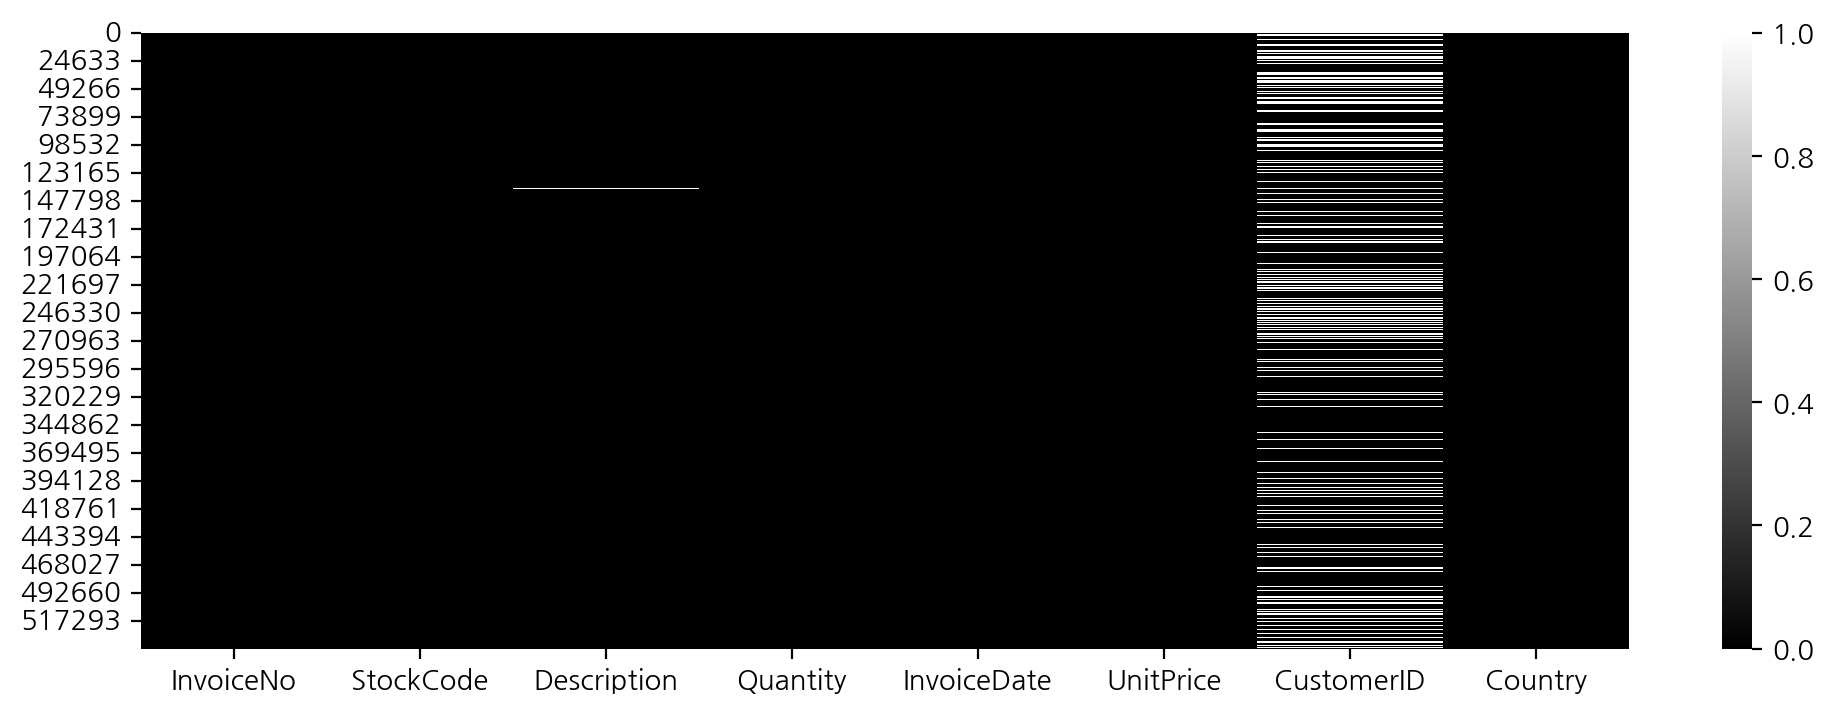

In [11]:
# 결측치 시각화
plt.figure(figsize=(12, 4))
sns.heatmap(df.isna(), cmap='gray')

- 비회원 구매를 회원 구매로 전환할 수 있는 방법 고민 필요

### 1.3 전체 변수 시각화

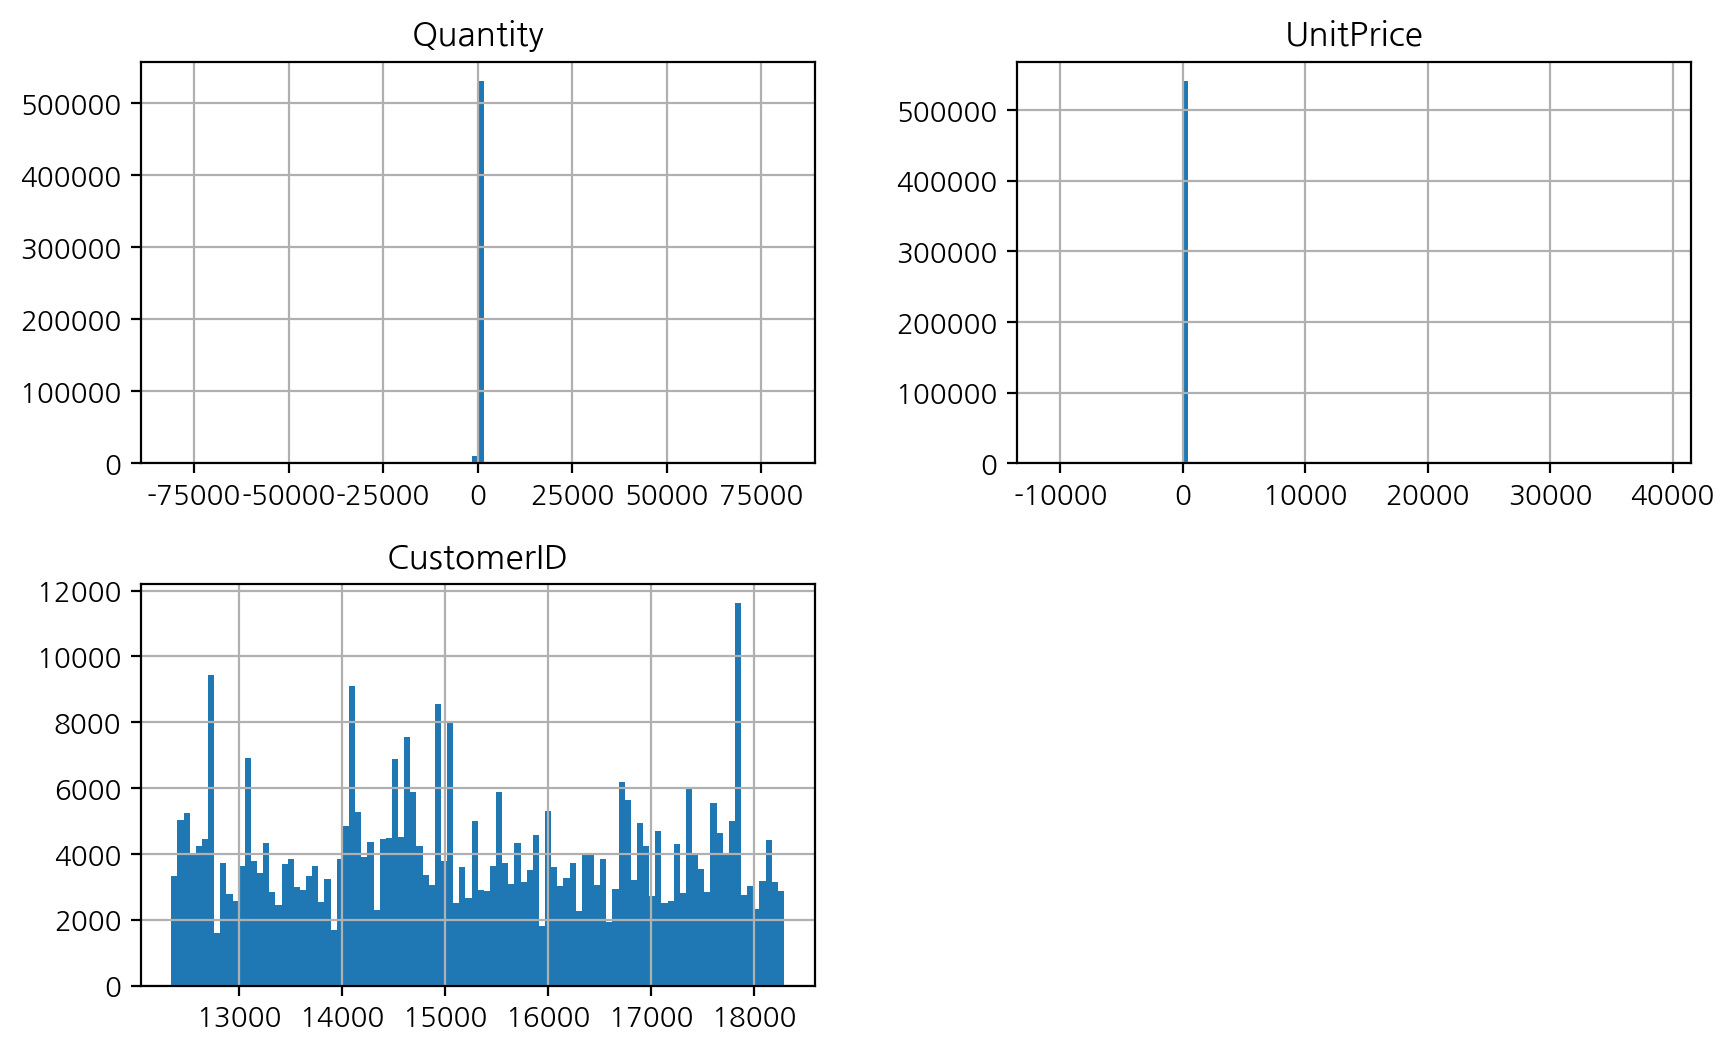

In [12]:
# 히스토그램 시각화
df.hist(figsize=(10, 6), bins=100);

- Quantity 중간에 몰려있으니 이상치 양쪽 끝에
- CustomerID
  - 상대적으로 Uniform함

# 2. 전처리

## 2.1 전체 주문금액 파생변수 만들기
- 수량 * 금액으로 전체 금액 계산

In [13]:
# TotalPrice: RFM 중 MonetaryValue의 값이 됨
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

                InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0       2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1       2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2       2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3       2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4       2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
...                     ...        ...         ...             ...         ...  
541904  2011-12-09 12:50:00       0.85     12680.0          France       10.20  
541905  2011-12-09 12:50:00       2.10     12680.0          France       12.60  
541906  2011-12-09 12:50:00       4.15     12680.0          France       16.60  
541907  2011-12-09 12:50:00       4.15     12680.0          France       16.60  
541908  2011-12-09 12:50:00       4.95     12680.0          France       14.85  

[541909 rows x 9 columns]

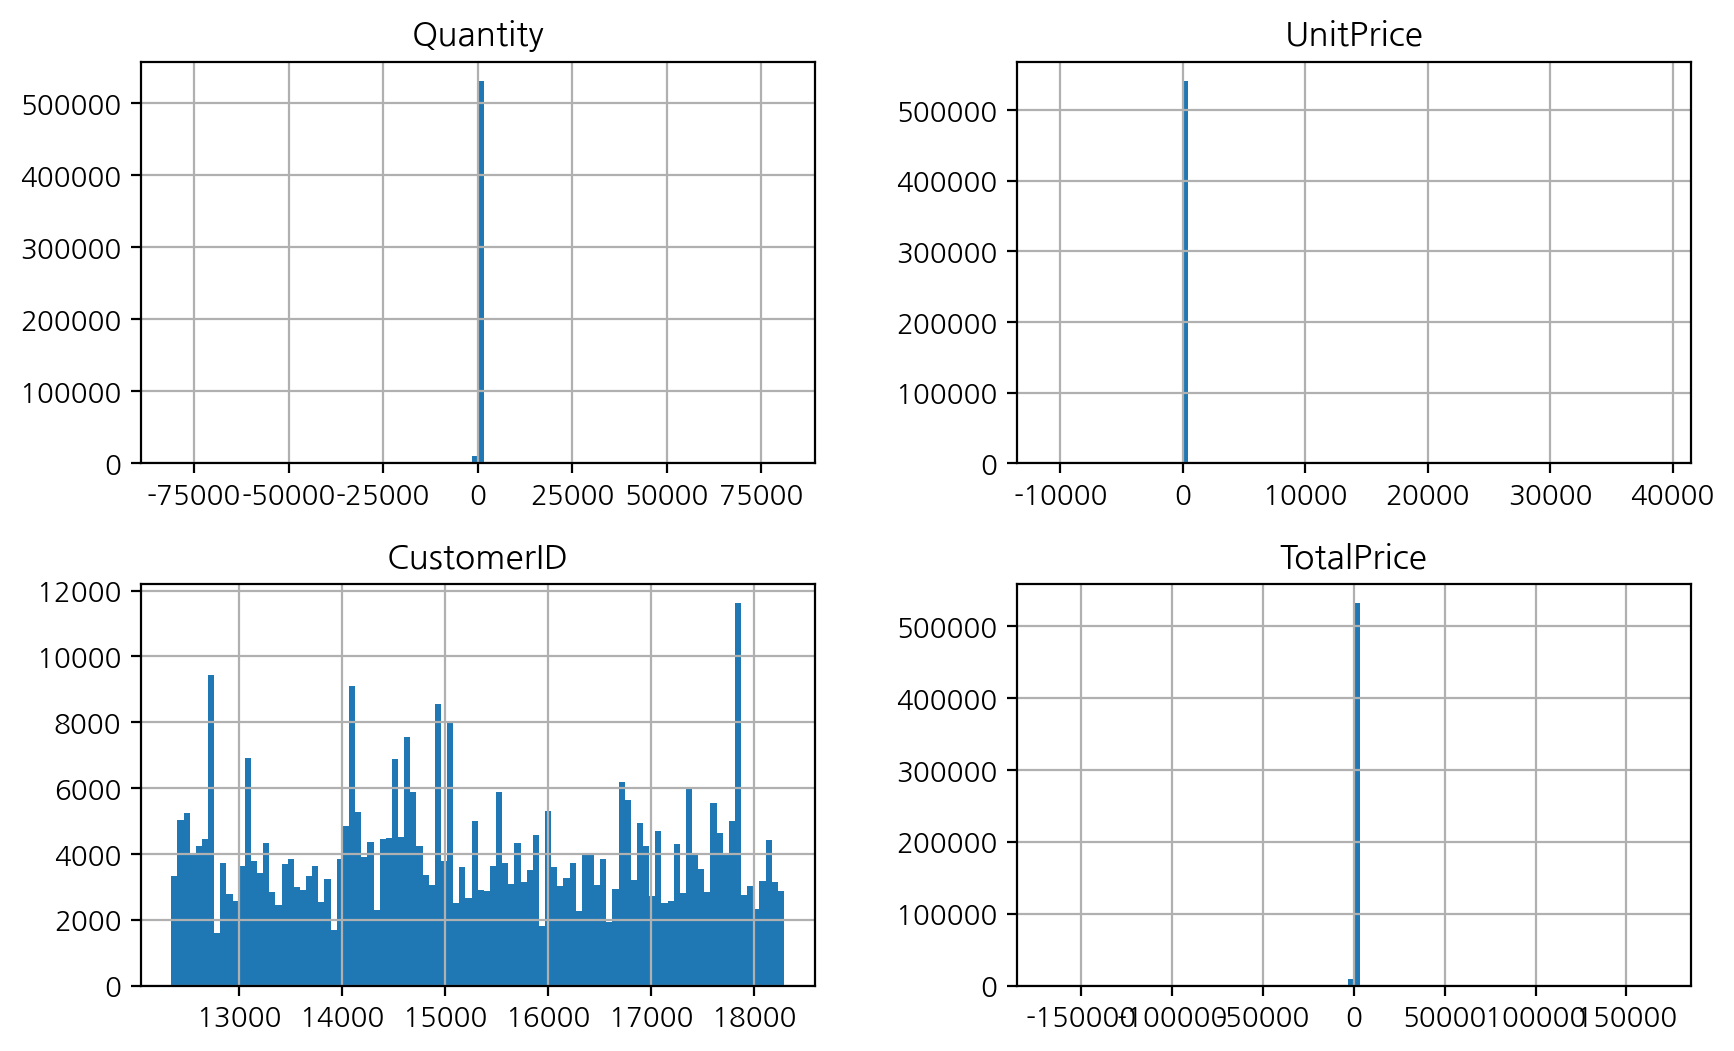

In [14]:
df.hist(figsize=(10,6), bins=100);

# 3. 고객 분석

## 3.1 회원 vs 비회원 구매

In [15]:
# CustomerID값이 결측치인 값에 대한 Country 값을 가져와 빈도 수를 구함
# isnull -> 비회원, not null -> 회원
# .value_counts(1) = .value_counts(normalize=True)

df['CustomerID'].isnull().value_counts(1)

CustomerID
False    0.750733
True     0.249267
Name: proportion, dtype: float64

In [16]:
# CustomerID 값이 결측치가 아닌 값에 대한 Coutry 값을 가져와 빈도수를 구함
df.loc[df['CustomerID'].notnull(), 'Country'].value_counts()

Country
United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45


- 구매를 많이 한 국가에서의 비회원 구매도 많음

In [17]:
# df['isRegistered']
df['isRegistered'] = df['CustomerID'].notnull()
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

   isRegistered  
0          True  
1          True  
2          True  
3          True  
4          True

In [18]:
# 교차표 구해보기
pd.crosstab(df['Country'], df['isRegistered']).sort_values(True, ascending=False)

isRegistered           False   True 
Country                             
United Kingdom        133600  361878
Germany                    0    9495
France                    66    8491
EIRE                     711    7485
Spain                      0    2533
Netherlands                0    2371
Belgium                    0    2069
Switzerland              125    1877
Portugal                  39    1480
Australia                  0    1259
Norway                     0    1086
Italy                      0     803
Channel Islands            0     758
Finland                    0     695
Cyprus                     0     622
Sweden                     0     462
Austria                    0     401
Denmark                    0     389
Japan                      0     358
Poland                     0     341
USA                        0     291
Israel                    47     250
Unspecified              202     244
Singapore                  0     229
Iceland                    0     182
Canada                     0     151
Greece                     0     146
Malta                      0     127
United Arab Emirates       0      68
European Community         0      61
RSA                        0      58
Lebanon                    0      45
Lithuania                  0      35
Brazil                     0      32
Czech Republic             0      30
Bahrain                    2      17
Saudi Arabia               0      10
Hong Kong                288       0

## 3.2 구매 취소

In [19]:
# 고객 취소 비율을 찾기 위해 cancel 칼럼 생성
# Quantity가 0보다 작다면 True, 0보다 크다면 False 값으로 isCancel 칼럼 생성

df['InvoiceCode'] = df['InvoiceNo'].str.replace('[0-9]', '', regex=True)
df['InvoiceCode'].value_counts()

InvoiceCode
     532618
C      9288
A         3
Name: count, dtype: int64

In [20]:
df['isCancel'] = (df['InvoiceCode'] == 'C')
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

   isRegistered InvoiceCode  isCancel  
0          True                 False  
1          True                 False  
2          True                 False  
3          True                 False  
4          True                 False

In [21]:
pd.crosstab(df['isRegistered'], df['InvoiceCode'])

InvoiceCode           A     C
isRegistered                 
False         134694  3   383
True          397924  0  8905

In [22]:
df[df['InvoiceCode'] =='A']
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

   isRegistered InvoiceCode  isCancel  
0          True                 False  
1          True                 False  
2          True                 False  
3          True                 False  
4          True                 False

In [23]:
# 고객별 구매 취소 비율
pd.crosstab(df['CustomerID'], df['isCancel'])

isCancel    False  True 
CustomerID              
12346.0         1      1
12347.0       182      0
12348.0        31      0
12349.0        73      0
12350.0        17      0
...           ...    ...
18280.0        10      0
18281.0         7      0
18282.0        12      1
18283.0       756      0
18287.0        70      0

[4372 rows x 2 columns]

In [24]:
df.groupby(['CustomerID', 'isCancel'])['InvoiceNo'].count().unstack()

isCancel    False  True 
CustomerID              
12346.0       1.0    1.0
12347.0     182.0    NaN
12348.0      31.0    NaN
12349.0      73.0    NaN
12350.0      17.0    NaN
...           ...    ...
18280.0      10.0    NaN
18281.0       7.0    NaN
18282.0      12.0    1.0
18283.0     756.0    NaN
18287.0      70.0    NaN

[4372 rows x 2 columns]

In [25]:
# 고객별 구매취소 비율 상위 CustomerID 10개
customer_cancel = pd.crosstab(df['CustomerID'], df['isCancel'])
customer_cancel.columns = ['정상', '취소']
customer_cancel['취소비율'] = (customer_cancel['취소'] / customer_cancel['정상'])*100

customer_cancel.head()

정상  취소   취소비율
CustomerID                
12346.0       1   1  100.0
12347.0     182   0    0.0
12348.0      31   0    0.0
12349.0      73   0    0.0
12350.0      17   0    0.0

In [26]:
# 고객별 취소비율 상위 10개
customer_cancel.nlargest(10, '취소비율')

정상  취소  취소비율
CustomerID              
12503.0      0   1   inf
12505.0      0   1   inf
12605.0      0   3   inf
12666.0      0   2   inf
12870.0      0   2   inf
12943.0      0   1   inf
13154.0      0   1   inf
13693.0      0   4   inf
13829.0      0   1   inf
13958.0      0   5   inf

- inf
  - 0으로 나눌 수 없기에 나타나는 값

In [27]:
# 고객별 구매취소 빈도 수 상위 CustomerID 10개
customer_cancel.nlargest(10, '취소')

정상   취소        취소비율
CustomerID                       
14911.0     5677  226    3.980976
17841.0     7847  136    1.733146
17511.0      963  113   11.734164
15311.0     2379  112    4.707860
12607.0      101  101  100.000000
14410.0      194   93   47.938144
13798.0      349   90   25.787966
14606.0     2700   82    3.037037
13113.0      201   79   39.303483
12471.0      460   71   15.434783

### **🧑🏻‍🦱 특정 고객의 구매 건 조회**

In [28]:
df[df['InvoiceCode'] == 'C'].describe()

Quantity     UnitPrice    CustomerID     TotalPrice
count   9288.000000   9288.000000   8905.000000    9288.000000
mean     -29.885228     48.393661  14991.666992     -96.556039
std     1145.786965    666.600430   1706.772339    2039.905511
min   -80995.000000      0.010000  12346.000000 -168469.600000
25%       -6.000000      1.450000  13510.000000     -17.700000
50%       -2.000000      2.950000  14895.000000      -8.500000
75%       -1.000000      5.950000  16393.000000      -3.700000
max       -1.000000  38970.000000  18282.000000      -0.120000

- max 값도 마이너스

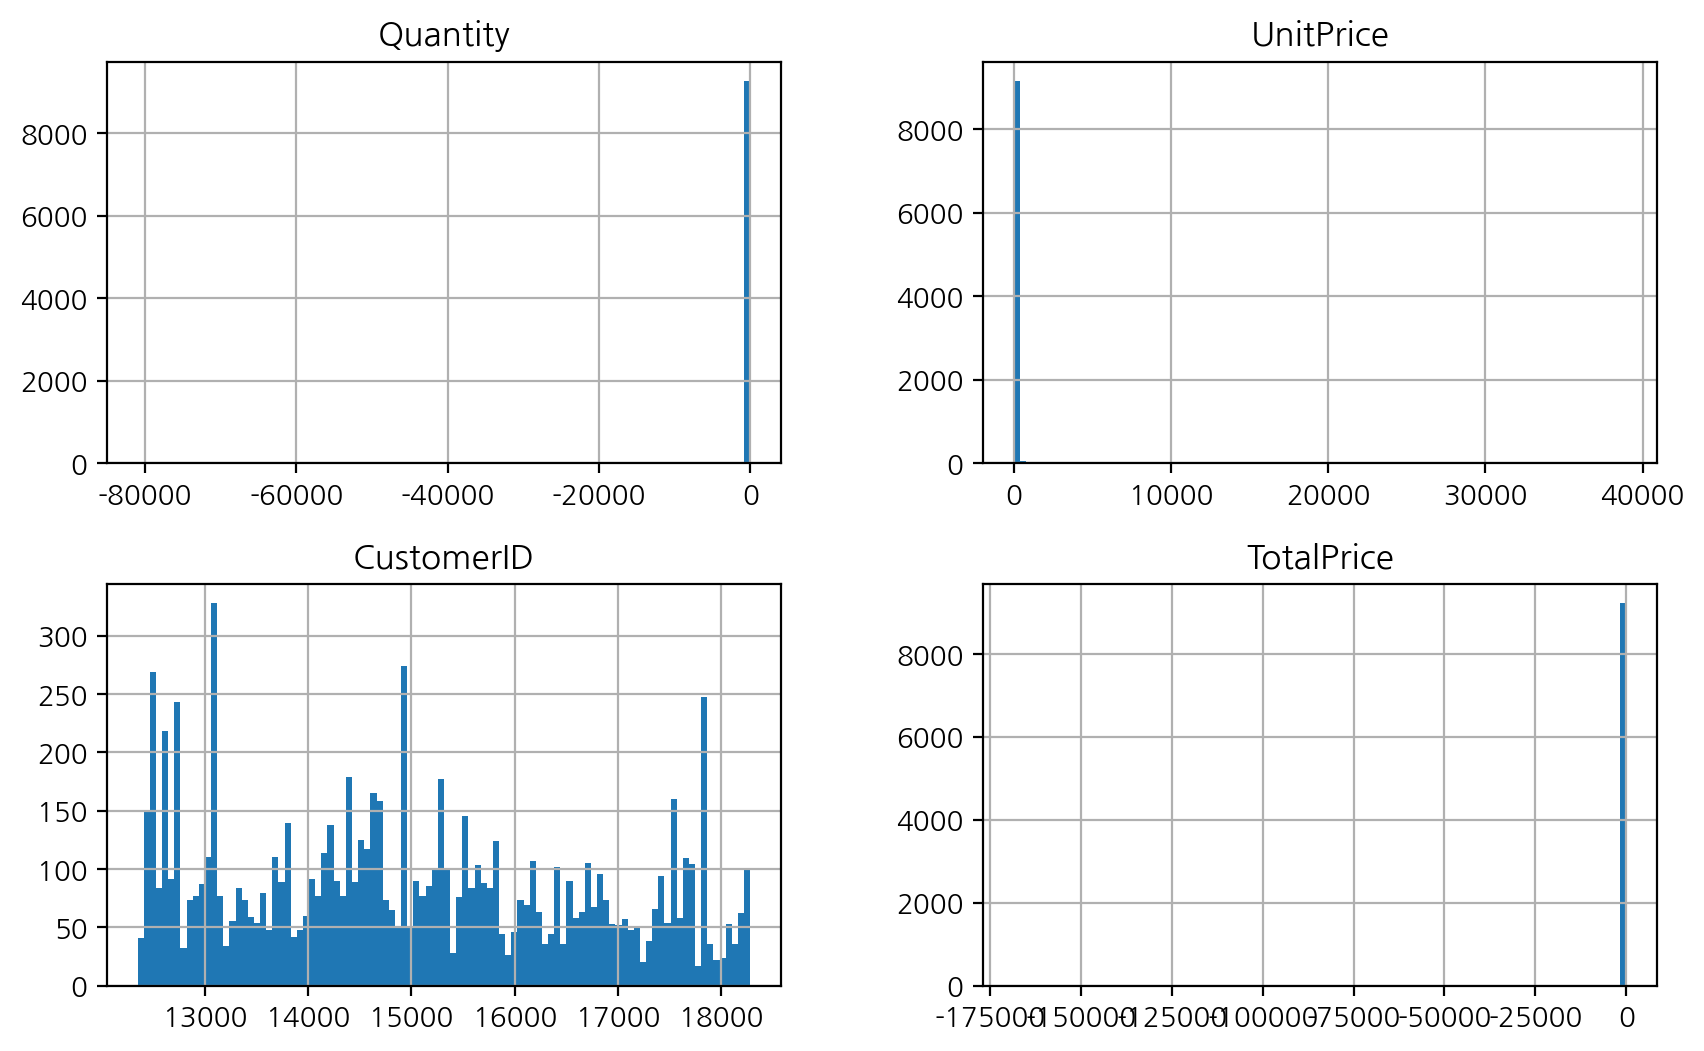

In [29]:
# 취소 건 조회
# 취소 건은 InvoiceNo에 c를 붙이고 Quantity는 마이너스로 표기
df[df['InvoiceCode'] == 'C'].hist(figsize=(10,6), bins=100);

In [30]:
df[df['CustomerID'] == 14911].head()

InvoiceNo StockCode                          Description  Quantity  \
1404    536540     22968           ROSE COTTAGE KEEPSAKE BOX          4   
1405    536540    85071A  BLUE CHARLIE+LOLA PERSONAL DOORSIGN         6   
1406    536540    85071C    CHARLIE+LOLA"EXTREMELY BUSY" SIGN         6   
1407    536540     22355            CHARLOTTE BAG SUKI DESIGN        50   
1408    536540     21579      LOLITA  DESIGN  COTTON TOTE BAG         6   

              InvoiceDate  UnitPrice  CustomerID Country  TotalPrice  \
1404  2010-12-01 14:05:00       9.95     14911.0    EIRE        39.8   
1405  2010-12-01 14:05:00       2.95     14911.0    EIRE        17.7   
1406  2010-12-01 14:05:00       2.55     14911.0    EIRE        15.3   
1407  2010-12-01 14:05:00       0.85     14911.0    EIRE        42.5   
1408  2010-12-01 14:05:00       2.25     14911.0    EIRE        13.5   

      isRegistered InvoiceCode  isCancel  
1404          True                 False  
1405          True                 False  
1406          True                 False  
1407          True                 False  
1408          True                 False

### **🛍️ 제품별 구매 취소 비율**

In [31]:
stock_cancel = pd.crosstab(df['StockCode'], df['isCancel'])

stock_cancel.head()

isCancel   False  True 
StockCode              
10002         73      0
10080         24      0
10120         30      0
10123C         4      0
10123G         1      0

In [32]:
# Description 값 추가
df_stock_desc = df[['StockCode', 'Description']].drop_duplicates('StockCode').dropna().set_index('StockCode')

df_stock_desc

Description
StockCode                                     
85123A      WHITE HANGING HEART T-LIGHT HOLDER
71053                      WHITE METAL LANTERN
84406B          CREAM CUPID HEARTS COAT HANGER
84029G     KNITTED UNION FLAG HOT WATER BOTTLE
84029E          RED WOOLLY HOTTIE WHITE HEART.
...                                        ...
85179a                 GREEN BITTY LIGHT CHAIN
23617      SET 10 CARDS SWIRLY XMAS TREE 17104
90214U               LETTER "U" BLING KEY RING
47591b                SCOTTIES CHILDRENS APRON
23843              PAPER CRAFT , LITTLE BIRDIE

[3894 rows x 1 columns]

In [33]:
df_stock_desc[df_stock_desc.duplicated()]

Description
StockCode                                   
82613C        METAL SIGN,CUPCAKE SINGLE HOOK
10135           COLOURING PENCILS BROWN TUBE
15056bl              EDWARDIAN PARASOL BLACK
15056p                EDWARDIAN PARASOL PINK
47566b                TEA TIME PARTY BUNTING
...                                      ...
72802c     VANILLA SCENT CANDLE JEWELLED BOX
85049c               ROMANTIC PINKS RIBBONS 
85034b     3 WHITE CHOC MORRIS BOXED CANDLES
85179a               GREEN BITTY LIGHT CHAIN
47591b              SCOTTIES CHILDRENS APRON

[141 rows x 1 columns]

- 중복값이 꽤 많음

**제품 설명과 제품 코드 한 데이터 프레임에 합치기**

In [34]:
# merge
stock_cancel.merge(df_stock_desc, left_index=True, right_index=True)

False  True                         Description
StockCode                                                    
10002            73     0         INFLATABLE POLITICAL GLOBE 
10080            24     0            GROOVY CACTUS INFLATABLE
10120            30     0                        DOGGY RUBBER
10123C            4     0               HEARTS WRAPPING TAPE 
10124A            5     0         SPOTS ON RED BOOKCOVER TAPE
...             ...   ...                                 ...
gift_0001_20     10     0  Dotcomgiftshop Gift Voucher £20.00
gift_0001_30      8     0  Dotcomgiftshop Gift Voucher £30.00
gift_0001_40      3     0  Dotcomgiftshop Gift Voucher £40.00
gift_0001_50      4     0  Dotcomgiftshop Gift Voucher £50.00
m                 1     0                              Manual

[3894 rows x 3 columns]

In [35]:
stock_cancel['Desc'] = df_stock_desc['Description']

stock_cancel.head()

isCancel   False  True                         Desc
StockCode                                          
10002         73     0  INFLATABLE POLITICAL GLOBE 
10080         24     0     GROOVY CACTUS INFLATABLE
10120         30     0                 DOGGY RUBBER
10123C         4     0        HEARTS WRAPPING TAPE 
10123G         1     0                          NaN

In [36]:
# join
stock_cancel.join(df_stock_desc)

False  True                                Desc  \
StockCode                                                       
10002            73     0         INFLATABLE POLITICAL GLOBE    
10080            24     0            GROOVY CACTUS INFLATABLE   
10120            30     0                        DOGGY RUBBER   
10123C            4     0               HEARTS WRAPPING TAPE    
10123G            1     0                                 NaN   
...             ...   ...                                 ...   
gift_0001_20     10     0  Dotcomgiftshop Gift Voucher £20.00   
gift_0001_30      8     0  Dotcomgiftshop Gift Voucher £30.00   
gift_0001_40      3     0  Dotcomgiftshop Gift Voucher £40.00   
gift_0001_50      4     0  Dotcomgiftshop Gift Voucher £50.00   
m                 1     0                              Manual   

                                     Description  
StockCode                                         
10002                INFLATABLE POLITICAL GLOBE   
10080                   GROOVY CACTUS INFLATABLE  
10120                               DOGGY RUBBER  
10123C                     HEARTS WRAPPING TAPE   
10123G                                       NaN  
...                                          ...  
gift_0001_20  Dotcomgiftshop Gift Voucher £20.00  
gift_0001_30  Dotcomgiftshop Gift Voucher £30.00  
gift_0001_40  Dotcomgiftshop Gift Voucher £40.00  
gift_0001_50  Dotcomgiftshop Gift Voucher £50.00  
m                                         Manual  

[4070 rows x 4 columns]

In [37]:
stock_cancel.columns = ['정상','취소', '설명']

stock_cancel.head()

정상  취소                           설명
StockCode                                     
10002      73   0  INFLATABLE POLITICAL GLOBE 
10080      24   0     GROOVY CACTUS INFLATABLE
10120      30   0                 DOGGY RUBBER
10123C      4   0        HEARTS WRAPPING TAPE 
10123G      1   0                          NaN

In [38]:
stock_cancel.nlargest(10, '정상')

정상   취소                                  설명
StockCode                                               
85123A     2271   42  WHITE HANGING HEART T-LIGHT HOLDER
85099B     2115   44             JUMBO BAG RED RETROSPOT
22423      2022  181            REGENCY CAKESTAND 3 TIER
47566      1707   20                       PARTY BUNTING
20725      1595   44             LUNCH BAG RED RETROSPOT
84879      1490   12       ASSORTED COLOUR BIRD ORNAMENT
22197      1426   50                SMALL POPCORN HOLDER
22720      1403   74   SET OF 3 CAKE TINS PANTRY DESIGN 
21212      1370   15     PACK OF 72 RETROSPOT CAKE CASES
20727      1328   22             LUNCH BAG  BLACK SKULL.

### **❌ 고객 ID가 없는 주문과 취소 주문은 전체 데이터에서 제외**
- 취소와 취소에 대한 본 주문건 제거
- 고객 ID가 없는 건도 제거

In [39]:
df.shape

(541909, 12)

In [40]:
# CustomerID 가 있고 Quantity, UnitPrice가 0보다 큰 데이터 가져오기
# 구매하고 취소한 건 중 취소한 건만 제외하고 구매 건은 남김
# 유효한 데이터를 df_valid에 할당
# df_valid
# df.shape, df_valid.shape
# Invoice가 숫자로만 되어 있는 것
df_valid = df[df['CustomerID'].notnull() &
(df['Quantity'] > 0) &
(df['UnitPrice'] > 0)].copy()

df.shape, df_valid.shape

((541909, 12), (397884, 12))

In [41]:
df.loc[(df['Quantity'] < 0) & (df['InvoiceCode'] != 'C'), 'Description'].value_counts()

Description
check                        120
damages                       45
damaged                       42
?                             41
sold as set on dotcom         20
                            ... 
FRYING PAN BLUE POLKADOT       0
FRYING PAN PINK POLKADOT       0
FRYING PAN RED POLKADOT        0
FRYING PAN RED RETROSPOT       0
MEMO BOARD COTTAGE DESIGN      0
Name: count, Length: 4223, dtype: int64

In [42]:
df.loc[(df['Quantity']< 0) & (df['InvoiceCode'] != 'C'), 'Description'].value_counts()

Description
check                        120
damages                       45
damaged                       42
?                             41
sold as set on dotcom         20
                            ... 
FRYING PAN BLUE POLKADOT       0
FRYING PAN PINK POLKADOT       0
FRYING PAN RED POLKADOT        0
FRYING PAN RED RETROSPOT       0
MEMO BOARD COTTAGE DESIGN      0
Name: count, Length: 4223, dtype: int64

In [43]:
# 현실 업무라면 각 업무 담당자에게 문의하고 해당 데이터를 사용할 지 결정
df.loc[(df['Quantity']< 0) & (df['InvoiceCode'] != 'C'), 'Quantity'].describe()

count    1336.000000
mean     -154.907934
std       588.292456
min     -9600.000000
25%       -84.000000
50%       -30.000000
75%        -8.000000
max        -1.000000
Name: Quantity, dtype: float64

In [44]:
df.loc[df['UnitPrice'] < 0]

InvoiceNo StockCode      Description  Quantity          InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1  2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  TotalPrice  isRegistered  \
299983  -11062.06         NaN  United Kingdom   -11062.06         False   
299984  -11062.06         NaN  United Kingdom   -11062.06         False   

       InvoiceCode  isCancel  
299983           A     False  
299984           A     False

In [45]:
# 고객 ID가 없는 건도 제거하여 df_valid 변수에 할당
# 중복 데이터 제거
df_valid = df_valid.drop_duplicates().copy()

df_valid.shape

(392692, 12)

# 4. 날짜와 시간에 따른 분석

## 4.1 데이터 타입 변경

In [46]:
# InvoiceDate를 datetime 모듈을 통해 날짜 형식으로 변환
df_valid['InvoiceDate'] = pd.to_datetime(df_valid['InvoiceDate'])

In [47]:
df_valid['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 392692, dtype: datetime64[ns]

In [48]:
# year, month, day, dayofweek를 InvoiceDate에서 추출하여 파생변수로 생성
df_valid['InvoiceYear'] = df_valid['InvoiceDate'].dt.year
df_valid['InvoiceMonth'] = df_valid['InvoiceDate'].dt.month
df_valid['InvoiceDay'] = df_valid['InvoiceDate'].dt.day
df_valid['InvoiceDow'] = df_valid['InvoiceDate'].dt.dayofweek

df_valid.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

   isRegistered InvoiceCode  isCancel  InvoiceYear  InvoiceMonth  InvoiceDay  \
0          True                 False         2010            12           1   
1          True                 False         2010            12           1   
2          True                 False         2010            12           1   
3          True                 False         2010            12           1   
4          True                 False         2010            12           1   

   InvoiceDow  
0           2  
1           2  
2           2  
3           2  
4           2

In [49]:
# InvoiceDate에서 앞에서 7개 문자만 가져오면 [:7] 이면 월만 따로 생성
df_valid['InvoiceYM'] = df_valid['InvoiceDate'].astype(str).str[:7]
df_valid[['InvoiceDate', 'InvoiceYM']].sample(2)

InvoiceDate InvoiceYM
467606 2011-11-14 17:11:00   2011-11
451466 2011-11-09 10:39:00   2011-11

In [50]:
# time, hour에 대한 파생변수도
df_valid['InvoiceTime'] = df_valid['InvoiceDate'].dt.time
df_valid['InvoiceHour'] = df_valid['InvoiceDate'].dt.hour

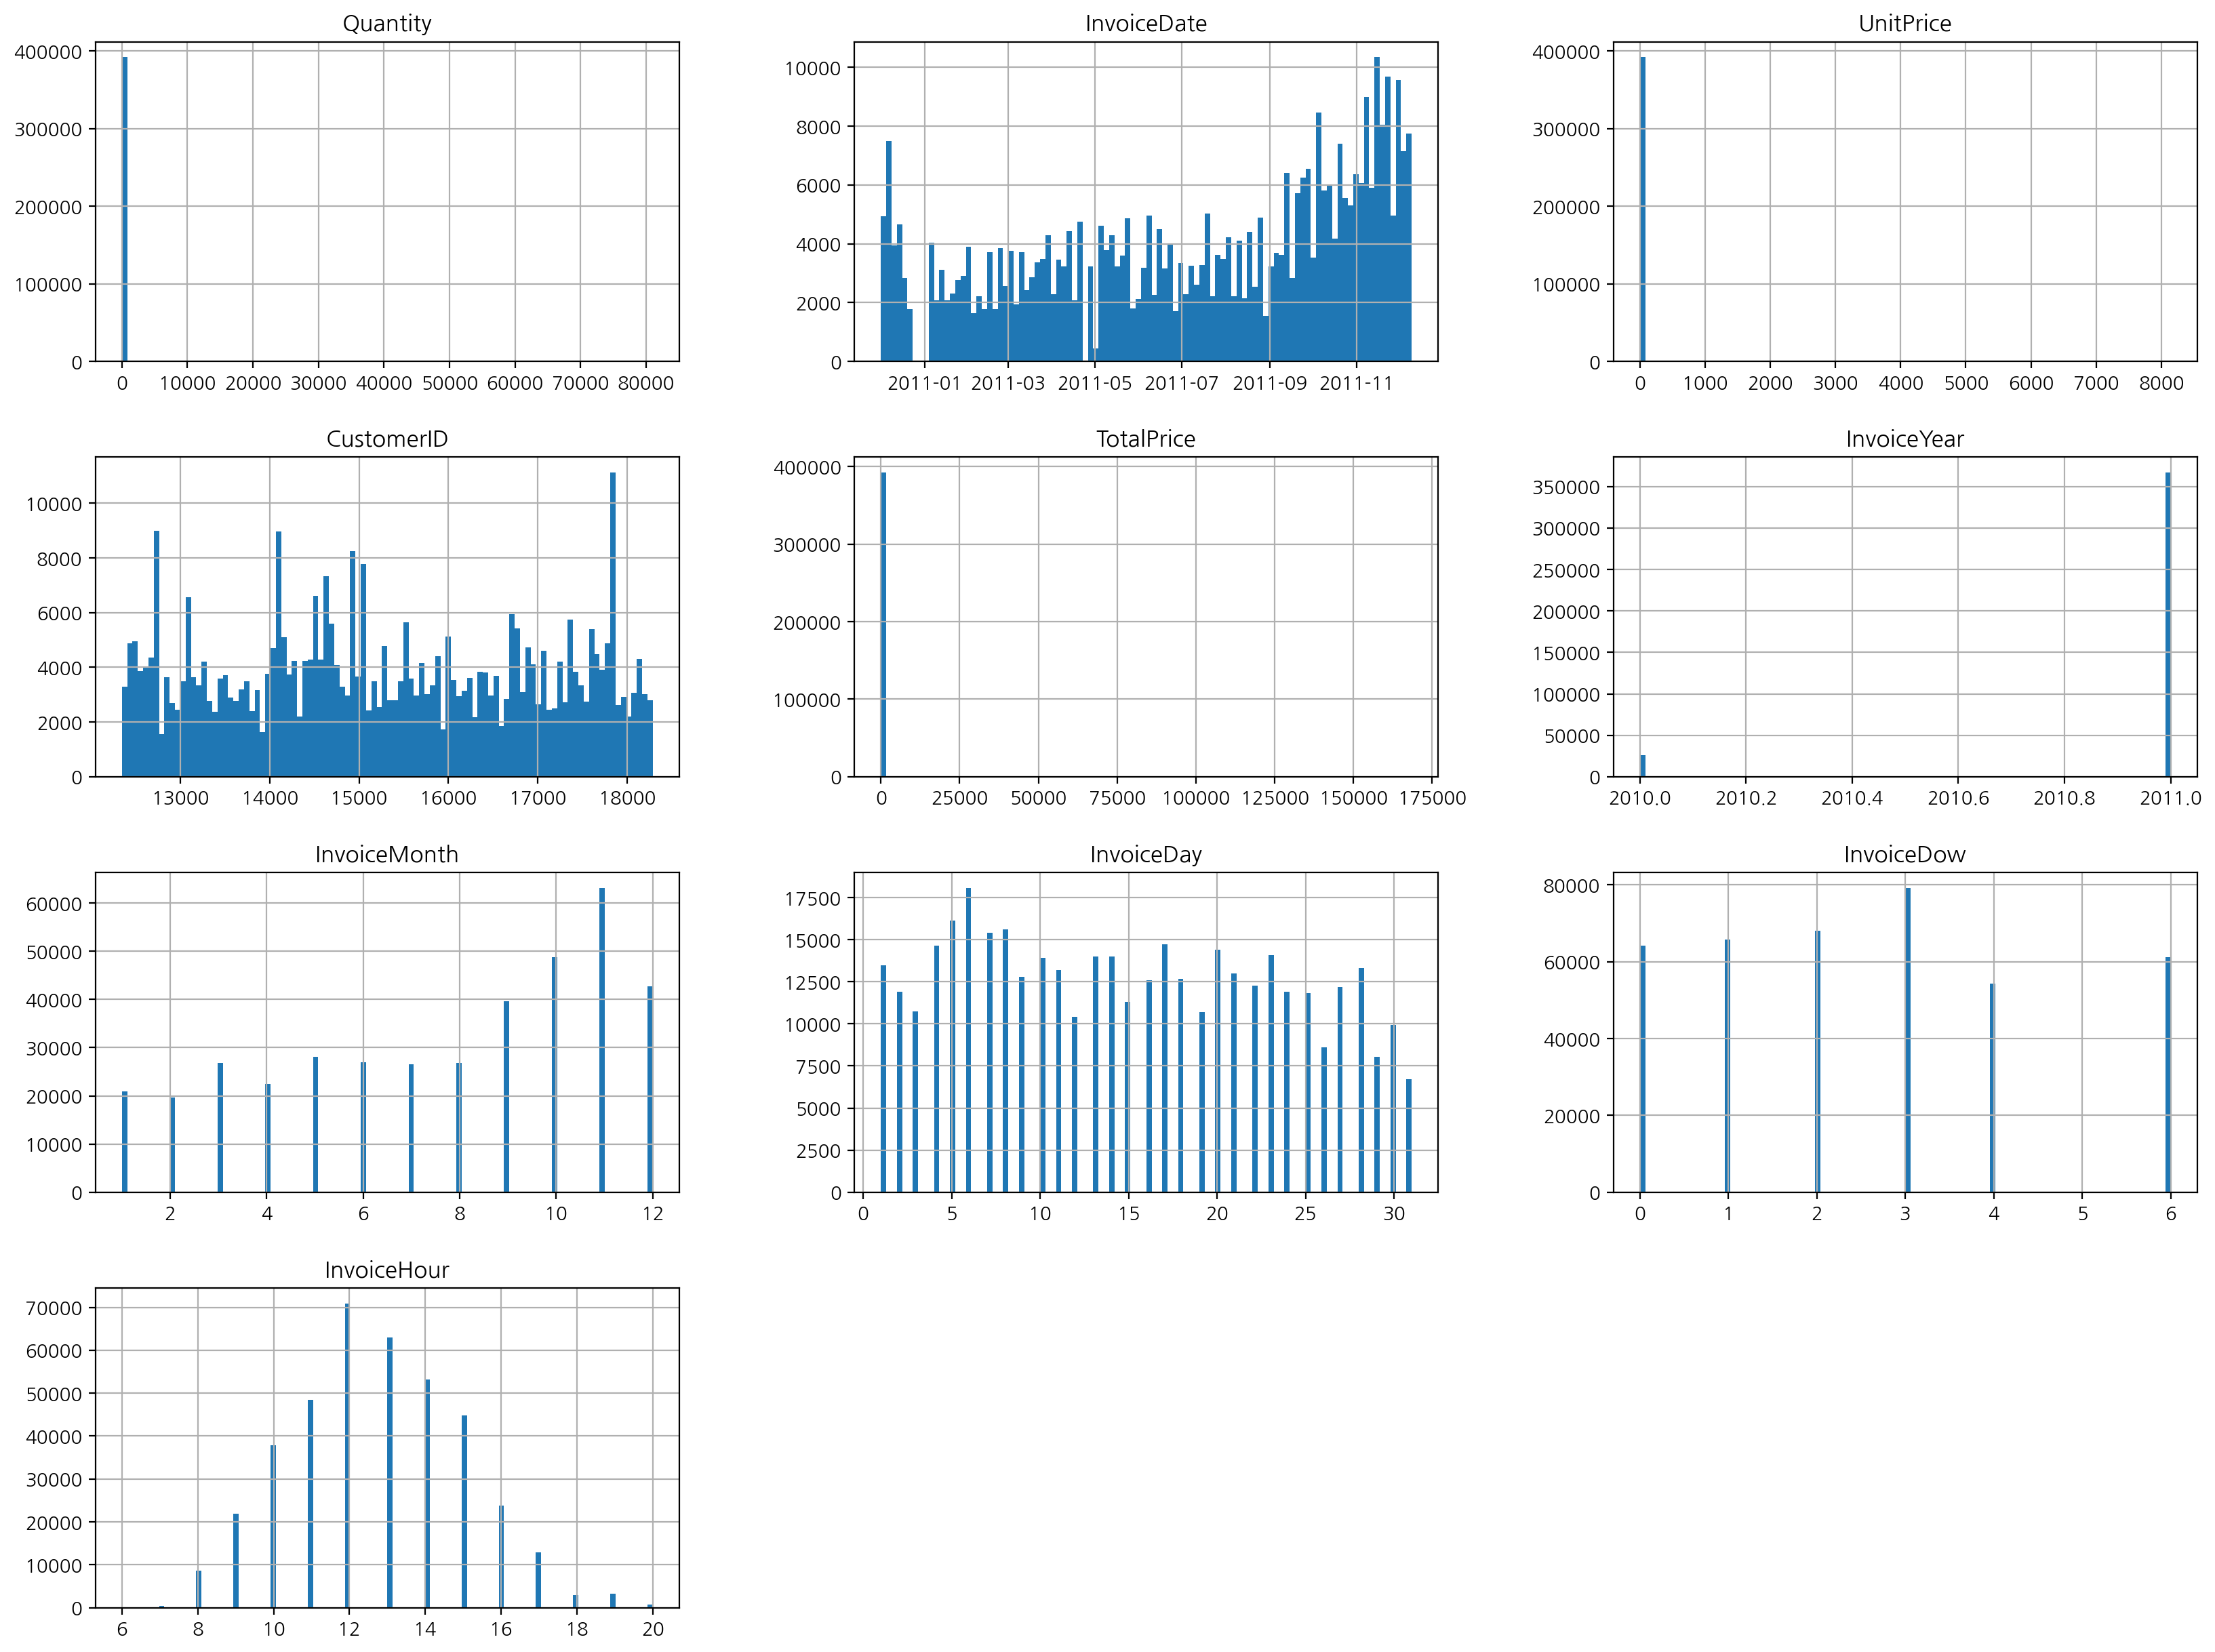

In [51]:
df_valid.hist(figsize=(20, 15), bins=100);

- 토요일 데이터가 제공되지 않은 듯

## 4.2 연도별

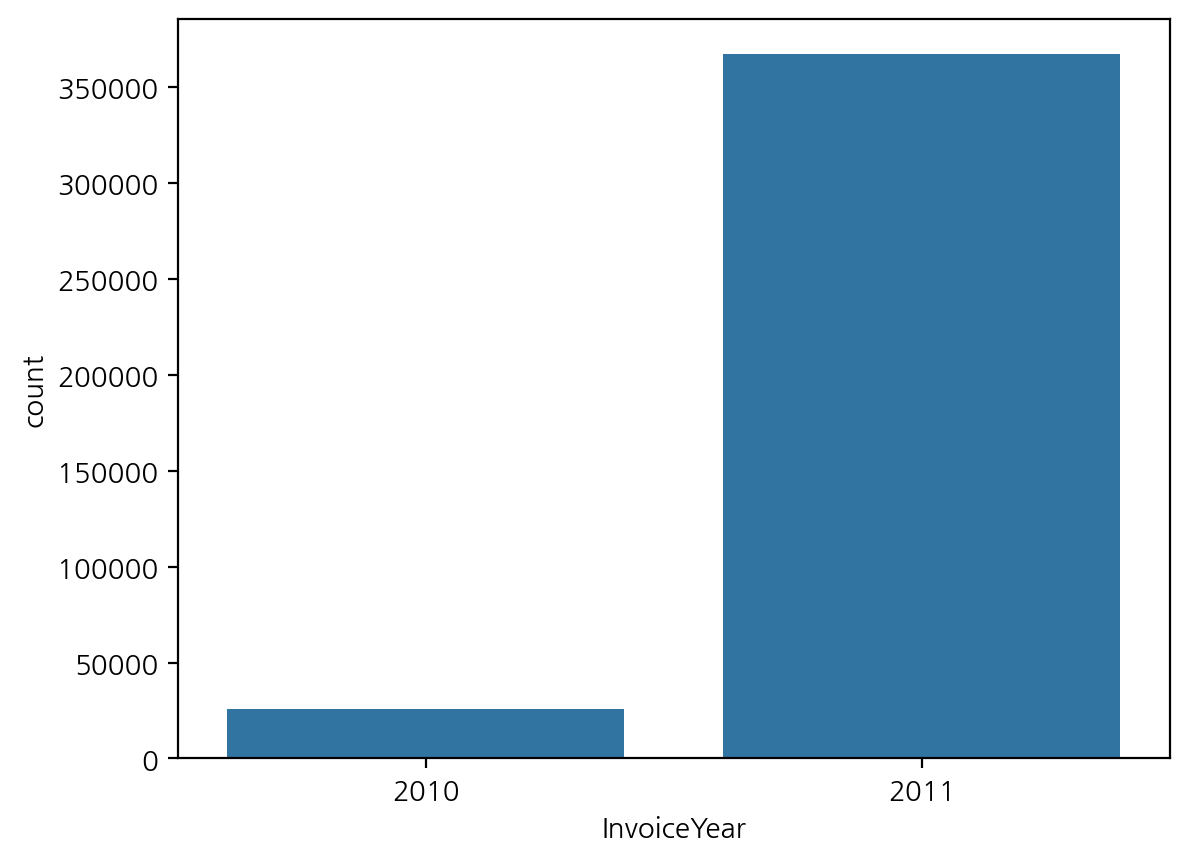

In [52]:
# countplot으로 연도(InvoiceYear)별 구매 빈도 수 시각화
sns.countplot(data=df_valid, x='InvoiceYear');

## 4.3 연도&월별

<Axes: xlabel='InvoiceYM', ylabel='count'>

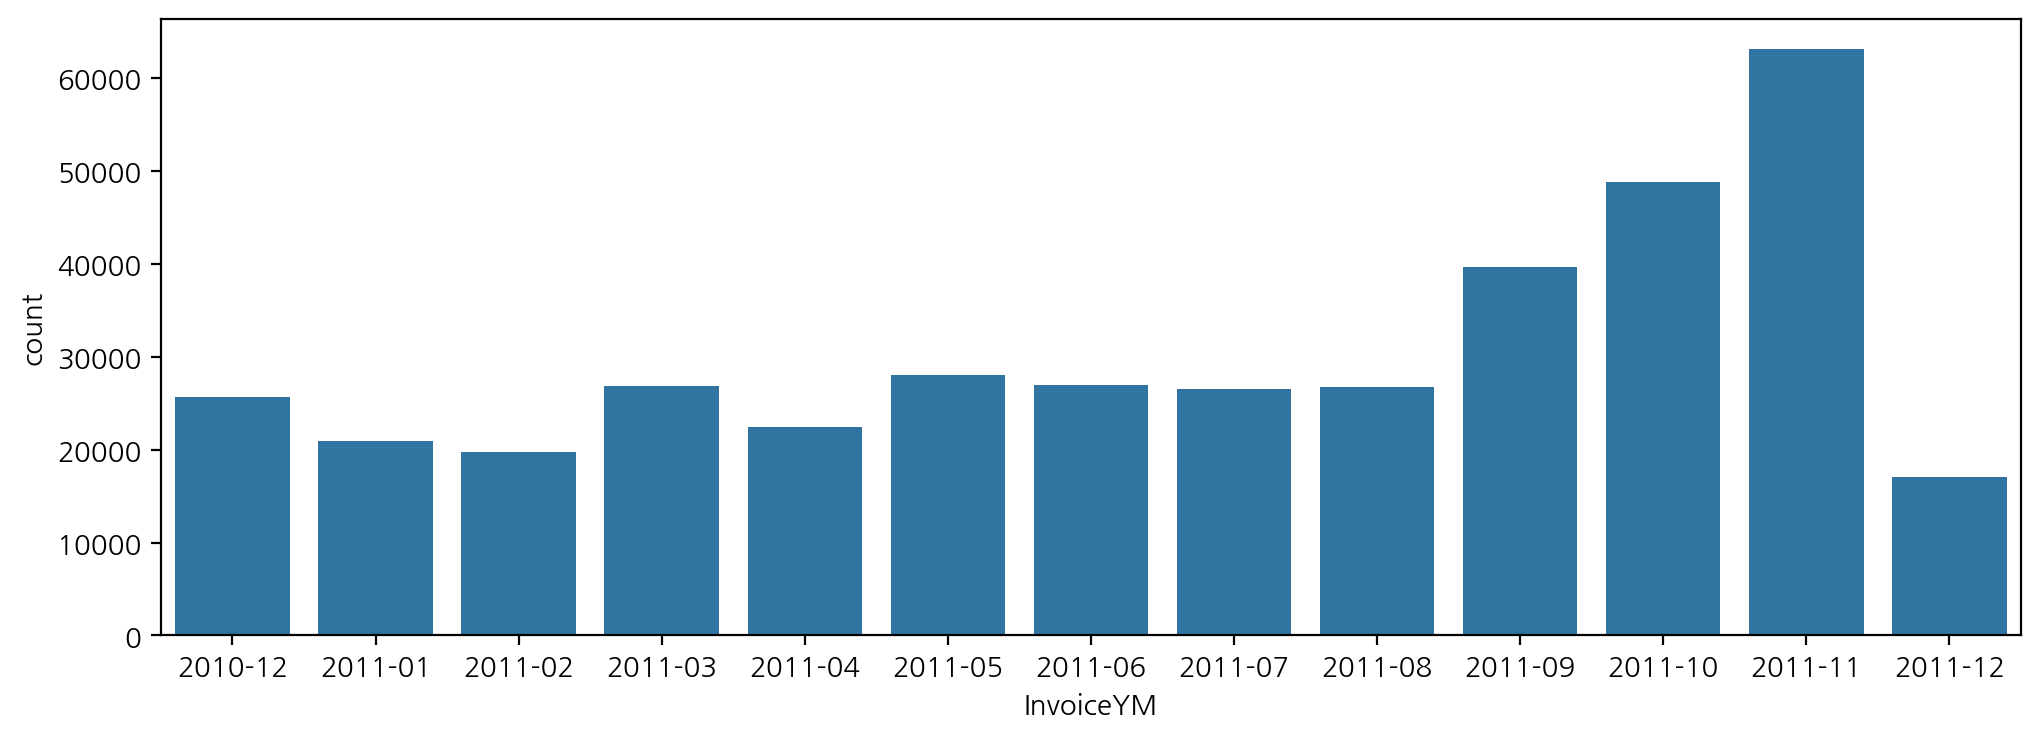

In [53]:
plt.figure(figsize=(12, 4))
sns.countplot(data = df_valid, x = 'InvoiceYM')

## 4.4 요일별

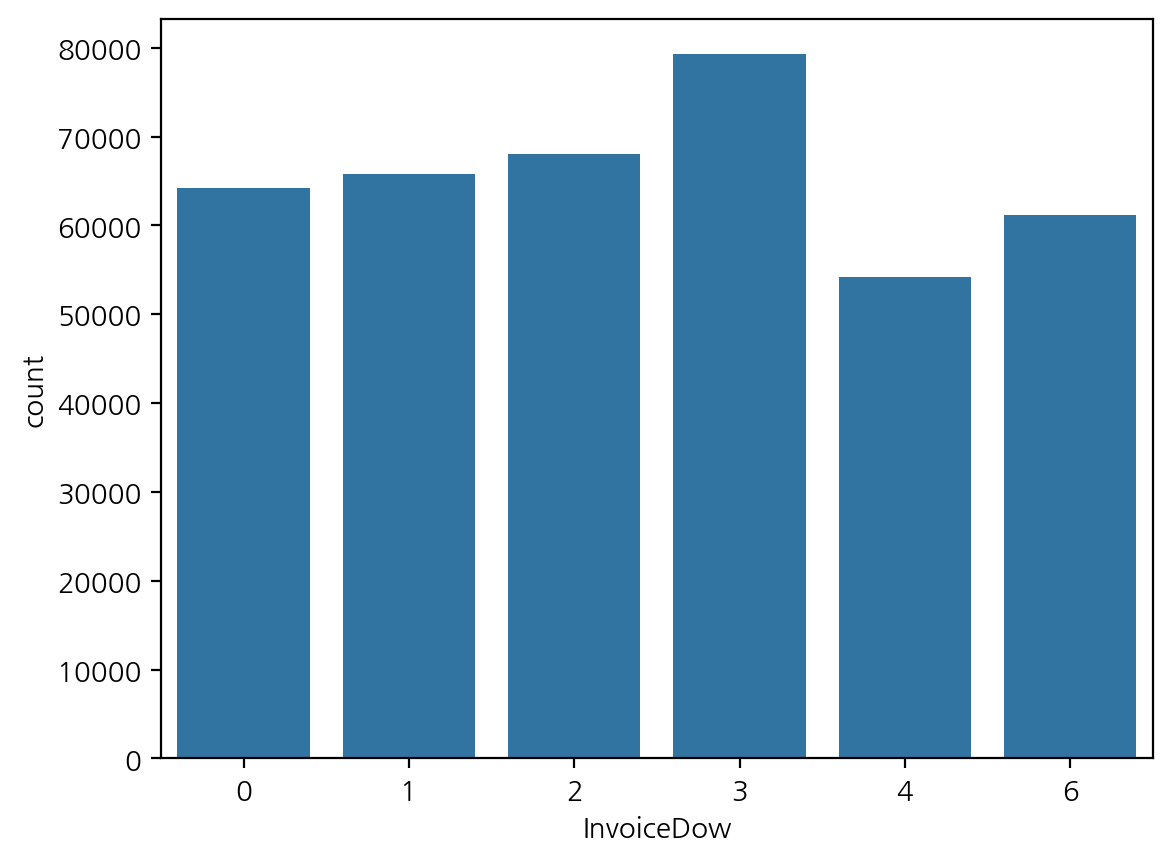

In [54]:
# countplot으로 요일별 InvoiceDow 구매 빈도 수 시각화
sns.countplot(data = df_valid, x = 'InvoiceDow');

In [55]:
# 리스트 컴프리헨션(List Comprehension)을 통해 "월~일" 
# 리스트 컴프리헨션은 리스트 내부에서 반복문을 작성해 반복하는 형식
# '월화수목금토' 를 ['월','화', '수', '목', '금', '토 ''일]로 만들기
day_name = [w for w in "월화수목금토일"]

day_name

['월', '화', '수', '목', '금', '토', '일']

In [56]:
# 데이터를 보면 토요일이 없음
day_name.remove('토')

day_name

['월', '화', '수', '목', '금', '일']

In [57]:
# value_counts()로 요일별 (InvoiceDow) 구매 빈도 수 구하기
# dow_count
dow_count = df_valid['InvoiceDow'].value_counts().sort_index()
dow_count.index = day_name
dow_count

월    64231
화    65744
수    68040
목    79243
금    54222
일    61212
Name: count, dtype: int64

<Axes: >

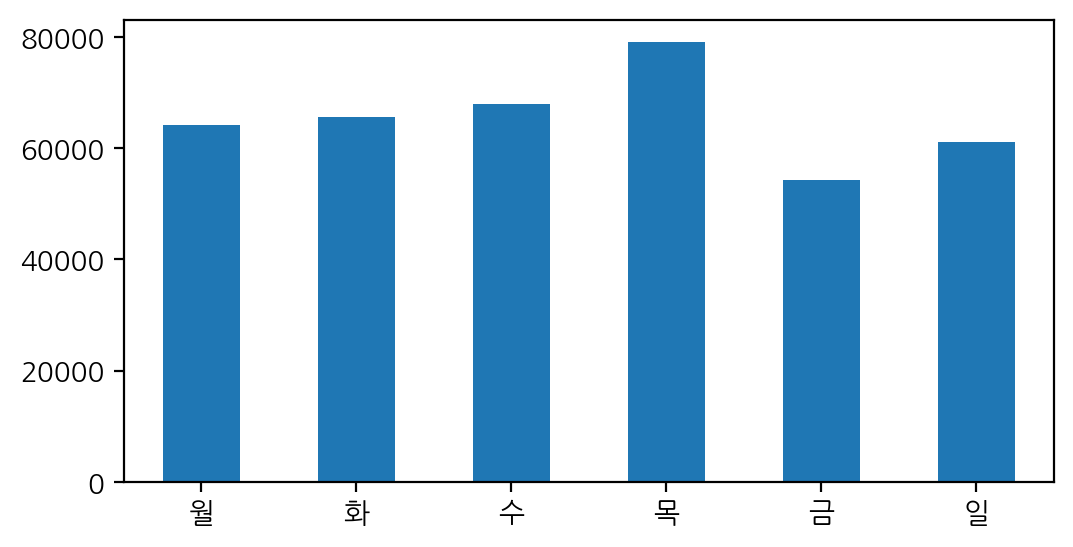

In [58]:
dow_count.plot.bar(figsize=(6, 3), rot = 0)

<Axes: xlabel='InvoiceDayName', ylabel='count'>

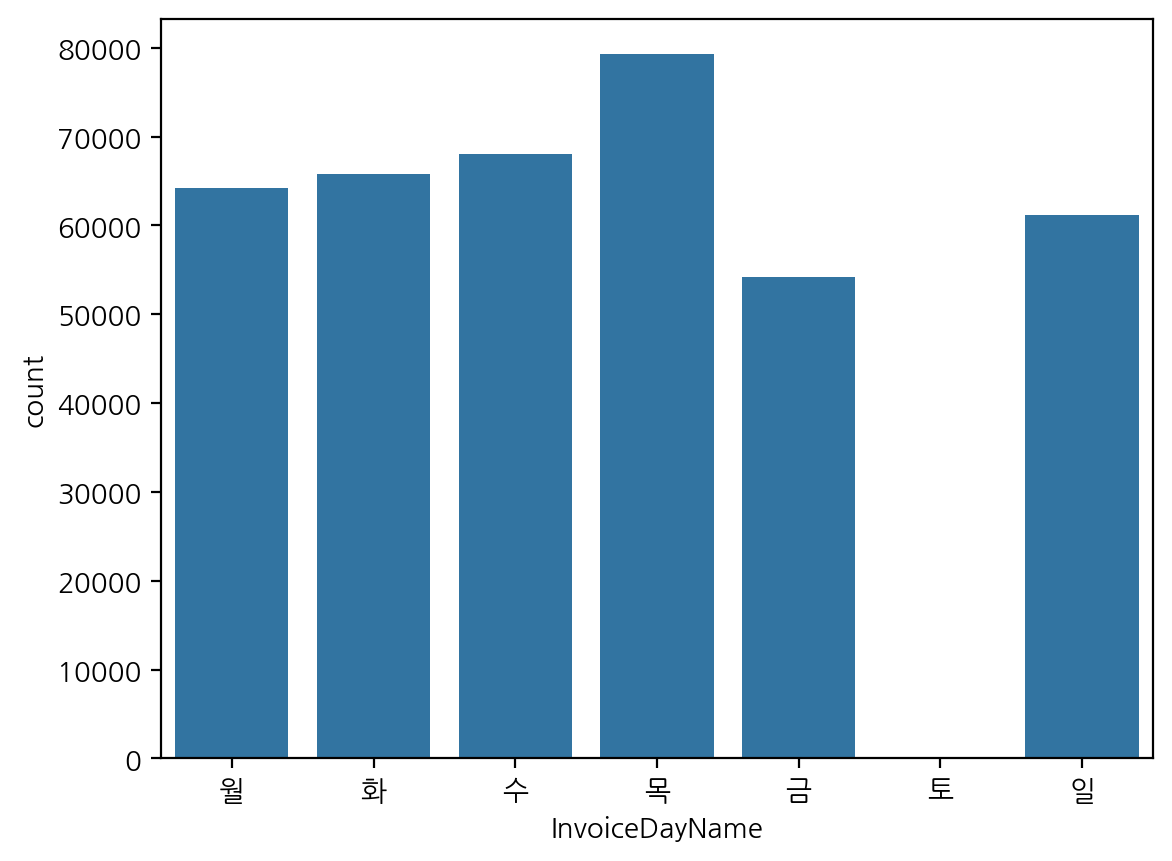

In [59]:
df_valid['InvoiceDayName'] = df_valid['InvoiceDow'].map(lambda x : '월화수목금토일'[x])

sns.countplot(data=df_valid, x='InvoiceDayName', order = list("월화수목금토일"))

## 4.5 시간대별

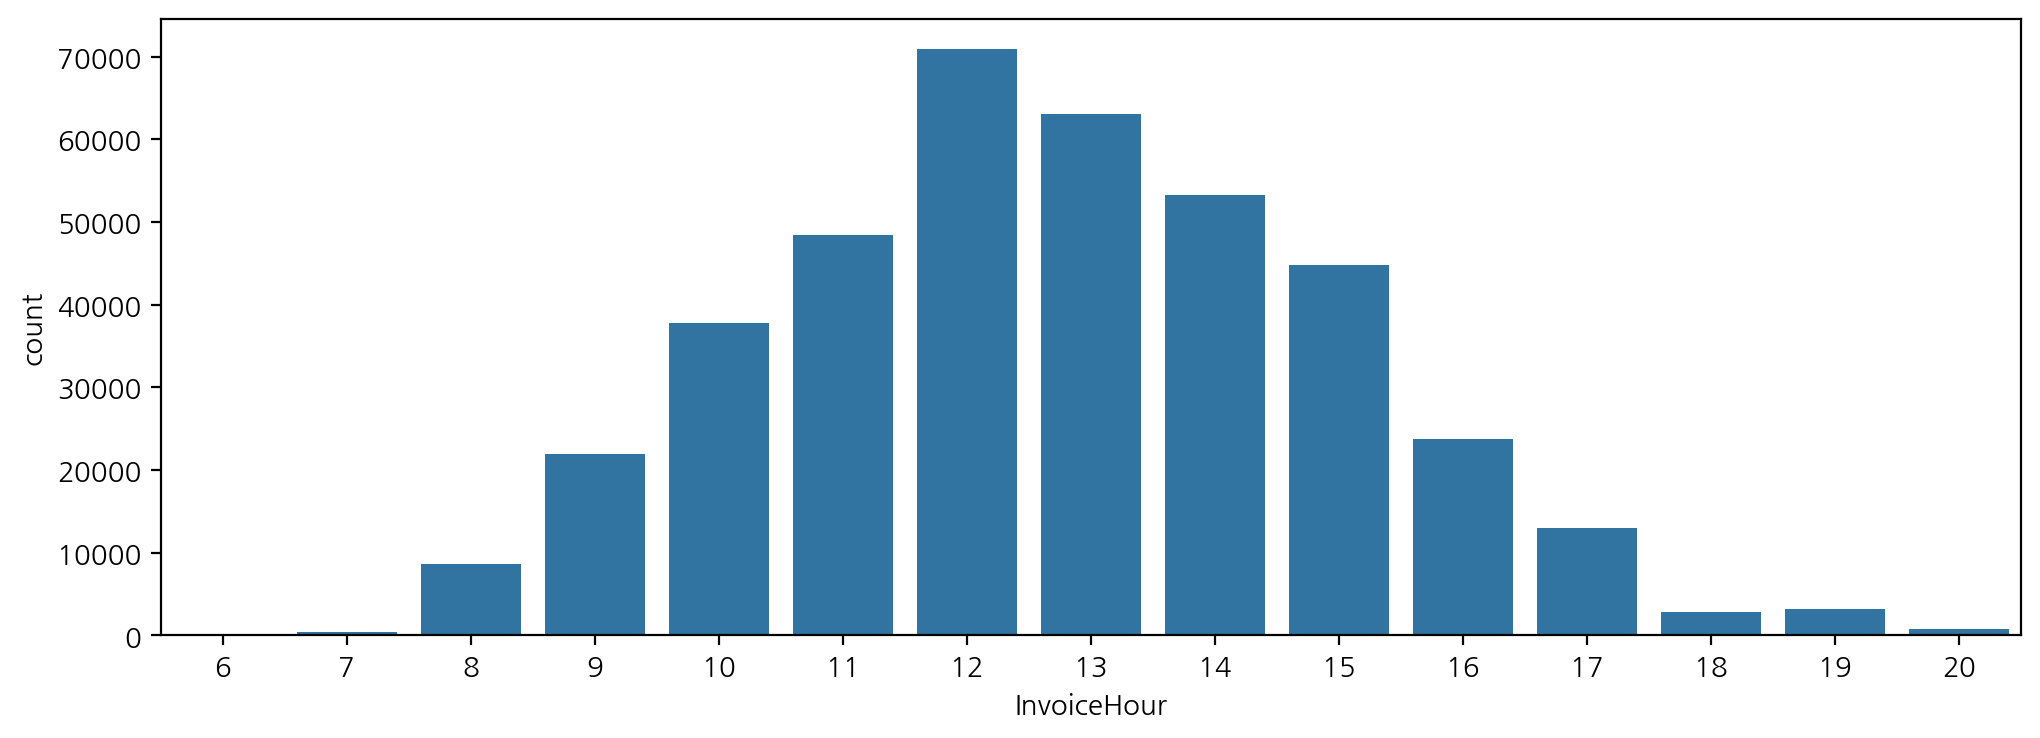

In [60]:
# countplot으로 시간대(InvoiceHour) 구매 빈도 수를 시각화
plt.figure(figsize=(12, 4))
sns.countplot(data=df_valid, x='InvoiceHour');

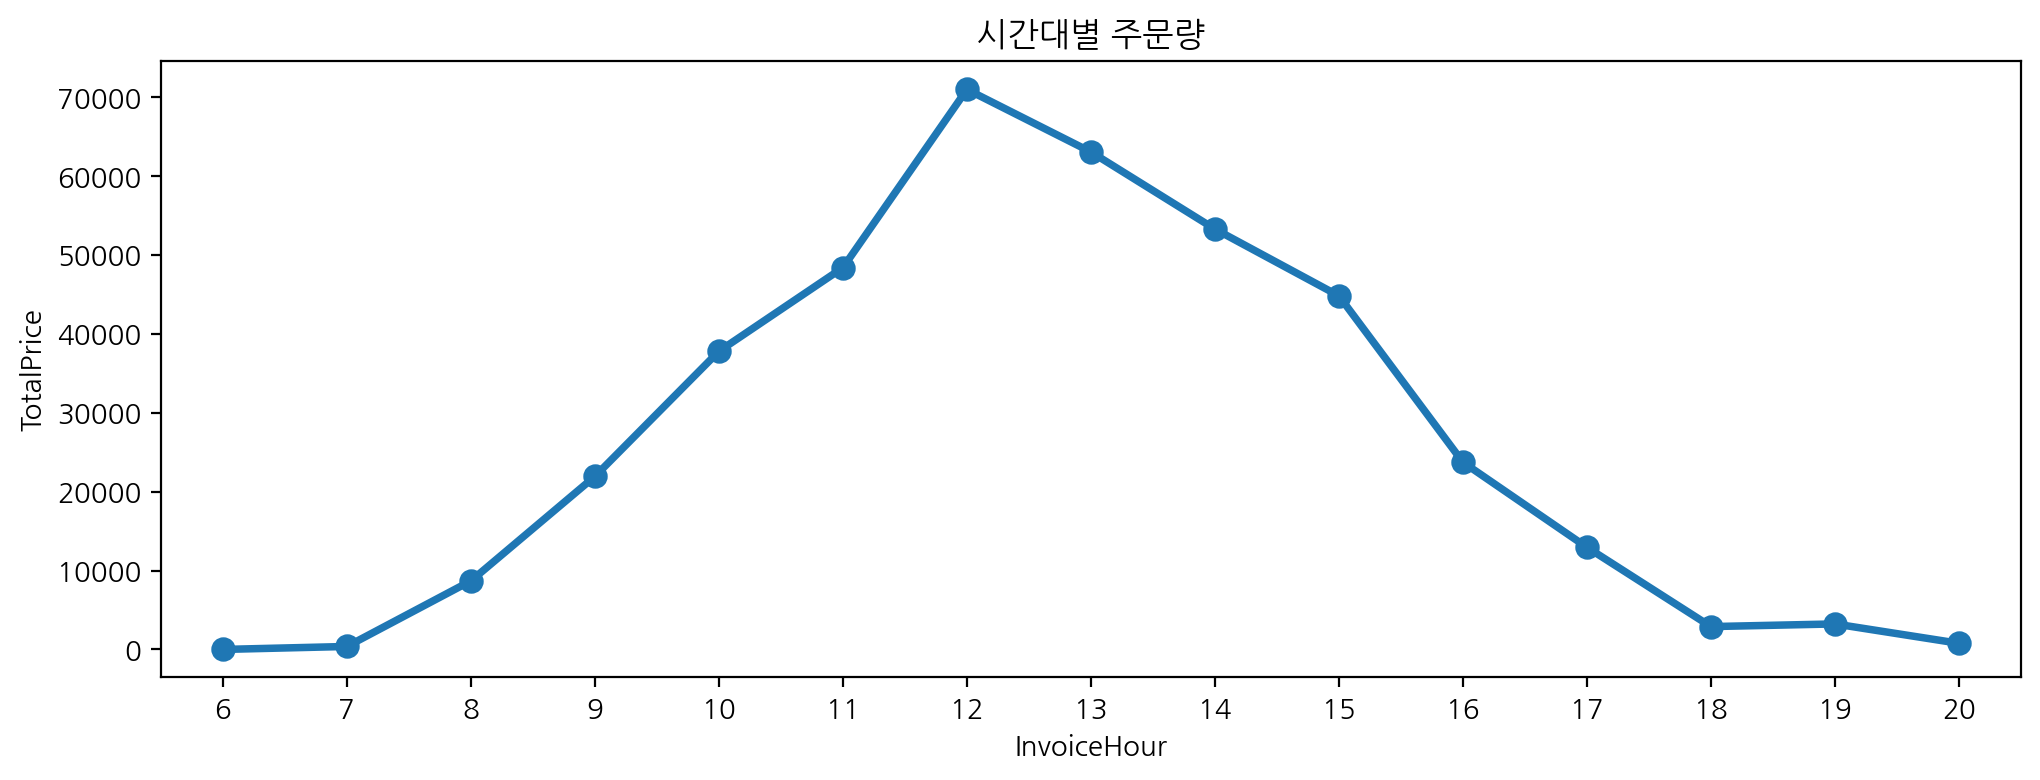

In [61]:
# pointplot으로 시간대(InvoiceHour) 구매 빈도 수를 시각화
# 주문 건수
plt.figure(figsize=(12, 4))
sns.pointplot(data=df_valid, x='InvoiceHour', y='TotalPrice', estimator=len, errorbar=None).set_title("시간대별 주문량");

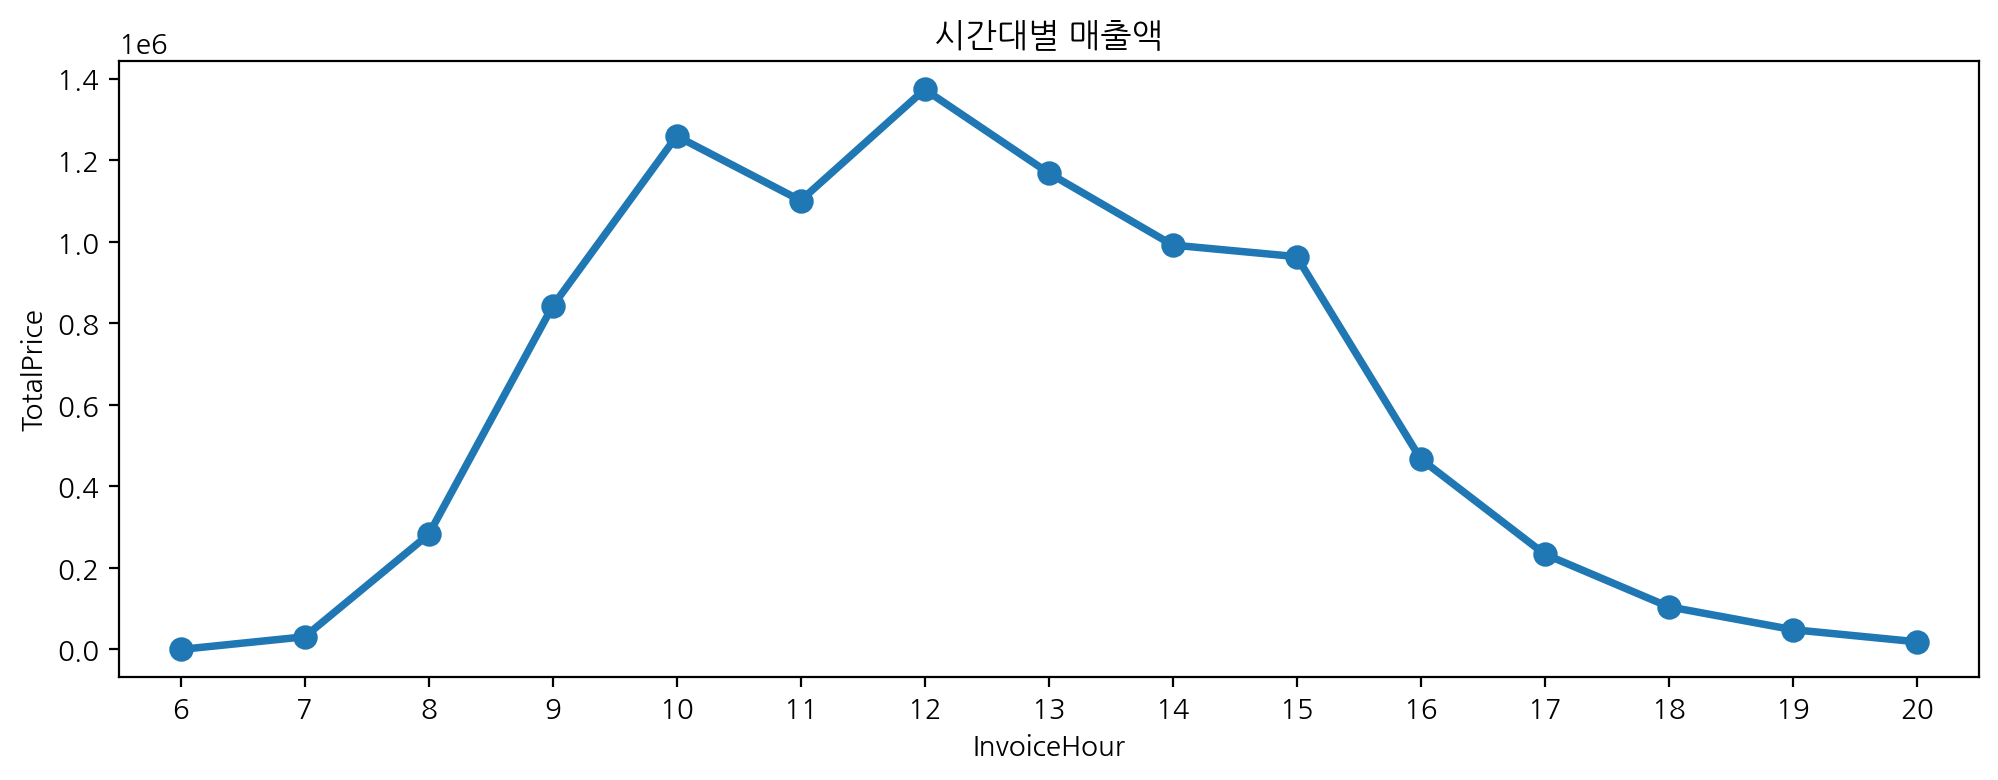

In [62]:
# 매출액
plt.figure(figsize=(12, 4))
sns.pointplot(data=df_valid, x='InvoiceHour', y='TotalPrice', estimator=sum, errorbar=None).set_title("시간대별 매출액");

- 대체로 주문 건수가 높을때 매출액도 높음

## 4.6 시간&요일별

In [63]:
# 시간대별(InvoiceHour), 요일별(InvoiceDow)로 crosstab을 통해 구매 빈도 수 구하기
hour_dow = pd.crosstab(df_valid['InvoiceHour'], df_valid['InvoiceDayName'])
# 리스트컴프리헨션(List comprehension)을 통해 토요일을 제외한 요일 문자열 리스트를 컬럼명으로 대체
hour_dow = hour_dow[list('월화수목금일')]
hour_dow

InvoiceDayName      월      화      수      목     금      일
InvoiceHour                                            
6                   0      0      0      1     0      0
7                  61     65     59     64   130      0
8                1563   1710   1818   1763  1833      0
9                4345   4542   4078   4569  4368     25
10               6106   6575   6927   7528  7161   3476
11               7401   8418   8292   7134  7189   9931
12              10585  11903  12684  12908  9765  13093
13              10459  10274  11137  11446  8300  11403
14               9119   9428   8716   9173  7227   9588
15               7634   7219   7752   7616  4682   9887
16               3999   3592   4197   6031  2087   3809
17               2959   1951   2348   4300  1383      0
18                  0     67      0   2826     2      0
19                  0      0     14   3131    88      0
20                  0      0     18    753     7      0

In [64]:
# 사용 가능한 컬러맵들
# print(plt.colormaps())

In [65]:
# 위에서 구한 값을 .style.background_gradient() 통해서 시각화
hour_dow.style.background_gradient(axis=None, cmap='PuBu').format('{:,}')

- 12시에 주문이 많은 편임

<Axes: xlabel='InvoiceDayName', ylabel='InvoiceHour'>

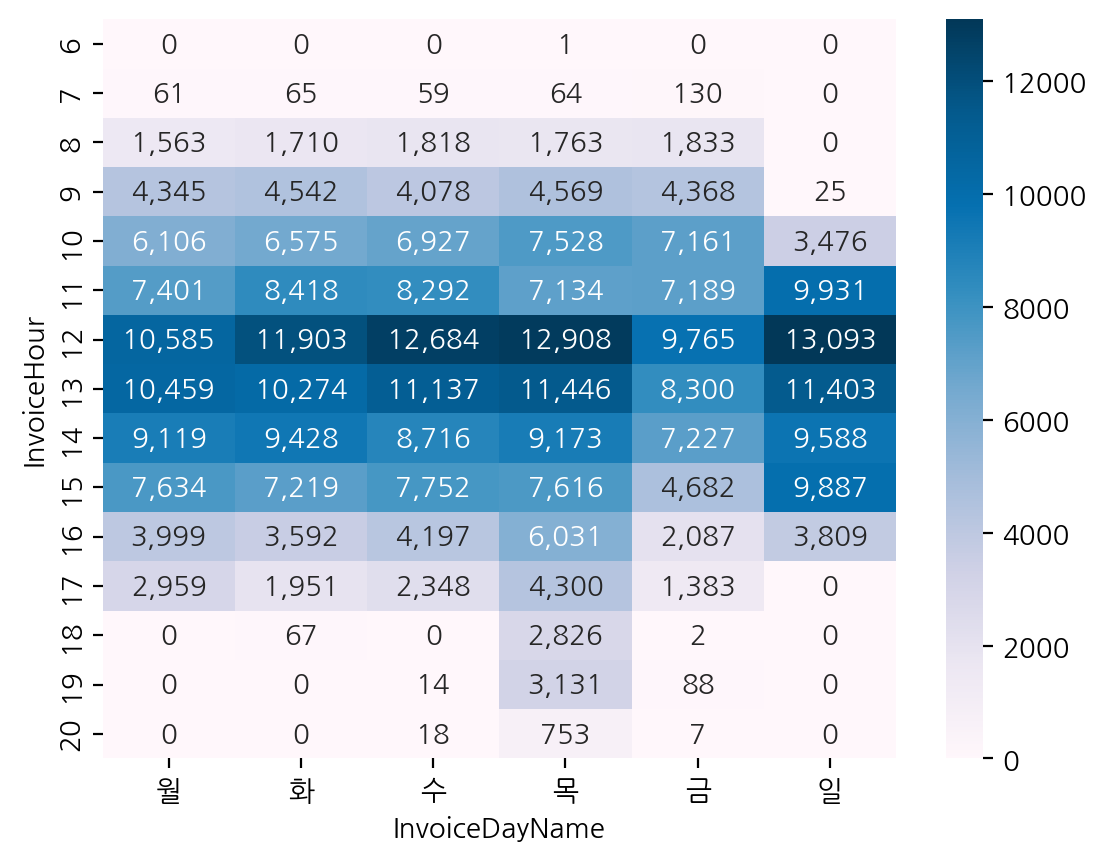

In [66]:
# 시간별 요일별 구매 주문 시각화
sns.heatmap(hour_dow, cmap='PuBu', annot=True, fmt=',.0f' )

<Axes: xlabel='InvoiceHour'>

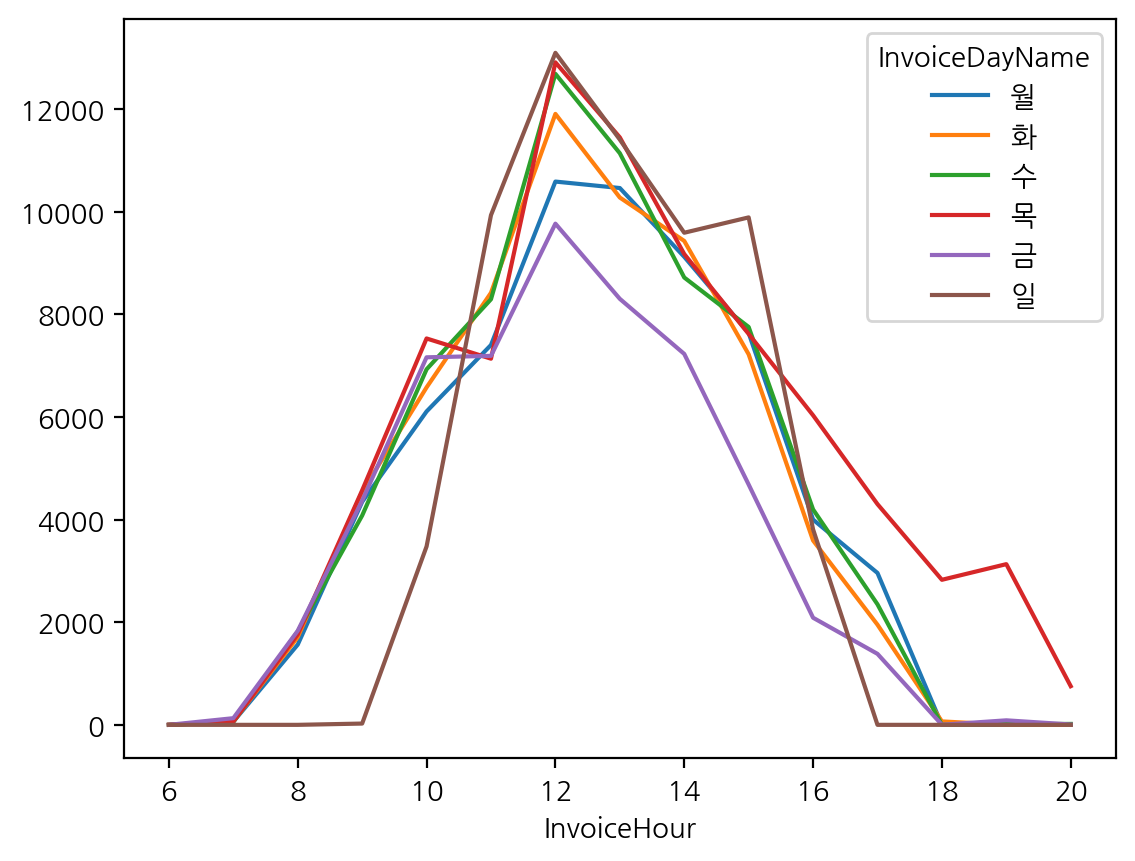

In [67]:
# 시간별 요일별 구매 주문 subplot을 통해 요일별 시각화
hour_dow.plot()

<Figure size 1200x800 with 0 Axes>

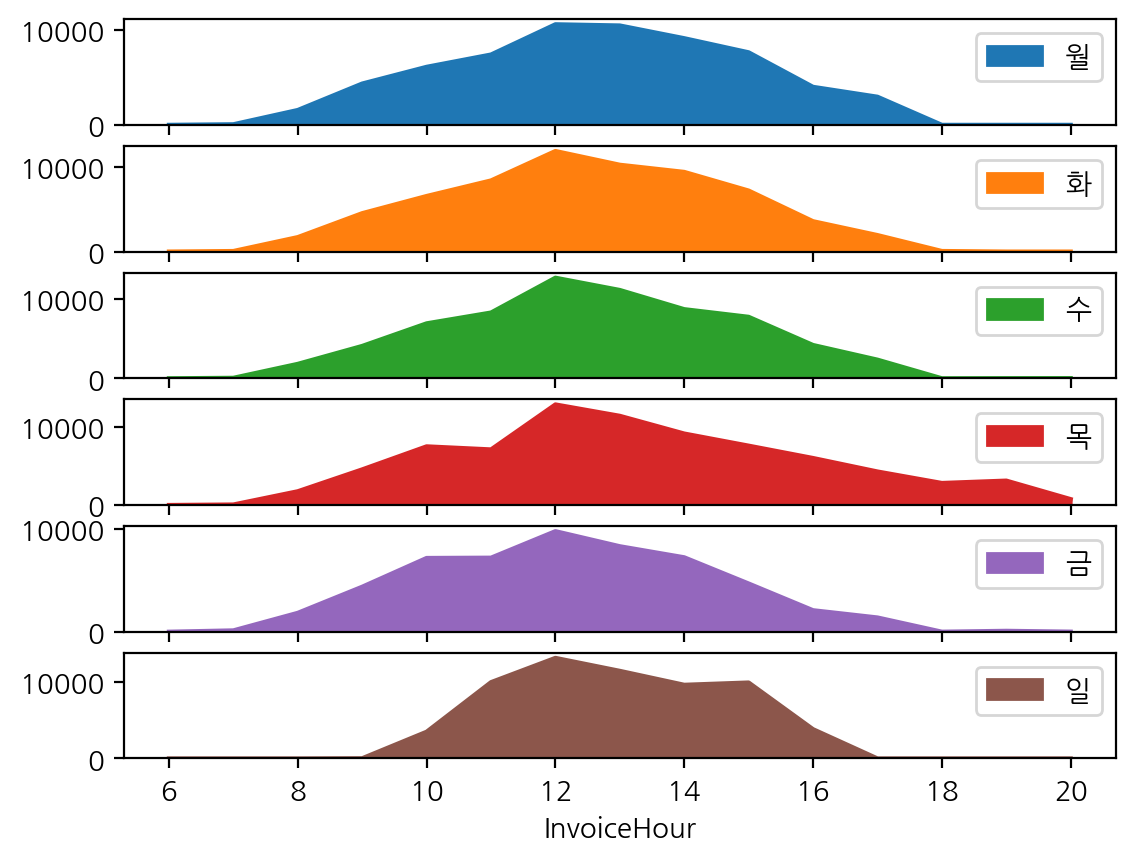

In [68]:
plt.figure(figsize=(12, 8))
hour_dow.plot(subplots=True, kind='area');

# 5. 지표 분석

## 5.1 ARPU&ARPPU 분석
- 가입한 서비스에 대해 가입자 1명이 특정 기간 동안 지출한 평균 금액
___
- ARPU(Average Revenue Per User) 
  - 매출/중복 을 제외한 순수 활동 사용자 수
- ARPPU(Average Revenue Per Paying User)
  - 지불 유저 1명 당 한 달에 결제하는 평균 금액을 산정한 수치

In [69]:
# ARPPU - CustomerID를 사용할때는 count가 아닌 nunique를 사용
# ARPPU
arppu = df_valid.groupby(['InvoiceYM']).agg({'TotalPrice':'sum', 'CustomerID': 'nunique'})

arppu['ARPPU'] = arppu['TotalPrice'] / arppu['CustomerID']
arppu

TotalPrice  CustomerID       ARPPU
InvoiceYM                                     
2010-12     570422.730         885  644.545458
2011-01     568101.310         741  766.668435
2011-02     446084.920         758  588.502533
2011-03     594081.760         974  609.940205
2011-04     468374.331         856  547.166275
2011-05     677355.150        1056  641.434801
2011-06     660046.050         991  666.040414
2011-07     598962.901         949  631.151634
2011-08     644051.040         935  688.824642
2011-09     950690.202        1266  750.940128
2011-10    1035642.450        1364  759.268658
2011-11    1156205.610        1664  694.835102
2011-12     517190.440         615  840.960065

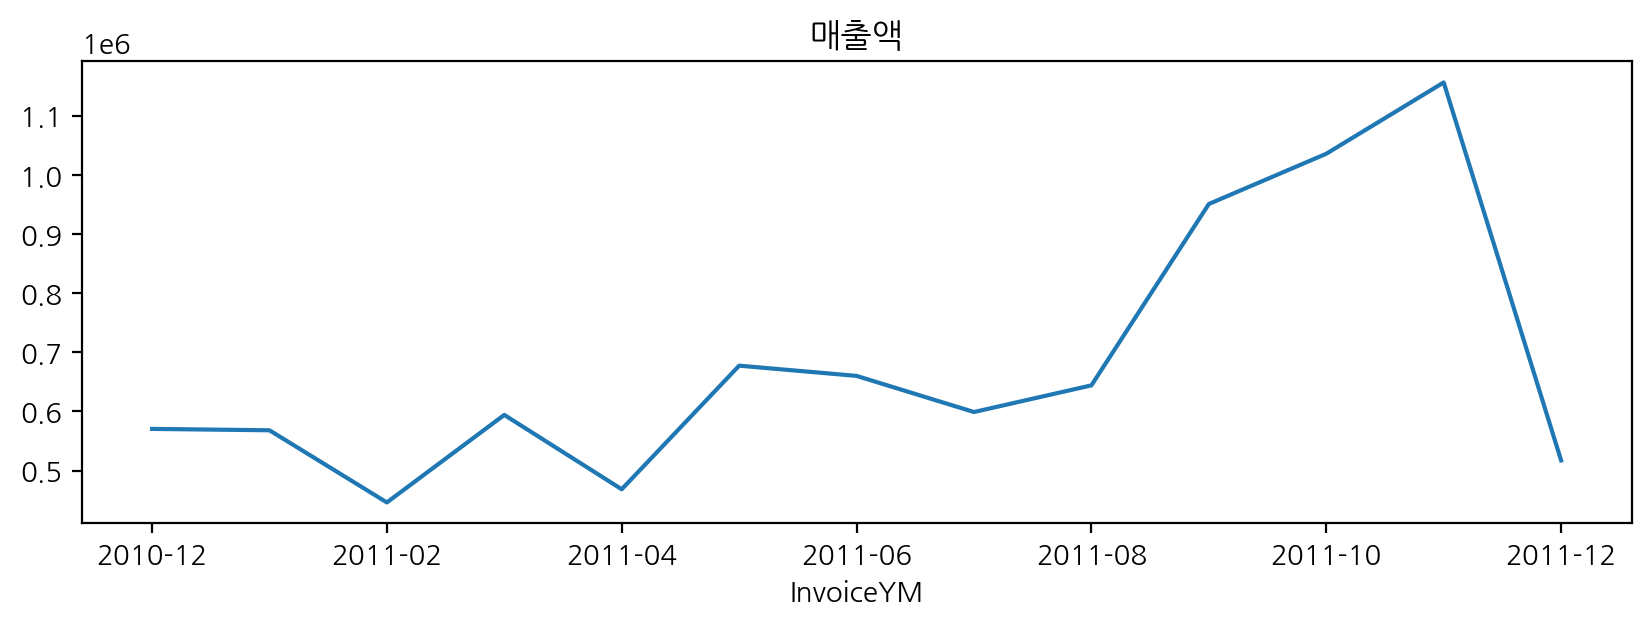

In [70]:
arppu['TotalPrice'].plot(figsize=(10, 3), title="매출액");

- 12월이 다 집계되지 않은 것 제외하고는 전체적으로 늘어나고 있는 추세

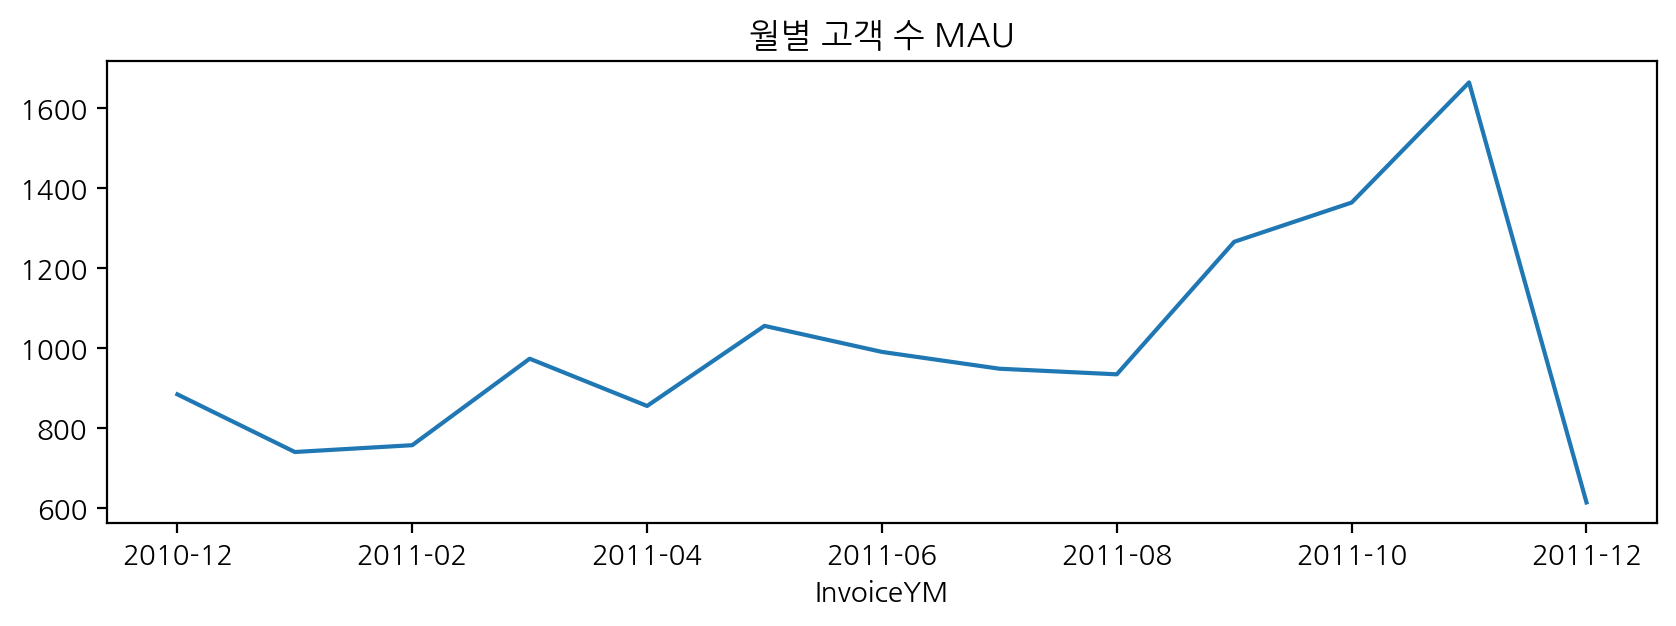

In [71]:
arppu['CustomerID'].plot(figsize=(10, 3), title="월별 고객 수 MAU");

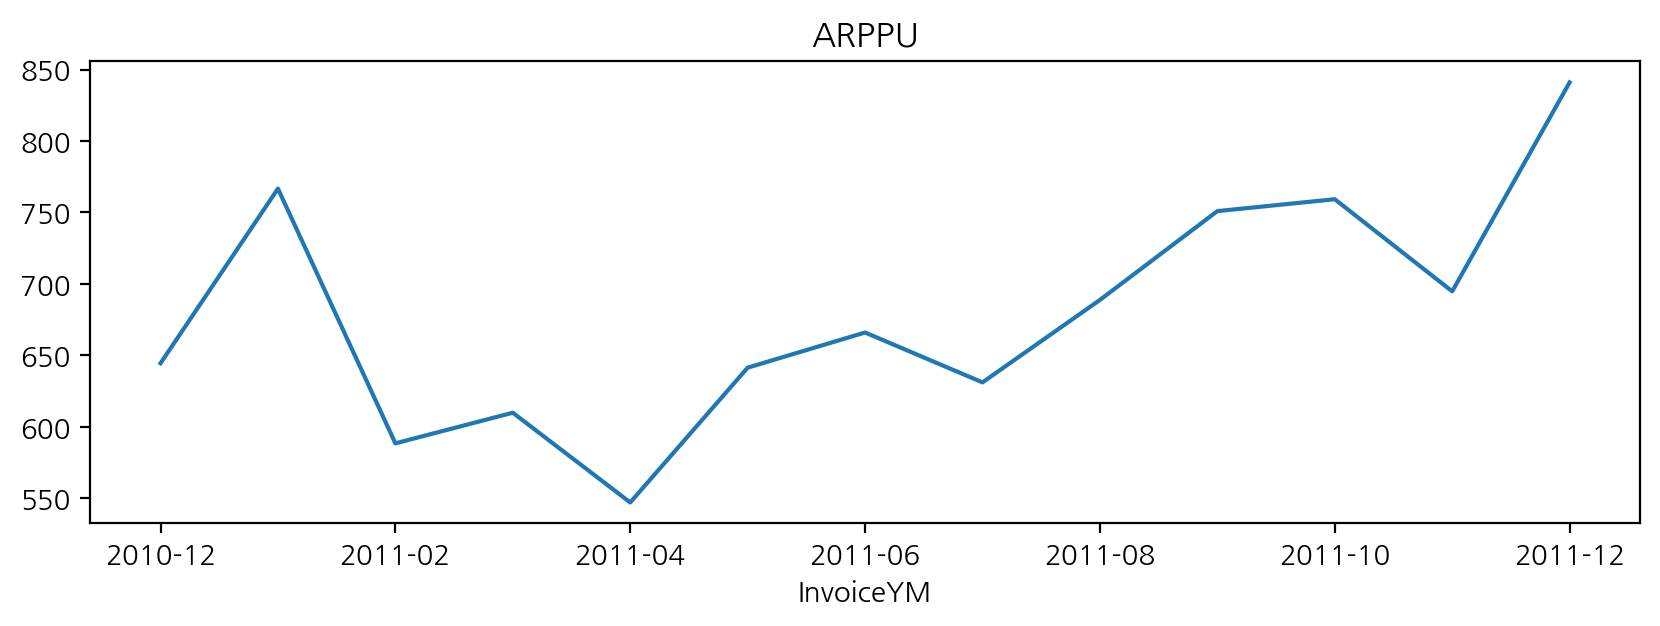

In [72]:
arppu['ARPPU'].plot(figsize=(10,3), title="ARPPU");

In [73]:
# df_valid(유효 고객, 유효 주문)내 고객별(CustomerID) 구매 (InvoiceNo) 빈도 수 구하기
# 고객별 구매 빈도수, 평균 구매 금액, 총 구매 금액
cust_agg = df_valid.groupby('CustomerID').agg({'InvoiceNo':'count', 'TotalPrice':['mean', 'sum']})
cust_agg

InvoiceNo    TotalPrice          
               count          mean       sum
CustomerID                                  
12346.0            1  77183.600000  77183.60
12347.0          182     23.681319   4310.00
12348.0           31     57.975484   1797.24
12349.0           73     24.076027   1757.55
12350.0           17     19.670588    334.40
...              ...           ...       ...
18280.0           10     18.060000    180.60
18281.0            7     11.545714     80.82
18282.0           12     14.837500    178.05
18283.0          721      2.837074   2045.53
18287.0           70     26.246857   1837.28

[4338 rows x 3 columns]

In [74]:
# CustomerID별 TotalPrice의 'count', 'mean'과 InvoiceNo의 'count' 구하기
# df_valid

In [75]:
# 고객별(CustomerID) 기술통계 값을 확인
cust_agg.describe()

InvoiceNo    TotalPrice               
             count          mean            sum
count  4338.000000   4338.000000    4338.000000
mean     90.523744     68.381590    2048.688081
std     225.506968   1467.918294    8985.230220
min       1.000000      2.136970       3.750000
25%      17.000000     12.393196     306.482500
50%      41.000000     17.755000     668.570000
75%      98.000000     24.878950    1660.597500
max    7676.000000  77183.600000  280206.020000

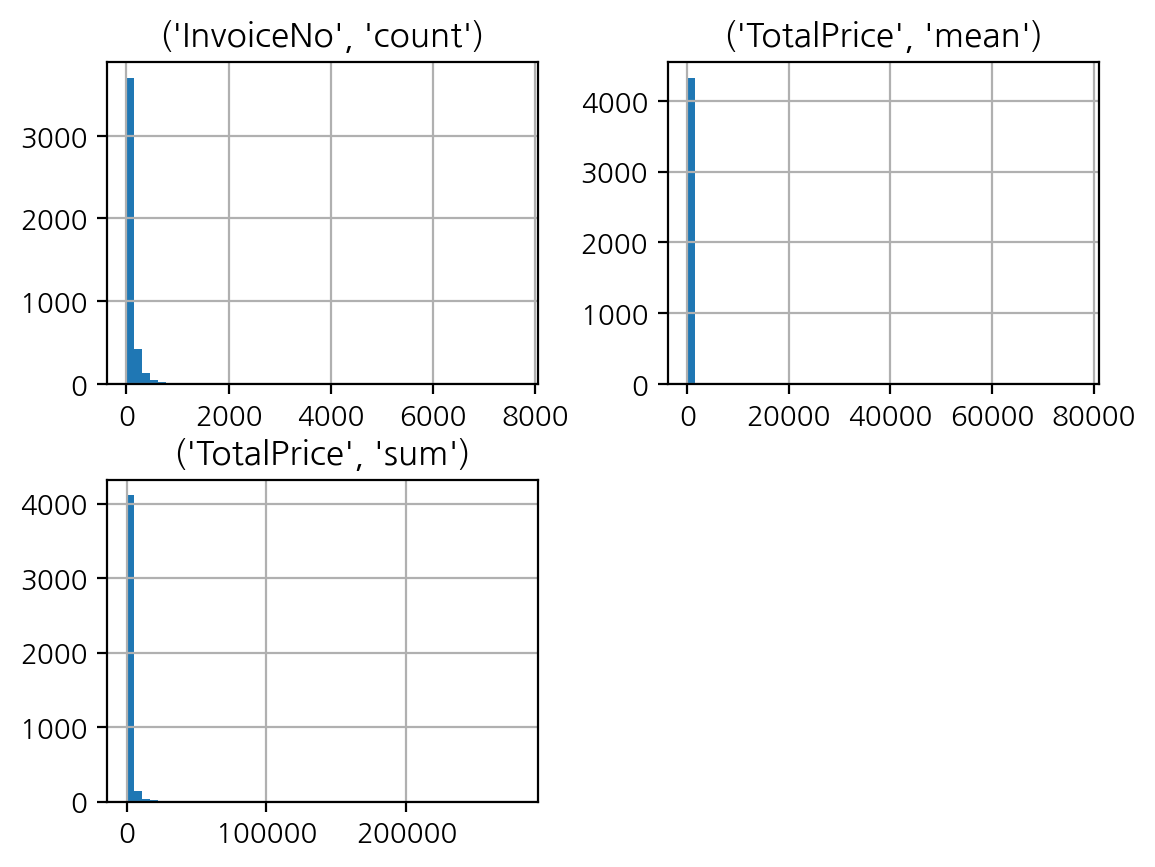

In [76]:
cust_agg.hist(bins=50);

- 이상치가 상당 부분 존재

## 5.2 MAU(Monthly Active User)

- 구매율, 로그인 비율 등 서비스에 따라 달라질 수 있음

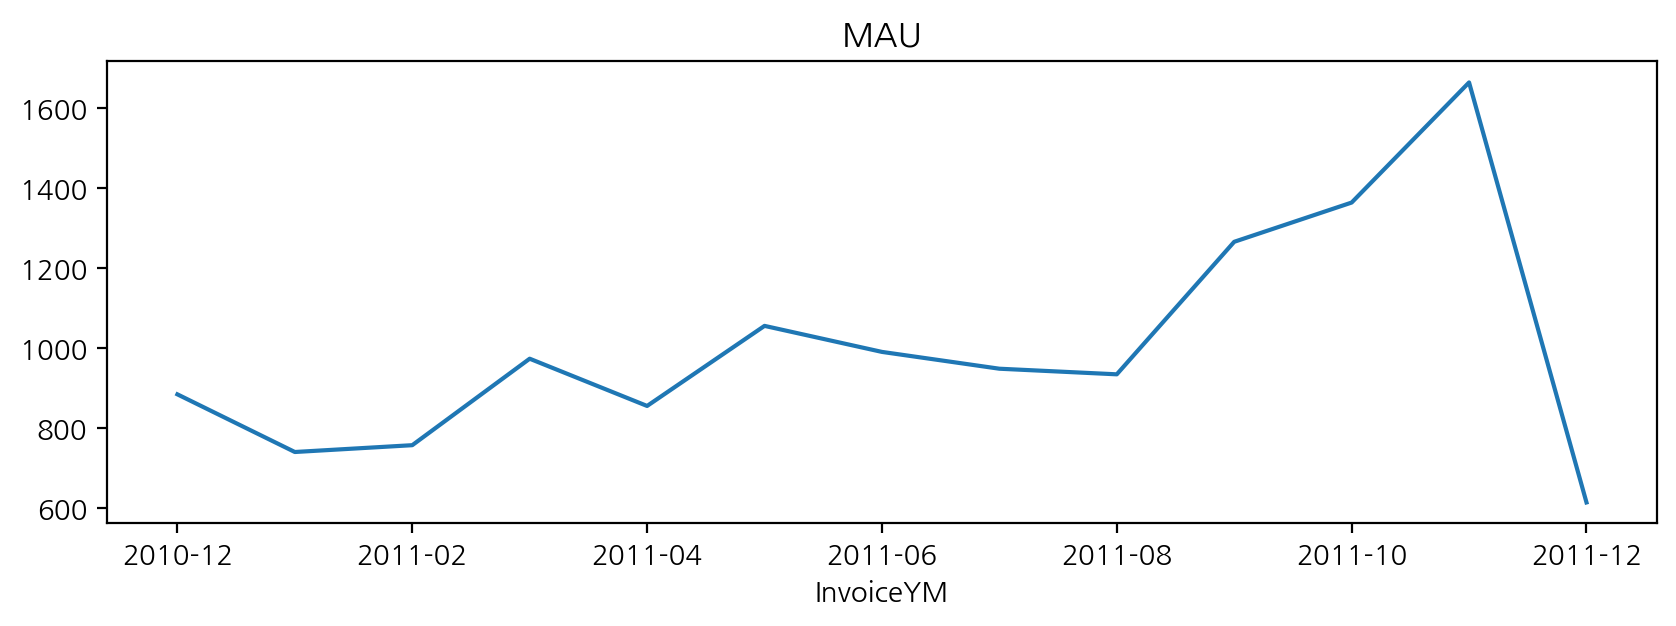

In [77]:
# InvoiceYM으로 그룹화하여 CustomerID의 유일값 개수 구하기
MAU = df_valid.groupby('InvoiceYM')['CustomerID'].nunique()
MAU.plot(figsize=(10, 3), title="MAU");

### 💰 월별 주문건, 중복을 제외한 주문 제품 종류 수, 고객 수, 총 주문금액

In [78]:
df_valid.groupby('InvoiceYM').agg({'InvoiceNo' : 'count', 'StockCode':'nunique', 'CustomerID':'nunique', 'UnitPrice':'mean', 'Quantity':'sum', 'TotalPrice':'sum'})

InvoiceNo  StockCode  CustomerID  UnitPrice  Quantity   TotalPrice
InvoiceYM                                                                    
2010-12        25670       2411         885   3.142953    311048   570422.730
2011-01        20988       2121         741   3.155834    348473   568101.310
2011-02        19706       2124         758   3.177686    265027   446084.920
2011-03        26870       2234         974   3.269996    347582   594081.760
2011-04        22433       2217         856   3.501247    291366   468374.331
2011-05        28073       2219        1056   3.615606    372864   677355.150
2011-06        26926       2339         991   3.142043    363014   660046.050
2011-07        26580       2351         949   2.838771    367360   598962.901
2011-08        26790       2356         935   2.944274    397373   644051.040
2011-09        39669       2545        1266   2.978656    543652   950690.202
2011-10        48793       2622        1364   3.362861    591543  1035642.450
2011-11        63168       2695        1664   2.886590    665923  1156205.610
2011-12        17026       2173         615   2.734624    286777   517190.440

## 5.3 코호트 분석

### ⚒️ 월단위 데이터 전처리(리텐션을 구하기 위한)

In [79]:
# 최근 구매일 - 최초 구매일
# 첫 구매 후 몇달 후 구매인지 알 수 있음
# 최초 구매일(InvoiceDateFirst) 구하기
df_valid['InvoiceDateFirst'] = df_valid.groupby(['CustomerID'])['InvoiceDate'].transform('min')

In [80]:
df_valid[['CustomerID', 'InvoiceDate', 'InvoiceDateFirst']].sample(5)

CustomerID         InvoiceDate    InvoiceDateFirst
314275     13644.0 2011-08-26 11:53:00 2011-08-26 11:53:00
196522     16813.0 2011-05-19 13:28:00 2011-05-19 13:28:00
241145     16029.0 2011-06-27 12:23:00 2010-12-01 09:57:00
192701     16218.0 2011-05-17 11:07:00 2010-12-01 11:29:00
321434     14298.0 2011-09-01 14:26:00 2010-12-14 12:59:00

**[첫 구매일로부터 몇 달째 구매인가?]**

In [81]:
# 연도별 차이(year_diff)와 월별 차이(month_diff) 구하기
# year_diff
year_diff = df_valid['InvoiceDate'].dt.year - df_valid['InvoiceDateFirst'].dt.year
month_diff = df_valid['InvoiceDate'].dt.month - df_valid['InvoiceDateFirst'].dt.month

In [82]:
year_diff.value_counts()

0    251153
1    141539
Name: count, dtype: int64

In [83]:
# 연도 차이 * 12개월 + 월 차이 + 1 로 첫 구매 후 몇 달 후 구매인지 알 수 있도록 Cohort Index 변수 생성
# 2010-12-01부터 2011-12-01의 데이터를 기반으로 진행되어 CohortIndex 변수의 최소값은 1이며, 최대값은 13
# df_valid['CohortIndex']
df_valid['CohortIndex'] = (year_diff * 12) + month_diff + 1

### 📅 코호트 월별 빈도 수

In [84]:
# CohortIndex 값으로 월별 잔존 구매에 대한 빈도 수 구하기
# 회원가입 후 월별 구매 빈도 수를 value_counts로 구하기
df_valid['CohortIndex'].value_counts()

CohortIndex
1     116857
2      27516
4      26993
3      26727
6      26673
5      25165
7      23462
8      23298
12     23011
10     22968
9      22751
11     20098
13      7173
Name: count, dtype: int64

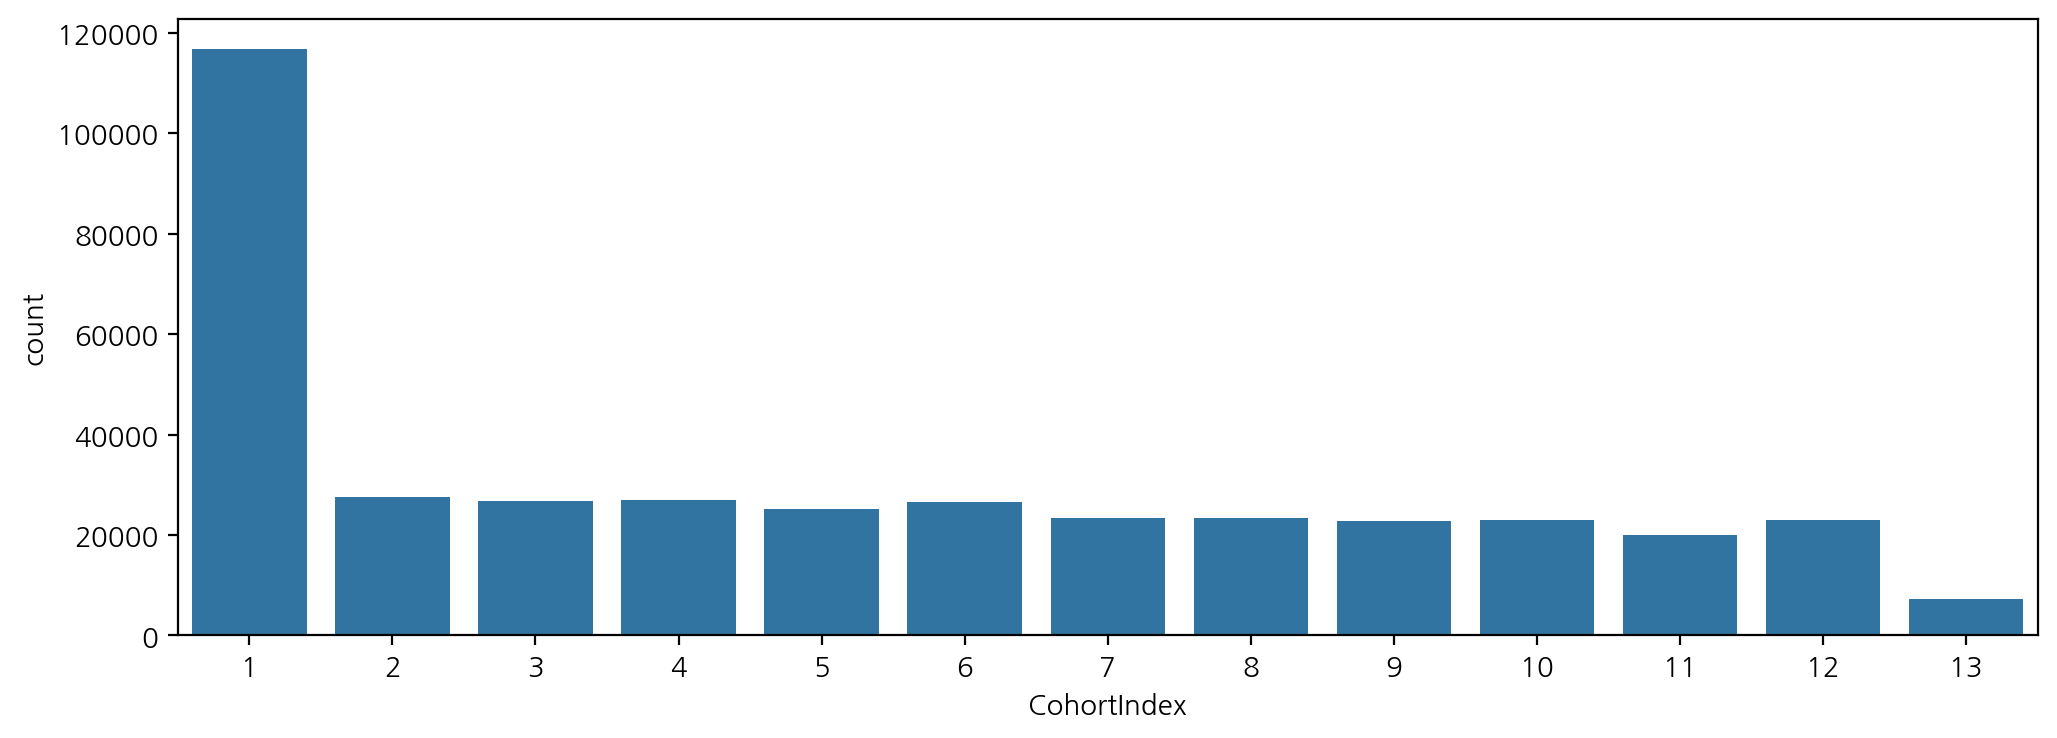

In [85]:
# countplot으로 CohortIndex의 빈도 수 시각화
plt.figure(figsize=(12,4))
sns.countplot(data=df_valid, x='CohortIndex');

- 다음달부터 급격히 줄어듬

### 🐒 잔존 빈도 구하기

In [86]:
df_valid['InvoiceDateFirstYM'] = df_valid['InvoiceDateFirst'].astype(str).str[:7]

In [87]:
# InvoiceDateFirst, CohortIndex로 그룹화하여 CustomerID의 유일값에 대한 빈도 수 구하기
# cohort_count
cohort_count = df_valid.groupby(['InvoiceDateFirstYM','CohortIndex'])['CustomerID'].nunique().unstack()
cohort_count

CohortIndex            1      2      3      4      5      6      7      8   \
InvoiceDateFirstYM                                                           
2010-12             885.0  324.0  286.0  340.0  321.0  352.0  321.0  309.0   
2011-01             417.0   92.0  111.0   96.0  134.0  120.0  103.0  101.0   
2011-02             380.0   71.0   71.0  108.0  103.0   94.0   96.0  106.0   
2011-03             452.0   68.0  114.0   90.0  101.0   76.0  121.0  104.0   
2011-04             300.0   64.0   61.0   63.0   59.0   68.0   65.0   78.0   
2011-05             284.0   54.0   49.0   49.0   59.0   66.0   75.0   27.0   
2011-06             242.0   42.0   38.0   64.0   56.0   81.0   23.0    NaN   
2011-07             188.0   34.0   39.0   42.0   51.0   21.0    NaN    NaN   
2011-08             169.0   35.0   42.0   41.0   21.0    NaN    NaN    NaN   
2011-09             299.0   70.0   90.0   34.0    NaN    NaN    NaN    NaN   
2011-10             358.0   86.0   41.0    NaN    NaN    NaN    NaN    NaN   
2011-11             323.0   36.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12              41.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex            9      10     11     12     13  
InvoiceDateFirstYM                                     
2010-12             313.0  350.0  331.0  445.0  235.0  
2011-01             125.0  136.0  152.0   49.0    NaN  
2011-02              94.0  116.0   26.0    NaN    NaN  
2011-03             126.0   39.0    NaN    NaN    NaN  
2011-04              22.0    NaN    NaN    NaN    NaN  
2011-05               NaN    NaN    NaN    NaN    NaN  
2011-06               NaN    NaN    NaN    NaN    NaN  
2011-07               NaN    NaN    NaN    NaN    NaN  
2011-08               NaN    NaN    NaN    NaN    NaN  
2011-09               NaN    NaN    NaN    NaN    NaN  
2011-10               NaN    NaN    NaN    NaN    NaN  
2011-11               NaN    NaN    NaN    NaN    NaN  
2011-12               NaN    NaN    NaN    NaN    NaN

<Axes: xlabel='CohortIndex', ylabel='InvoiceDateFirstYM'>

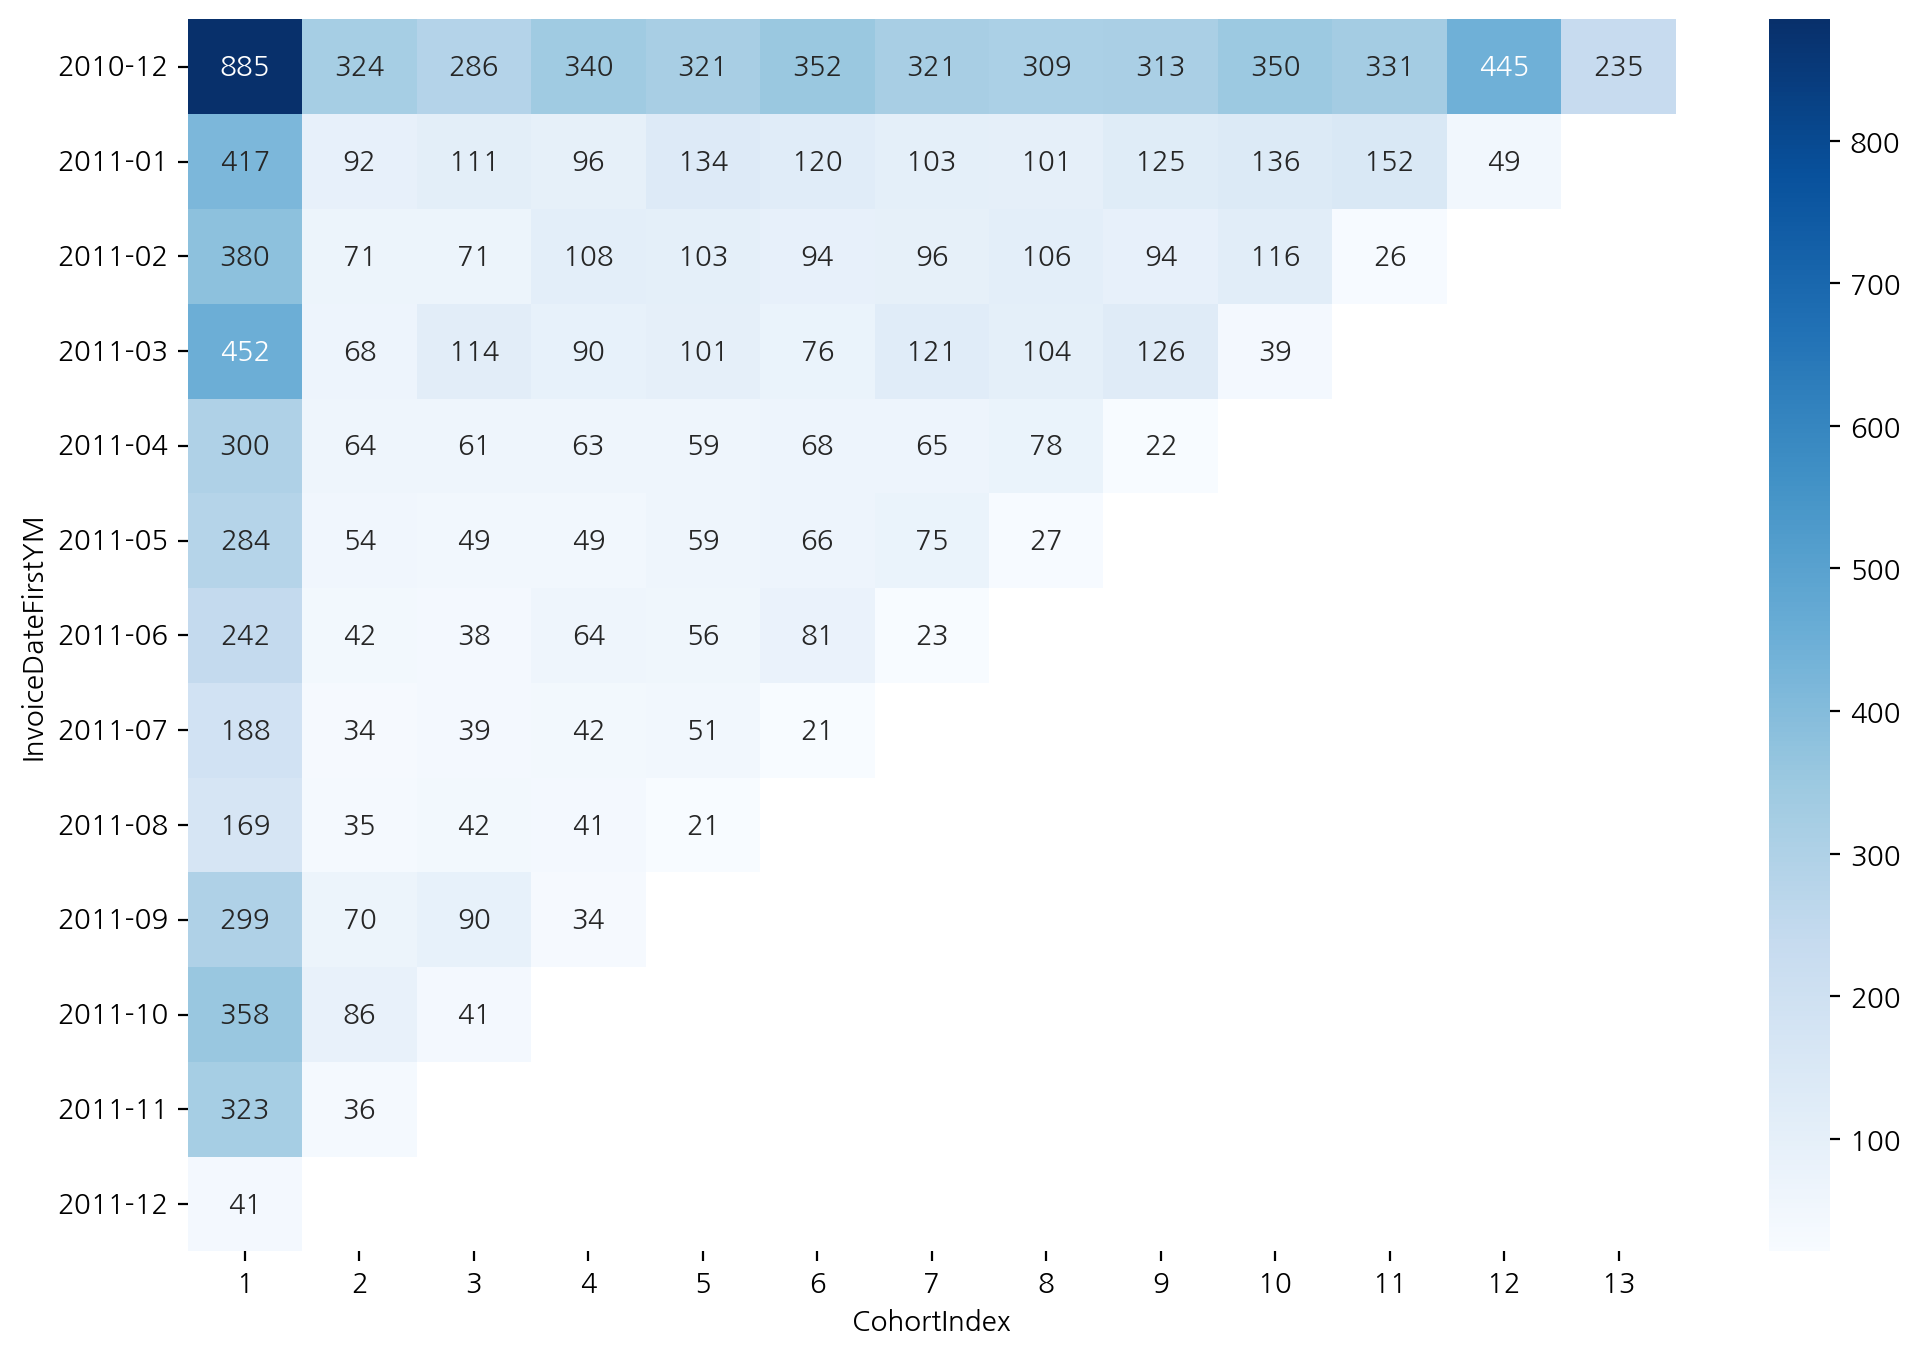

In [88]:
# heatmap을 통해 잔존수 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_count, cmap='Blues', annot=True, fmt='.0f')

### 🚶🏻‍♀️ 월별 신규 유입 고객 수
- Acquisition(취득)

In [89]:
cohort_count[1]

InvoiceDateFirstYM
2010-12    885.0
2011-01    417.0
2011-02    380.0
2011-03    452.0
2011-04    300.0
2011-05    284.0
2011-06    242.0
2011-07    188.0
2011-08    169.0
2011-09    299.0
2011-10    358.0
2011-11    323.0
2011-12     41.0
Name: 1, dtype: float64

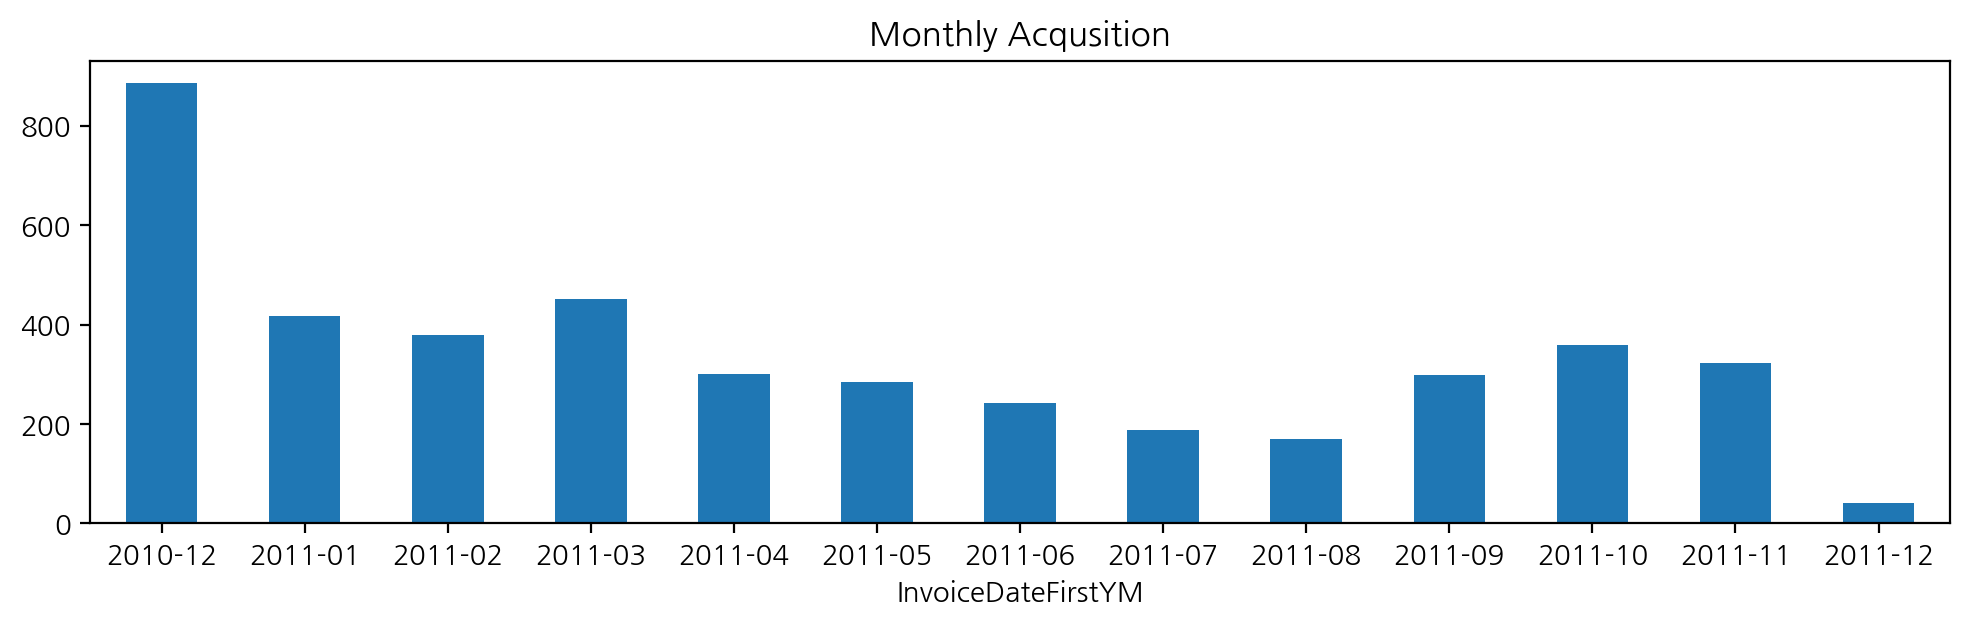

In [ ]:
cohort_count[1].plot(kind='bar', figsize=(12, 3), rot=0, title="Monthly Acquisition");

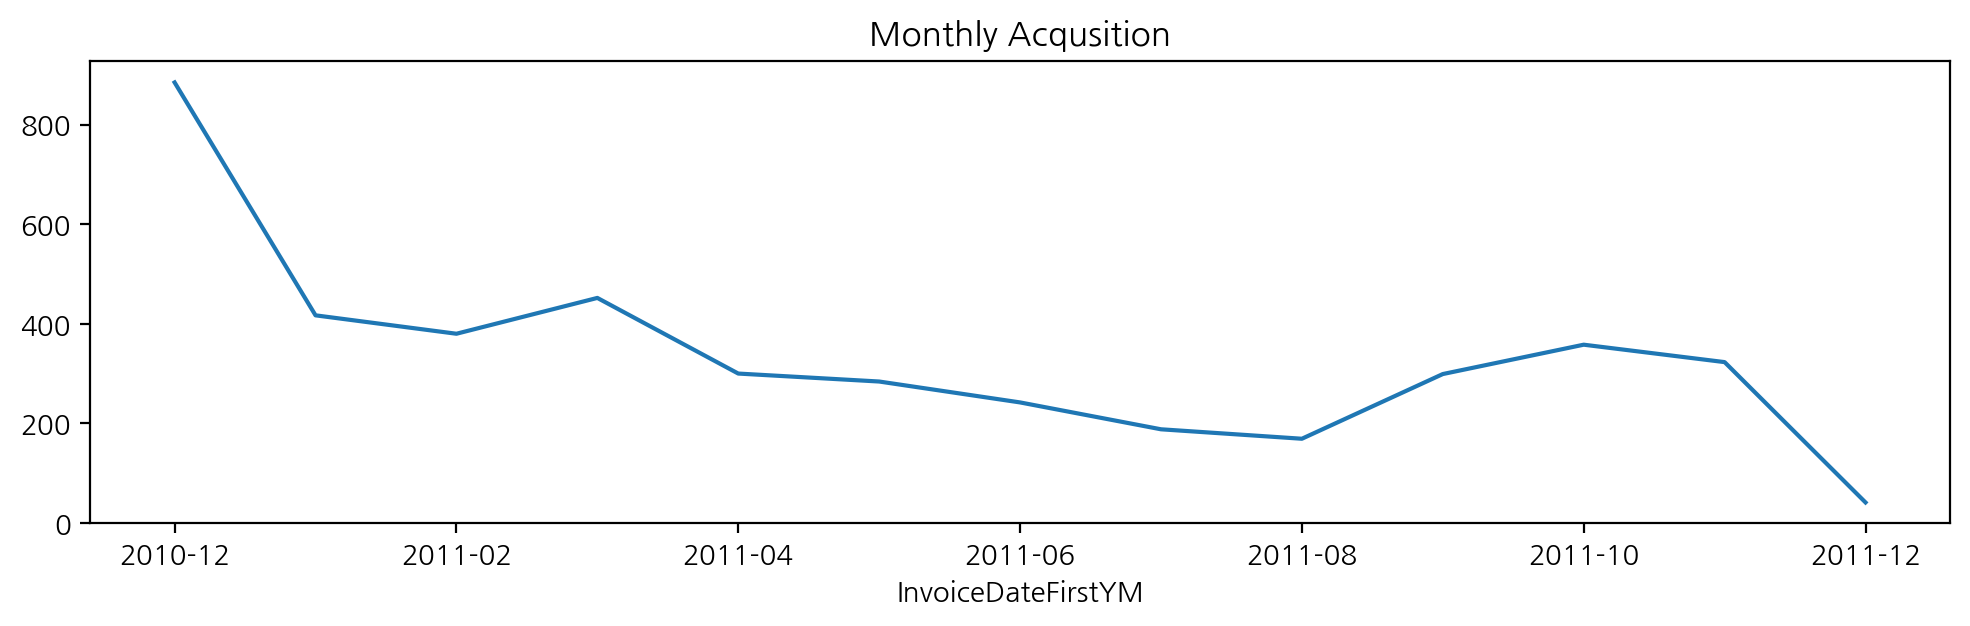

In [91]:
cohort_count[1].plot(figsize=(12, 3), rot=0, title="Monthly Acqusition");

### 🪑 잔존율 구하기

In [92]:
# 가입한 달을 1로 나누면 잔존률을 구할 수 있음
# div를 통해 구하며 axis=0으로 설정하면 첫 달을 기준으로 나머지 달을 나누게 됨
# cohort_norm
cohort_norm = cohort_count.div(cohort_count[1], axis=0)
cohort_norm

CohortIndex          1         2         3         4         5         6   \
InvoiceDateFirstYM                                                          
2010-12             1.0  0.366102  0.323164  0.384181  0.362712  0.397740   
2011-01             1.0  0.220624  0.266187  0.230216  0.321343  0.287770   
2011-02             1.0  0.186842  0.186842  0.284211  0.271053  0.247368   
2011-03             1.0  0.150442  0.252212  0.199115  0.223451  0.168142   
2011-04             1.0  0.213333  0.203333  0.210000  0.196667  0.226667   
2011-05             1.0  0.190141  0.172535  0.172535  0.207746  0.232394   
2011-06             1.0  0.173554  0.157025  0.264463  0.231405  0.334711   
2011-07             1.0  0.180851  0.207447  0.223404  0.271277  0.111702   
2011-08             1.0  0.207101  0.248521  0.242604  0.124260       NaN   
2011-09             1.0  0.234114  0.301003  0.113712       NaN       NaN   
2011-10             1.0  0.240223  0.114525       NaN       NaN       NaN   
2011-11             1.0  0.111455       NaN       NaN       NaN       NaN   
2011-12             1.0       NaN       NaN       NaN       NaN       NaN   

CohortIndex               7         8         9         10        11  \
InvoiceDateFirstYM                                                     
2010-12             0.362712  0.349153  0.353672  0.395480  0.374011   
2011-01             0.247002  0.242206  0.299760  0.326139  0.364508   
2011-02             0.252632  0.278947  0.247368  0.305263  0.068421   
2011-03             0.267699  0.230088  0.278761  0.086283       NaN   
2011-04             0.216667  0.260000  0.073333       NaN       NaN   
2011-05             0.264085  0.095070       NaN       NaN       NaN   
2011-06             0.095041       NaN       NaN       NaN       NaN   
2011-07                  NaN       NaN       NaN       NaN       NaN   
2011-08                  NaN       NaN       NaN       NaN       NaN   
2011-09                  NaN       NaN       NaN       NaN       NaN   
2011-10                  NaN       NaN       NaN       NaN       NaN   
2011-11                  NaN       NaN       NaN       NaN       NaN   
2011-12                  NaN       NaN       NaN       NaN       NaN   

CohortIndex               12        13  
InvoiceDateFirstYM                      
2010-12             0.502825  0.265537  
2011-01             0.117506       NaN  
2011-02                  NaN       NaN  
2011-03                  NaN       NaN  
2011-04                  NaN       NaN  
2011-05                  NaN       NaN  
2011-06                  NaN       NaN  
2011-07                  NaN       NaN  
2011-08                  NaN       NaN  
2011-09                  NaN       NaN  
2011-10                  NaN       NaN  
2011-11                  NaN       NaN  
2011-12                  NaN       NaN

<Axes: xlabel='CohortIndex', ylabel='InvoiceDateFirstYM'>

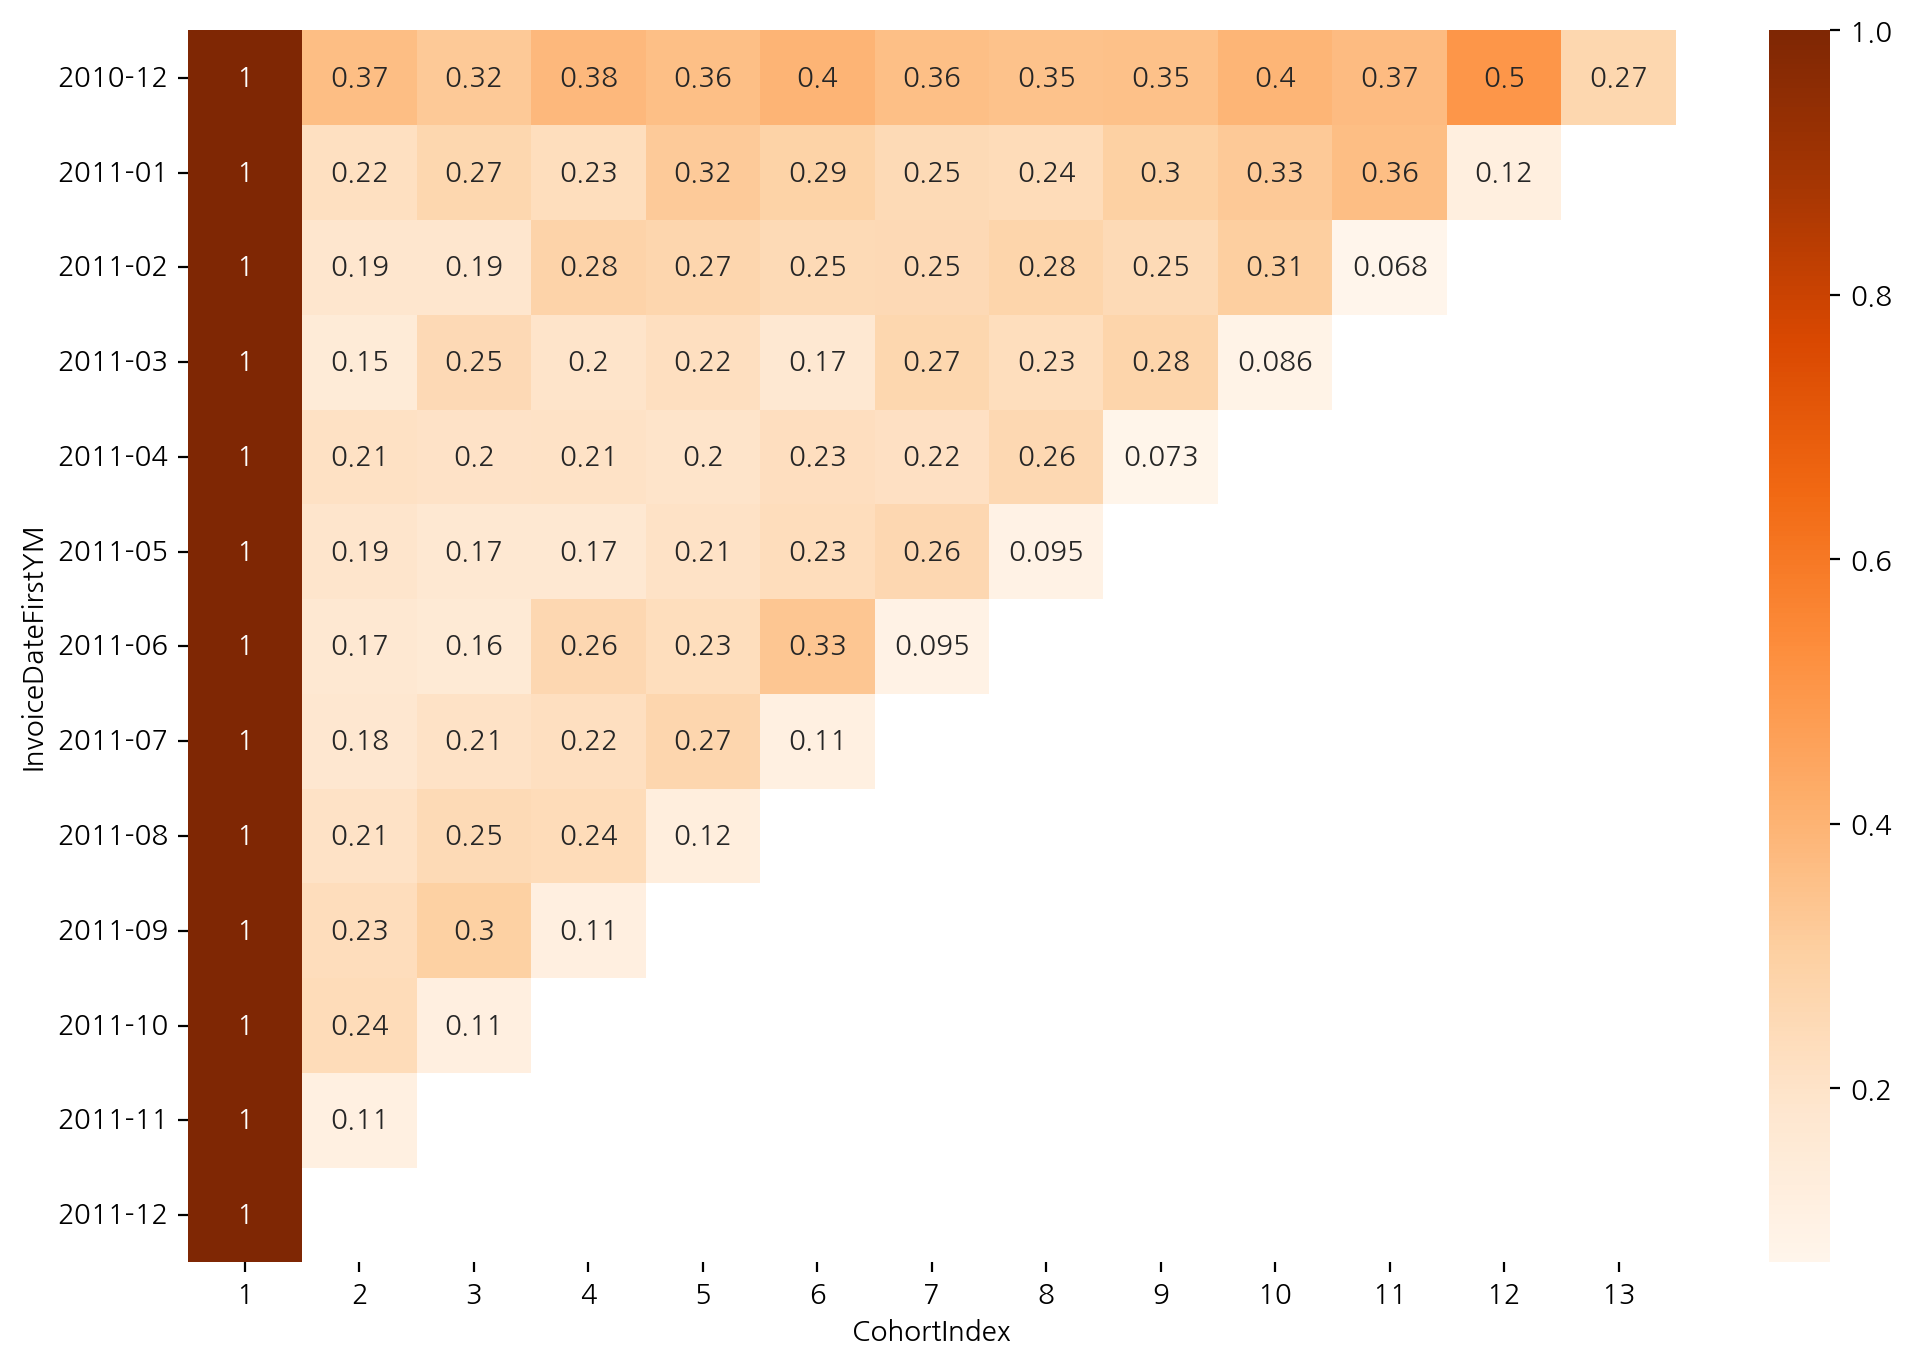

In [93]:
# heatmap을 통해 잔존율 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_norm, cmap='Oranges', annot=True)

### 💵 월별 매출액 리텐션

In [94]:
df_valid.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

   isRegistered  ... InvoiceMonth  InvoiceDay  InvoiceDow  InvoiceYM  \
0          True  ...           12           1           2    2010-12   
1          True  ...           12           1           2    2010-12   
2          True  ...           12           1           2    2010-12   
3          True  ...           12           1           2    2010-12   
4          True  ...           12           1           2    2010-12   

   InvoiceTime  InvoiceHour InvoiceDayName    InvoiceDateFirst  CohortIndex  \
0     08:26:00            8              수 2010-12-01 08:26:00            1   
1     08:26:00            8              수 2010-12-01 08:26:00            1   
2     08:26:00            8              수 2010-12-01 08:26:00            1   
3     08:26:00            8              수 2010-12-01 08:26:00            1   
4     08:26:00            8              수 2010-12-01 08:26:00            1   

  InvoiceDateFirstYM  
0            2010-12  
1            2010-12  
2            2010-12  
3            2010-12  
4            2010-12  

[5 rows x 23 columns]

In [95]:
cohort_total_price = df_valid.groupby(['InvoiceDateFirstYM', 'CohortIndex'])['TotalPrice'].sum().unstack()
cohort_total_price

CohortIndex                 1          2          3          4          5   \
InvoiceDateFirstYM                                                           
2010-12             570422.730  275734.47  233390.47  302367.44  204034.38   
2011-01             292366.840   54993.86   63157.01   71526.09   80989.77   
2011-02             157700.590   28937.64   40964.47   48155.39   40089.17   
2011-03             199619.670   30040.34   58958.41   42739.08   51392.44   
2011-04             121809.051   29398.59   25028.57   24282.79   26253.16   
2011-05             123739.300   18641.70   20155.73   19162.17   27752.62   
2011-06             135414.800   14738.49   14104.37   30898.56   26669.90   
2011-07              73860.401   11789.67   15488.37   17391.93   19156.82   
2011-08              79601.140   20933.76   35458.48   44487.65   15284.36   
2011-09             154734.091   28701.15   36898.95   12299.53        NaN   
2011-10             173425.190   39691.40   12567.28        NaN        NaN   
2011-11             135131.330   15223.34        NaN        NaN        NaN   
2011-12              27005.460        NaN        NaN        NaN        NaN   

CohortIndex                6          7          8           9          10  \
InvoiceDateFirstYM                                                           
2010-12             336113.69  313668.16  310304.03  331001.070  471792.13   
2011-01              84464.57   70073.35   72503.42   71870.481  111370.70   
2011-02              34155.67   49673.71   62292.80   55241.340   64688.86   
2011-03              39962.33   64824.15   70523.62   70847.620   12761.10   
2011-04              30103.24   28505.90   34009.61    6332.000        NaN   
2011-05              32875.34   33168.34  179184.23         NaN        NaN   
2011-06              42531.09    8143.22        NaN         NaN        NaN   
2011-07               6040.70        NaN        NaN         NaN        NaN   
2011-08                   NaN        NaN        NaN         NaN        NaN   
2011-09                   NaN        NaN        NaN         NaN        NaN   
2011-10                   NaN        NaN        NaN         NaN        NaN   
2011-11                   NaN        NaN        NaN         NaN        NaN   
2011-12                   NaN        NaN        NaN         NaN        NaN   

CohortIndex                11         12         13  
InvoiceDateFirstYM                                   
2010-12             455478.90  512341.08  185360.97  
2011-01             123252.86   26388.03        NaN  
2011-02              10600.22        NaN        NaN  
2011-03                   NaN        NaN        NaN  
2011-04                   NaN        NaN        NaN  
2011-05                   NaN        NaN        NaN  
2011-06                   NaN        NaN        NaN  
2011-07                   NaN        NaN        NaN  
2011-08                   NaN        NaN        NaN  
2011-09                   NaN        NaN        NaN  
2011-10                   NaN        NaN        NaN  
2011-11                   NaN        NaN        NaN  
2011-12                   NaN        NaN        NaN

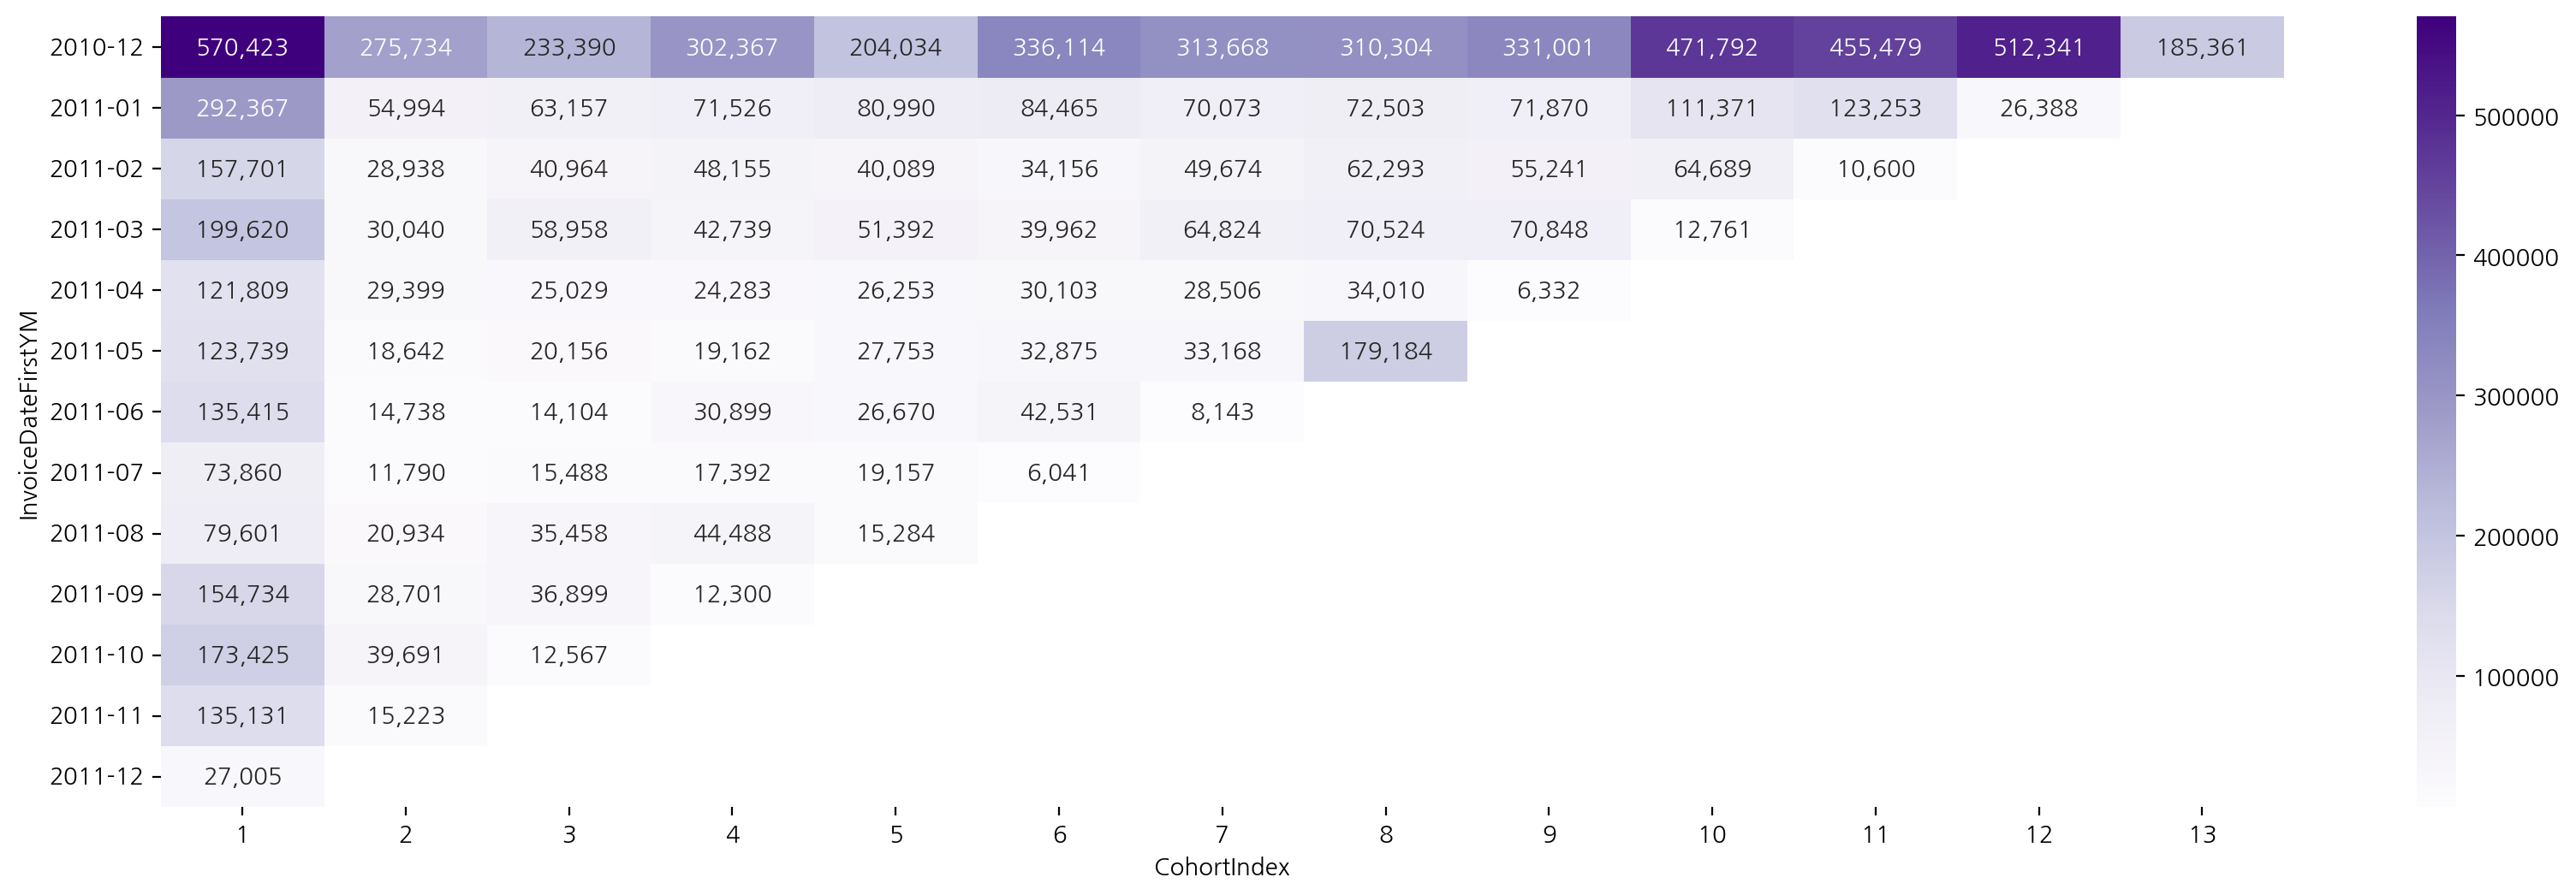

In [96]:
plt.figure(figsize=(20, 6))
sns.heatmap(cohort_total_price, cmap='Purples', annot=True, fmt=',.0f');

- 첫번째 달의 고객들이 지속적으로 꽤 많은 매출액을 내고 있음
- 고객이 얼마나 많이 남아있는가, 얼마나 많은 매출을 내주고 있는가 분석해보면 좋음

## 5.4 RFM 모형

**📋 관련 개념**
- 매출의 법칙
  - 파레토(Pareto)
    - 상위 20%의 고객이 80%의 매출 책임짐
  - 롱테일(The Long Tail)
    - 나머지 80% 고객에게 집중하면 더 많은 매출을 낼 수 있다.
- RFM
  - 가치있는 고객을 추출해 이를 기준으로 고객을 분류할 수 있는 간단하면서도 유용한 방법
  - 구매 가능성이 높은 고객을 선정하기 위한 데이터 분석 방법
- Recency
  - 거래의 최근성
    - 고객이 얼마나 최근에 구입했는가
- Frequency
  - 거래 빈도
    - 고객이 얼마나 빈번하게 우리 상품을 구입했나
- Monetary
  - 거래 규모
    - 고객이 구입했던 총 금액은 어느 정도인가
___
&rArr;
- 최근에 구매한 고객일수록 회사의 마케팅 홍보에 반응을 보일 가능성이 큼
- 자주 구매하는 고객이 그렇지 않은 고객보다 반응할 가능성이 큼
- 많은 금액을 소비한 고객이 다시 구매할 가능성이 더 높음
___
&rArr;
- R(H)/F(H)/M(H)
  - 우수 고객으로 차별화된 서비스 제공
  - 본사 차원의 고급정보 및 차별화된 오퍼링 제공
- R(L)/F(H)/M(H)
  - 구매 제품 종류 및 제품 수명 주기 고려
  - 모델 전환 유도를 위한 캠페인, 이벤트 전략 등
- R(H)/F(L)/M(H)
  - 제품 연관성 분석을 통한 구매확률이 높은 제품 추천 캠페인 전략 등
- R(H)/F(H)/M(L)
  - 구매 금액을 증가시키기 위한 마케팅 활동 실시
  - 고가 제품 구매 시 프리미엄 제공 캠페인 전략 등

In [97]:
# 기술통계량 보기
df_valid.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  392692.000000                         392692  392692.000000   
mean       13.119702  2011-07-10 19:13:07.771892480       3.125914   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 12:02:00       1.950000   
75%        12.000000            2011-10-20 12:53:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       180.492832                            NaN      22.241836   

          CustomerID     TotalPrice    InvoiceYear   InvoiceMonth  \
count  392692.000000  392692.000000  392692.000000  392692.000000   
mean    15287.843750      22.631500    2010.934631       7.601871   
min     12346.000000       0.001000    2010.000000       1.000000   
25%     13955.000000       4.950000    2011.000000       5.000000   
50%     15150.000000      12.450000    2011.000000       8.000000   
75%     16791.000000      19.800000    2011.000000      11.000000   
max     18287.000000  168469.600000    2011.000000      12.000000   
std      1713.539551     311.099224       0.247177       3.415015   

          InvoiceDay     InvoiceDow    InvoiceHour  \
count  392692.000000  392692.000000  392692.000000   
mean       15.044656       2.606911      12.721532   
min         1.000000       0.000000       6.000000   
25%         7.000000       1.000000      11.000000   
50%        15.000000       2.000000      13.000000   
75%        22.000000       4.000000      14.000000   
max        31.000000       6.000000      20.000000   
std         8.652532       1.923929       2.276661   

                    InvoiceDateFirst    CohortIndex  
count                         392692  392692.000000  
mean   2011-03-03 16:09:46.786743552       5.147599  
min              2010-12-01 08:26:00       1.000000  
25%              2010-12-08 10:36:00       1.000000  
50%              2011-01-19 14:50:00       4.000000  
75%              2011-04-20 13:36:00       8.000000  
max              2011-12-09 12:16:00      13.000000  
std                              NaN       3.850198

### ⚠️ 이상치 처리

In [98]:
# 이상치 찾기
# 160000보다 큰 값 찾기
df_valid[df_valid['TotalPrice'] > 160000]

InvoiceNo StockCode                  Description  Quantity  \
540421    581483     23843  PAPER CRAFT , LITTLE BIRDIE     80995   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
540421 2011-12-09 09:15:00       2.08     16446.0  United Kingdom    168469.6   

        isRegistered  ... InvoiceMonth  InvoiceDay  InvoiceDow  InvoiceYM  \
540421          True  ...           12           9           4    2011-12   

        InvoiceTime  InvoiceHour InvoiceDayName    InvoiceDateFirst  \
540421     09:15:00            9              금 2011-05-18 09:52:00   

        CohortIndex InvoiceDateFirstYM  
540421            8            2011-05  

[1 rows x 23 columns]

In [99]:
df_valid[df_valid['CustomerID'] == 16446]

InvoiceNo StockCode                  Description  Quantity  \
194354    553573     22980       PANTRY SCRUBBING BRUSH         1   
194355    553573     22982          PANTRY PASTRY BRUSH         1   
540421    581483     23843  PAPER CRAFT , LITTLE BIRDIE     80995   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
194354 2011-05-18 09:52:00       1.65     16446.0  United Kingdom        1.65   
194355 2011-05-18 09:52:00       1.25     16446.0  United Kingdom        1.25   
540421 2011-12-09 09:15:00       2.08     16446.0  United Kingdom   168469.60   

        isRegistered  ... InvoiceMonth  InvoiceDay  InvoiceDow  InvoiceYM  \
194354          True  ...            5          18           2    2011-05   
194355          True  ...            5          18           2    2011-05   
540421          True  ...           12           9           4    2011-12   

        InvoiceTime  InvoiceHour InvoiceDayName    InvoiceDateFirst  \
194354     09:52:00            9              수 2011-05-18 09:52:00   
194355     09:52:00            9              수 2011-05-18 09:52:00   
540421     09:15:00            9              금 2011-05-18 09:52:00   

        CohortIndex InvoiceDateFirstYM  
194354            1            2011-05  
194355            1            2011-05  
540421            8            2011-05  

[3 rows x 23 columns]

In [100]:
# 이상치 제외
# 160000보다 큰 값 제외
df_valid = df_valid[df_valid['TotalPrice']<160000].copy()
df_valid.shape

(392691, 23)

### 👯‍♂️ 중복값 처리
- 중복 데이터는 여러 이유로 발생할 수 있음
  - 네트워크 통신 문제
  - 쇼핑몰 UI 구성
  - 예시
    - 주문을 하고 새로고침을 했을 때 다시 주문 트랜잭션에 들어가는 이슈

**[중복 데이터 확인]**

In [101]:
# 중복 데이터 모두 출력(keep=False)
df_valid[df_valid.duplicated(keep=False)].sort_values(['InvoiceNo', 'StockCode'])

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, TotalPrice, isRegistered, InvoiceCode, isCancel, InvoiceYear, InvoiceMonth, InvoiceDay, InvoiceDow, InvoiceYM, InvoiceTime, InvoiceHour, InvoiceDayName, InvoiceDateFirst, CohortIndex, InvoiceDateFirstYM]
Index: []

[0 rows x 23 columns]

In [102]:
# 중복 데이터 중 마지막 것만(keep='last')
# keep은 중복 데이터 발견 시에 어떤 데이터를 유지하고 제외할지 결정해주는 변수('first','last','False'로 선택적 입력 가능)
df_valid[df_valid.duplicated(keep='last')]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, TotalPrice, isRegistered, InvoiceCode, isCancel, InvoiceYear, InvoiceMonth, InvoiceDay, InvoiceDow, InvoiceYM, InvoiceTime, InvoiceHour, InvoiceDayName, InvoiceDateFirst, CohortIndex, InvoiceDateFirstYM]
Index: []

[0 rows x 23 columns]

- 해당 비즈니스에서 어떤 게 더 유의미한지 판단하여 첫번째? 마지막? 어떤 값 남길지 결정

**[중복 데이터 제거]**

In [103]:
# drop_duplicate로 중복을 제거
df = df_valid.drop_duplicates().copy()
df.shape

(392691, 23)

### 🧮 RFM 계산

**[전체 주문에서 최근 주문일 구하기]**

In [104]:
# Recency 계산을 위해 해당 주문에서 가장 최근 구매가 일어난 시간 가져오기 
# 최근 거래 기준일(last_timestamp)을 만들기 위해 timedelta로 날짜를 더해줌(최소값 1 설정)
# last_timestamp
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [106]:
# Recency 계산을 위해 해당 주문에서 가장 최근 구매가 일어난 시간 가져오기
# 최근 거래 기준일(last_timestamp)을 만들기 위해 timedelta로 날짜를 더해줌(최소값: 1 설정)
# last_timestamp
last_timestamp = df['InvoiceDate'].max() + dt.timedelta(days = 1)
last_timestamp

Timestamp('2011-12-10 12:50:00')

**[고객별 Recency, Frequency, Monetary값 구하기]**

In [109]:
# RFM 값 정의
# Recency: 최근 거래 기준일과 고객별 최근 구매한 날짜의 차이값
# Frequency: 구매 빈도 수
# Monetary: 총 구매 금액
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x : (last_timestamp - x.max()).days,
                              'InvoiceNo': 'count',
                              'TotalPrice': 'sum'})

In [116]:
# RFM으로 변수의 이름 변경
# InvoiceDate는 Recency
# InvoiceNo는 Frequency
# TotalPrice는 Monetary Value
rfm = rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'MonetaryValue'})
rfm.head()

Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          1       77183.60
12347.0           2        182        4310.00
12348.0          75         31        1797.24
12349.0          19         73        1757.55
12350.0         310         17         334.40

In [117]:
rfm.describe()

Recency    Frequency  MonetaryValue
count  4338.000000  4338.000000    4338.000000
mean     92.583679    90.523513    2009.852304
std     100.019339   225.507058    8622.507371
min       1.000000     1.000000       2.900000
25%      18.000000    17.000000     306.452500
50%      51.000000    41.000000     668.495000
75%     142.750000    98.000000    1659.132500
max     374.000000  7676.000000  280206.020000

<Axes: >

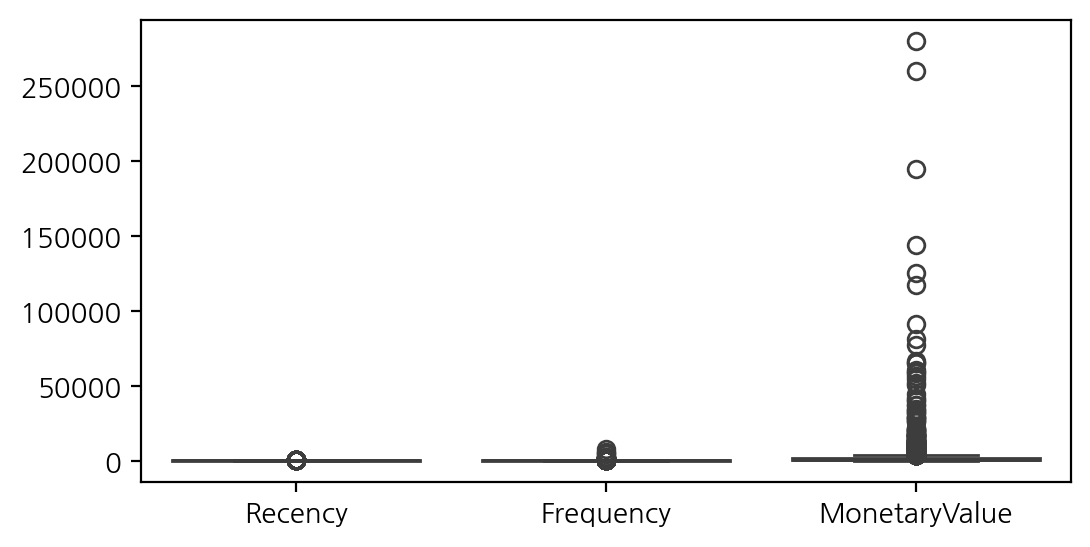

In [122]:
plt.figure(figsize=(6, 3))
sns.boxplot(rfm)

<Axes: xlabel='Recency'>

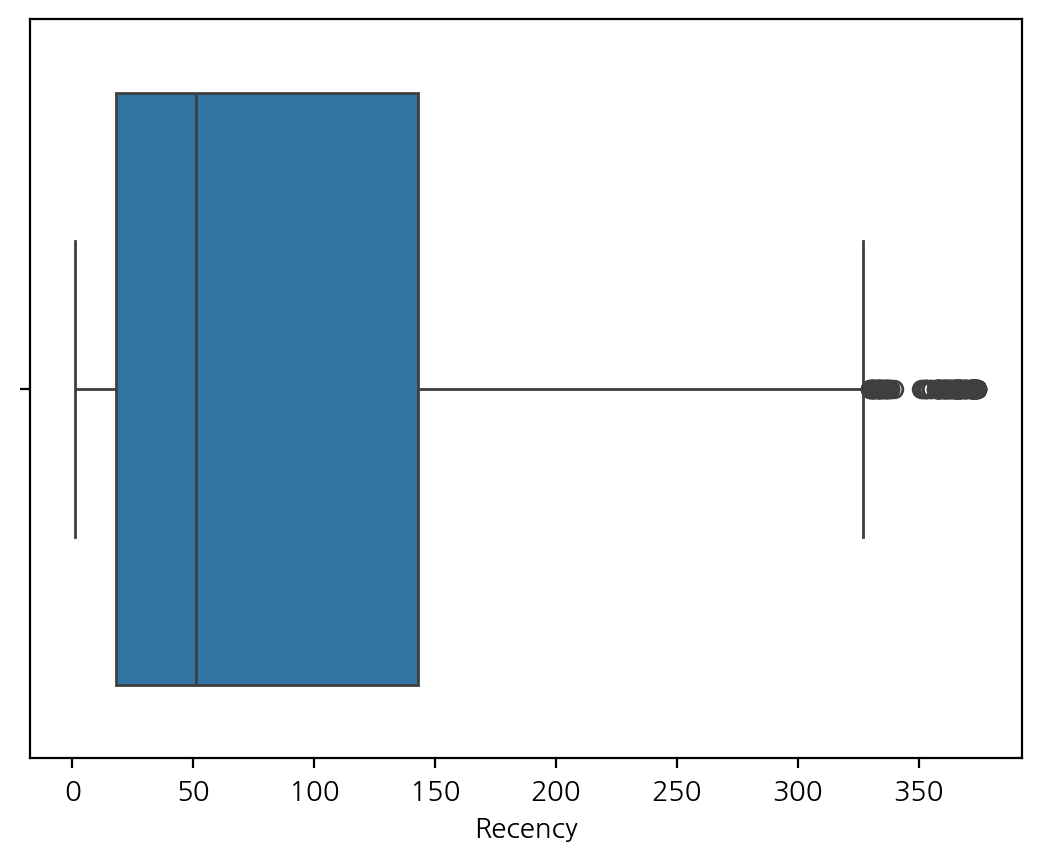

In [123]:
sns.boxplot(data=rfm, x='Recency')

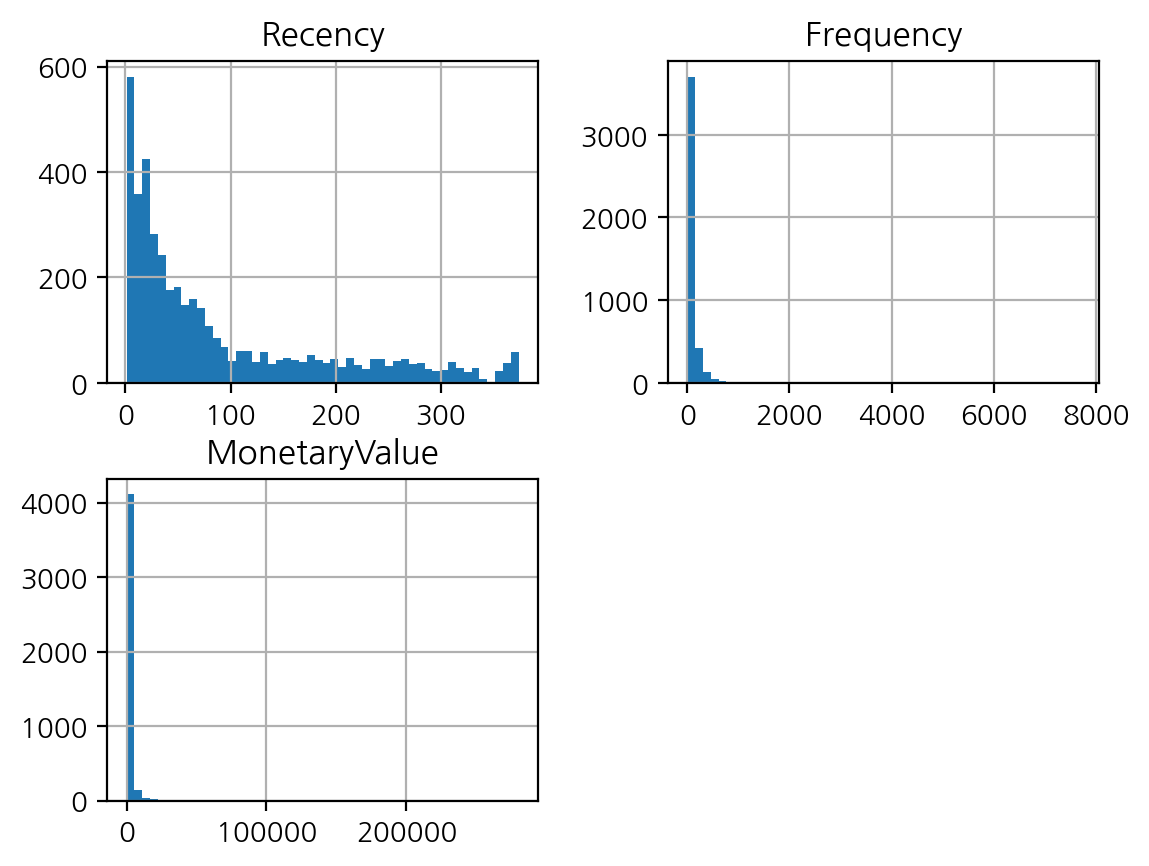

In [120]:
rfm.hist(bins=50);

- Recency
  - 왼쪽 데이터 쏠림, 오른쪽 긴 꼬리

### ⏹️ RFM 모형
- Scoring 기법
  - RFM의 요인을 각각 5등급 등간격으로 분류하는 방법
- 현재 개발된 RFM 모형은 크게 4가지로 분류할 수 있음
  1. RFM 각 요소의 20% rule의 적용
  2. 비율 척도에 의한 양적인 정도의 차이에 따른 등간격의 5등급 분류
  3. 상하 20%를 제외한 등간격 척도에 의한 그룹 분류
  4. 군집 분석에 의한 각 요소 별 5개의 그룹 분류

**[qcut을 통한 RFM 변수 만들기]**
- Equal-length buckets
  - 동일한 길이로 나누기
  - cut()
  - 예시
    - 히스토그램, 절대평가
  - `pd.cut()`
- Equal-size buckets 
  - 동일 개수로 나누기
  - qcut()
  - 예시
    - 4분위 수, 상대평가
  - `pd.qcut()`

In [130]:
# Recency는 최근일수록 높은 스코어
# Frequency, MonetaryValue는 값이 클수록 높은 스코어
# r_labels
r_labels = list(range(5, 0, -1))
f_labels = list(range(1, 6))
m_labels = list(range(1, 6))
cut_size = 5

In [128]:
pd.qcut?


Signature:
pd.qcut(
    x,
    q,
    labels=None,
    retbins: 'bool' = False,
    precision: 'int' = 3,
    duplicates: 'str' = 'raise',
)
Docstring:
Quantile-based discretization function.

Discretize variable into equal-sized buckets based on rank or based
on sample quantiles. For example 1000 values for 10 quantiles would
produce a Categorical object indicating quantile membership for each data point.

Parameters
----------
x : 1d ndarray or Series
q : int or list-like of float
    Number of quantiles. 10 for deciles, 4 for quartiles, etc. Alternately
    array of quantiles, e.g. [0, .25, .5, .75, 1.] for quartiles.
labels : array or False, default None
    Used as labels for the resulting bins. Must be of the same length as
    the resulting bins. If False, return only integer indicators of the
    bins. If True, raises an error.
retbins : bool, optional
    Whether to return the (bins, labels) or not. Can be useful if bins
    is given as a scalar.
precision : int, optional
    

In [133]:
r_qcut = pd.qcut(x=rfm['Recency'], q=cut_size, labels=r_labels)
f_qcut = pd.qcut(x=rfm['Frequency'], q=cut_size, labels=f_labels)
m_qcut= pd.qcut(x=rfm['MonetaryValue'], q = cut_size, labels=m_labels)

r_qcut.value_counts(1)

Recency
4    0.204703
5    0.203550
1    0.199631
3    0.197787
2    0.194329
Name: proportion, dtype: float64

In [134]:
f_qcut.value_counts(1)

Frequency
1    0.213693
4    0.199401
5    0.198709
3    0.195251
2    0.192946
Name: proportion, dtype: float64

In [135]:
m_qcut.value_counts(1)

MonetaryValue
1    0.200092
3    0.200092
5    0.200092
2    0.199862
4    0.199862
Name: proportion, dtype: float64

In [137]:
# assign을 사용하면 여러 변수를 한 번에 만들 수 있음
rfm = rfm.assign(R=r_qcut, F=f_qcut, M=m_qcut)
rfm.head()

Recency  Frequency  MonetaryValue  R  F  M
CustomerID                                            
12346.0         326          1       77183.60  1  1  5
12347.0           2        182        4310.00  5  5  5
12348.0          75         31        1797.24  2  3  4
12349.0          19         73        1757.55  4  4  4
12350.0         310         17         334.40  1  2  2

**[RFM 세그먼트]**

In [144]:
# RFM_segment 값 구하기
# R, F, M 값을 문자 그대로 붙여서 세그먼트를 구분
# rfm['RFM_segment']
rfm['RFM_segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

**[RFM Score]**

In [142]:
# R, F, M 의 합계를 구해서 세그먼트 점수를 구함
rfm['RFM_score'] = rfm[['R', 'F', 'M']].astype(int).sum(axis=1)
rfm.head(2)

Recency  Frequency  MonetaryValue  R  F  M  RFM_score
CustomerID                                                       
12346.0         326          1        77183.6  1  1  5          7
12347.0           2        182         4310.0  5  5  5         15

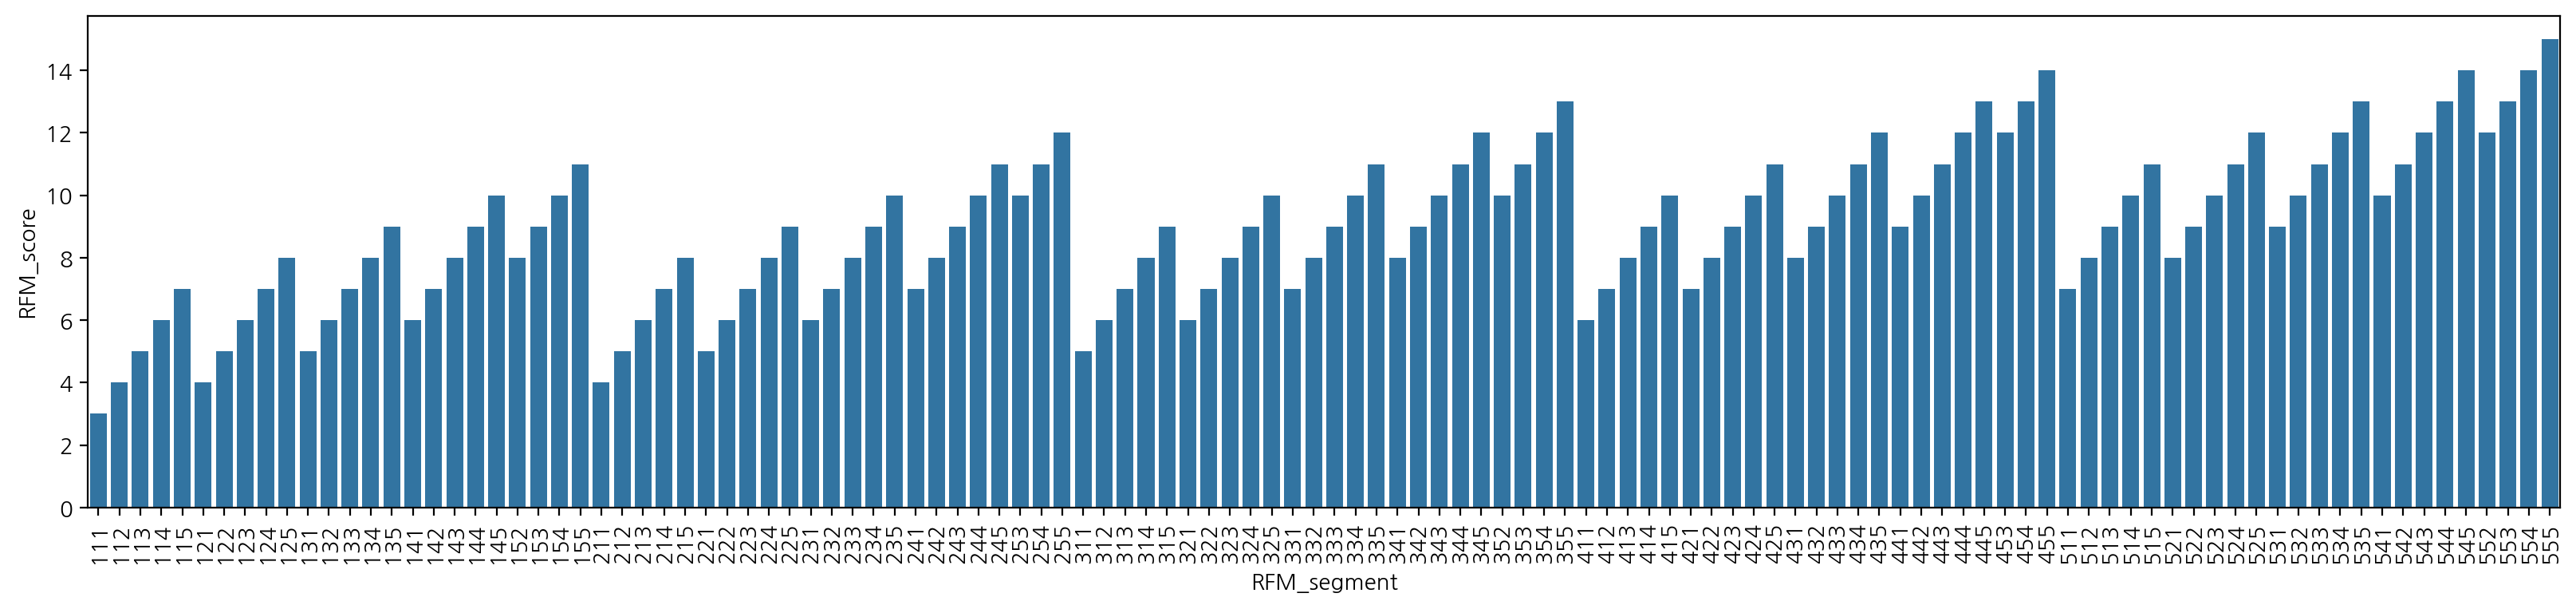

In [147]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation = 90)
sns.barplot(data=rfm.sort_values('RFM_segment'), x='RFM_segment', y='RFM_score');

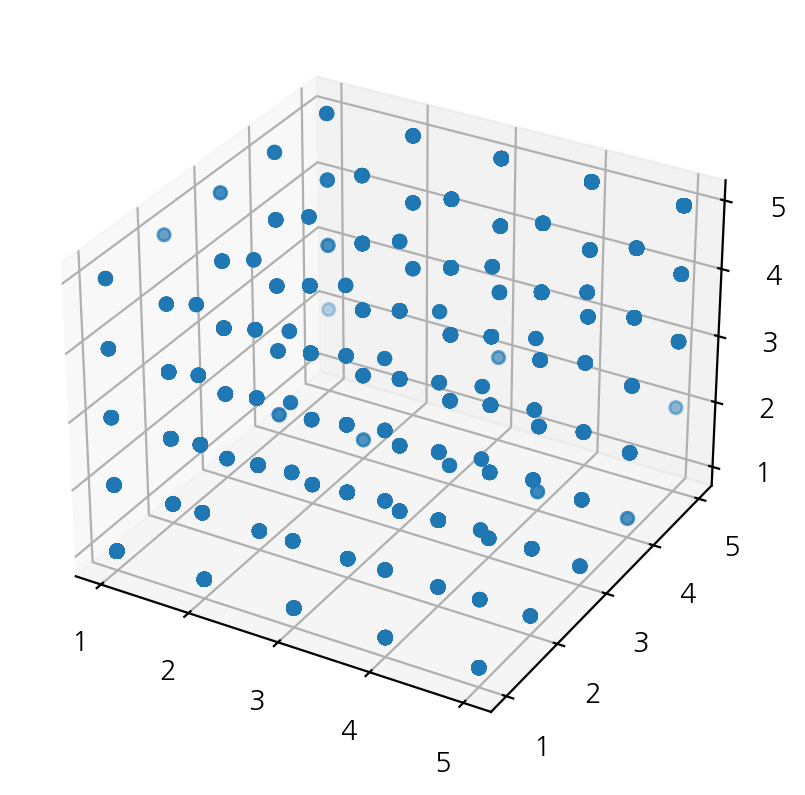

In [149]:
# 3d projection
ax = plt.axes(projection = '3d')
ax.scatter3D(rfm['R'], rfm['F'], rfm['M']);

- 고객을 같은 간격으로 나눠서 보고자 할 때

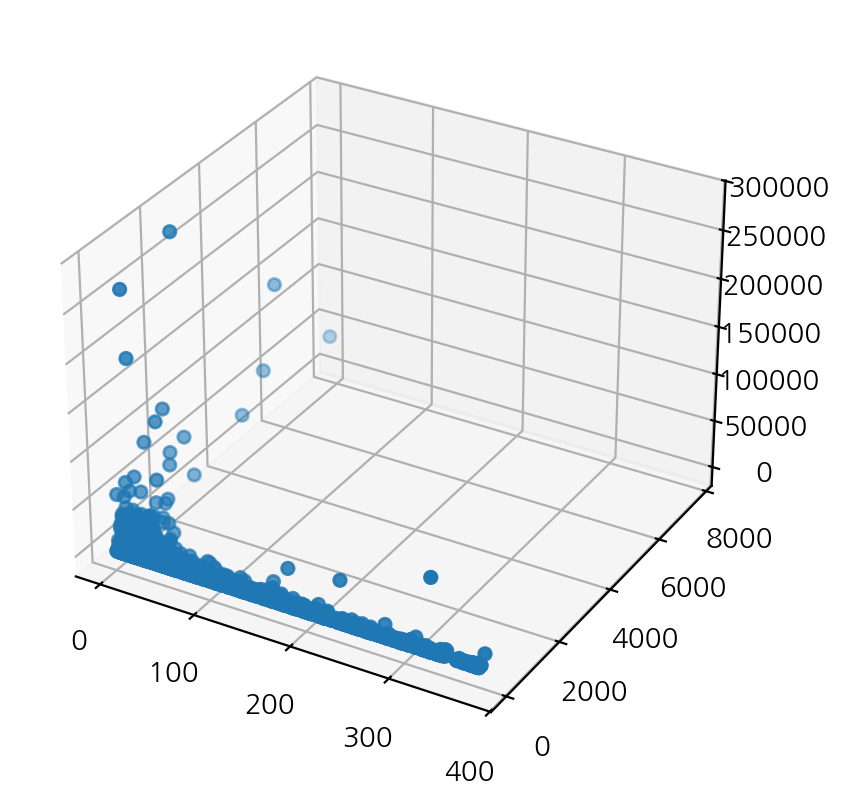

In [153]:
# rfm['Recancy'], rfm['Frequency'], rfm['Monetary']
ax = plt.axes(projection='3d')
ax.scatter3D(rfm['Recency'], rfm['Frequency'], rfm['MonetaryValue']);

- 이상치를 찾을 때 좋음

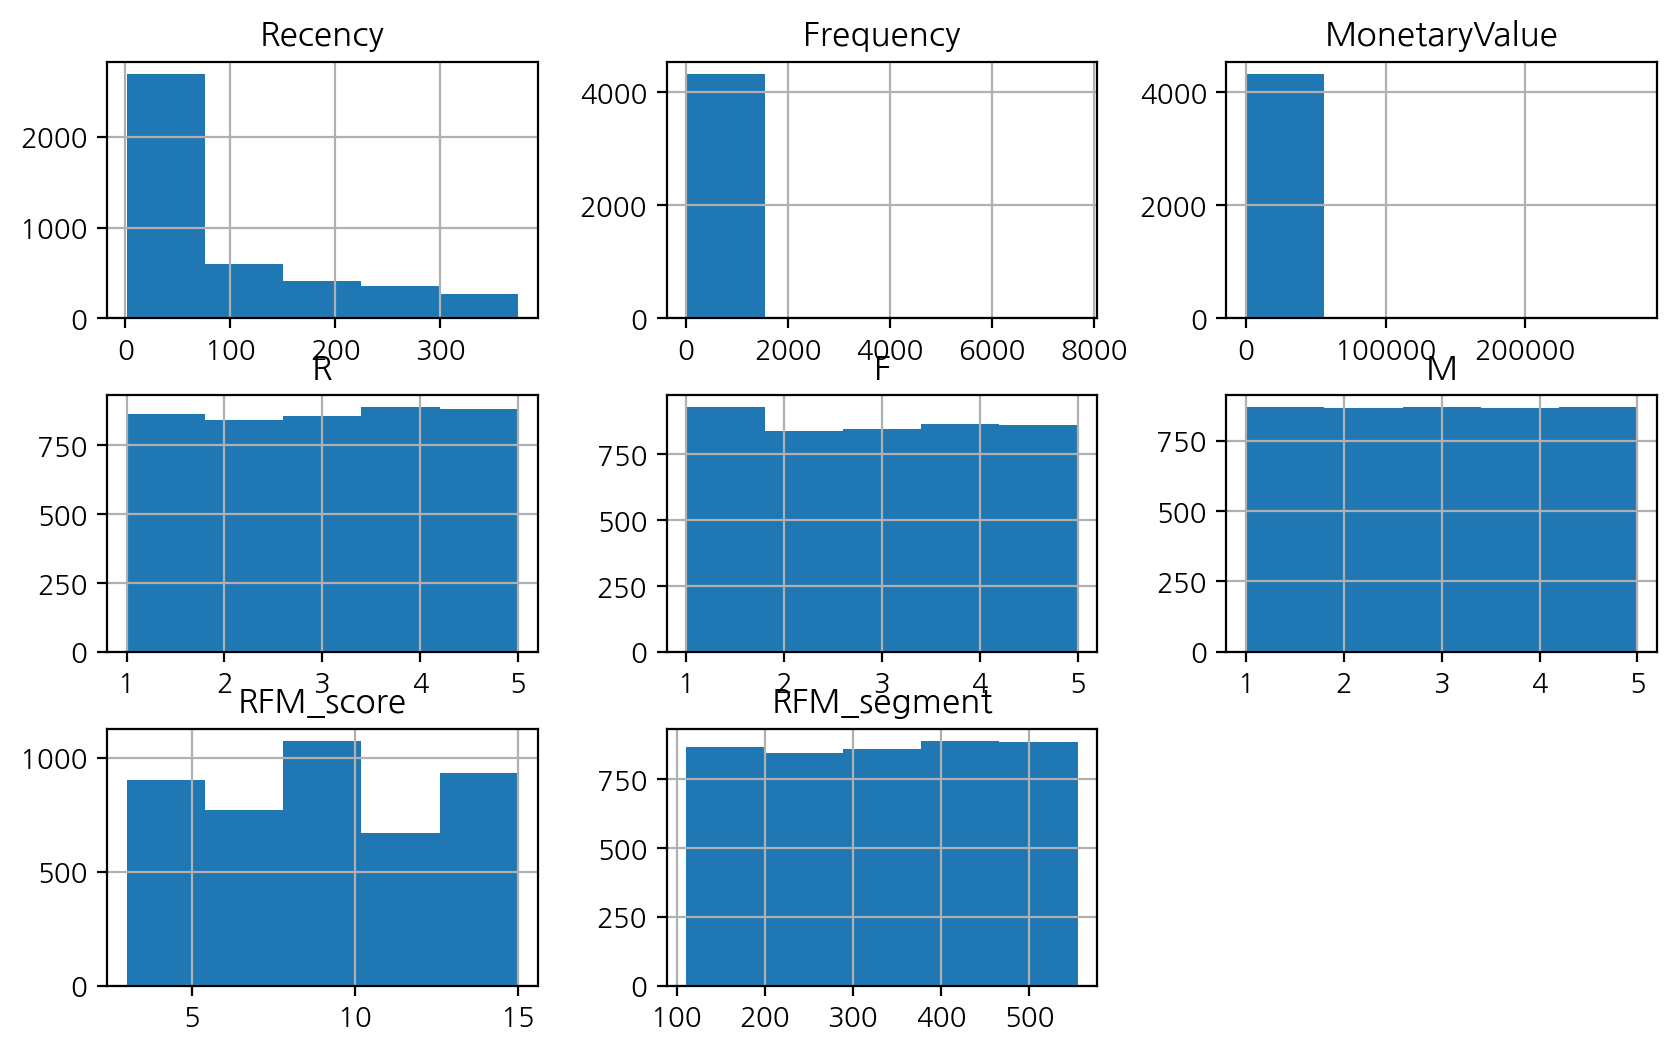

In [155]:
rfm.astype(int).hist(figsize=(10,6), bins = 5);

In [160]:
# 문자열의 format 함수를 사용해 소수점 아래는 표기하지 않도록 ({:,.0f}) 문자열 포맷을 지정
rfm.groupby('RFM_score').agg({'Recency':'mean', 'Frequency':'mean', 'MonetaryValue':['mean','sum']}).style.background_gradient().format('{:,.0f}')

**[qcut을 통한 고객군 나누기]**

In [163]:
# qcut을 통해 3단계로 'silver', 'gold', 'platinum'ArithmeticError
# rfm['RFM_class']
rfm['RFM_class'] = pd.qcut(x=rfm['RFM_score'], q=3, labels=['silver','gold','platinum'])
rfm

Recency  Frequency  MonetaryValue  R  F  M  RFM_score RFM_segment  \
CustomerID                                                                      
12346.0         326          1       77183.60  1  1  5          7         115   
12347.0           2        182        4310.00  5  5  5         15         555   
12348.0          75         31        1797.24  2  3  4          9         234   
12349.0          19         73        1757.55  4  4  4         12         444   
12350.0         310         17         334.40  1  2  2          5         122   
...             ...        ...            ... .. .. ..        ...         ...   
18280.0         278         10         180.60  1  1  1          3         111   
18281.0         181          7          80.82  1  1  1          3         111   
18282.0           8         12         178.05  5  1  1          7         511   
18283.0           4        721        2045.53  5  5  4         14         554   
18287.0          43         70        1837.28  3  4  4         11         344   

           RFM_class  
CustomerID            
12346.0       silver  
12347.0     platinum  
12348.0         gold  
12349.0     platinum  
12350.0       silver  
...              ...  
18280.0       silver  
18281.0       silver  
18282.0       silver  
18283.0     platinum  
18287.0         gold  

[4338 rows x 9 columns]

In [164]:
# RFM_class 별로 그룹화하고 RFM_score의 describe 값 구하기
rfm.groupby('RFM_class')['RFM_score'].describe()

/var/folders/yl/lyd4cgp16bj2jd049cmb64n00000gn/T/ipykernel_60378/349548335.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm.groupby('RFM_class')['RFM_score'].describe()


count       mean       std   min   25%   50%   75%   max
RFM_class                                                           
silver     1668.0   5.209832  1.384324   3.0   4.0   5.0   6.0   7.0
gold       1409.0   9.469127  1.114505   8.0   8.0   9.0  10.0  11.0
platinum   1261.0  13.471055  1.124120  12.0  12.0  13.0  14.0  15.0

<Axes: xlabel='RFM_class', ylabel='RFM_score'>

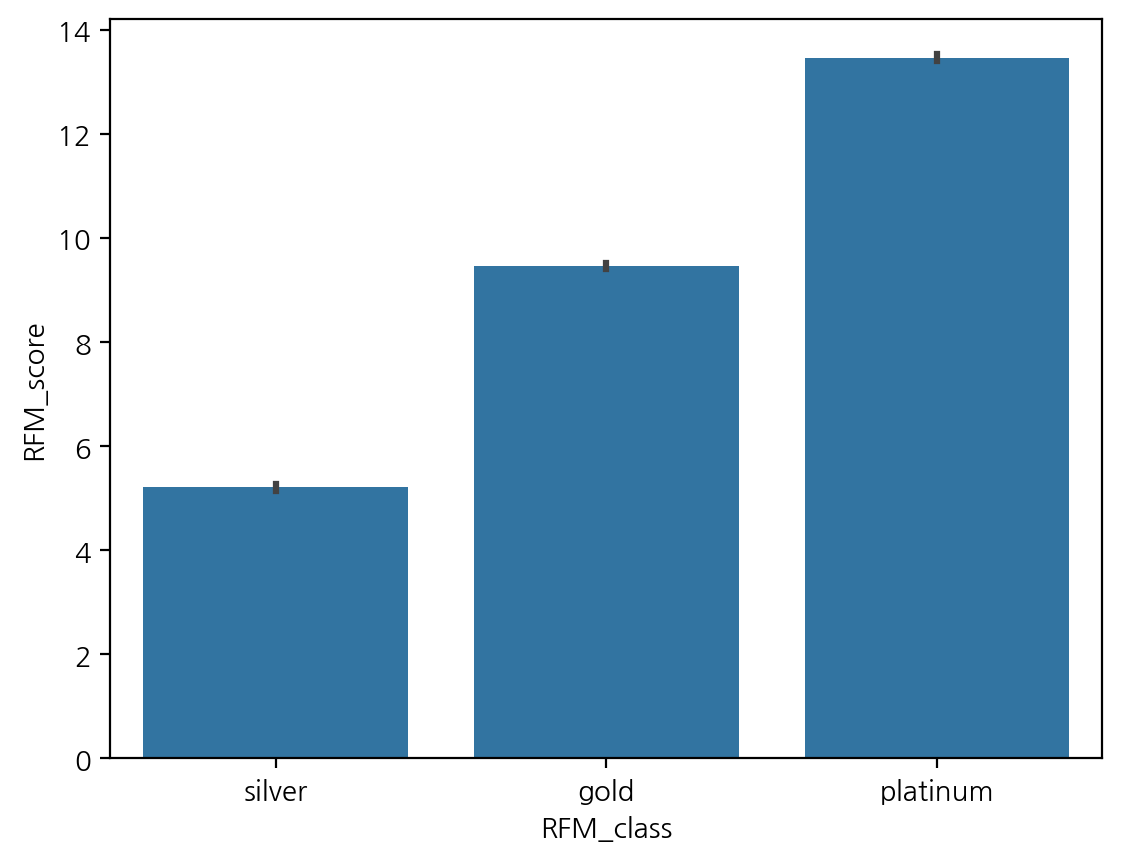

In [165]:
# barplot으로 RFM_class 별 평균 RFM_score 나타냄
sns.barplot(data=rfm, x='RFM_class', y='RFM_score')

<Axes: xlabel='RFM_class', ylabel='RFM_score'>

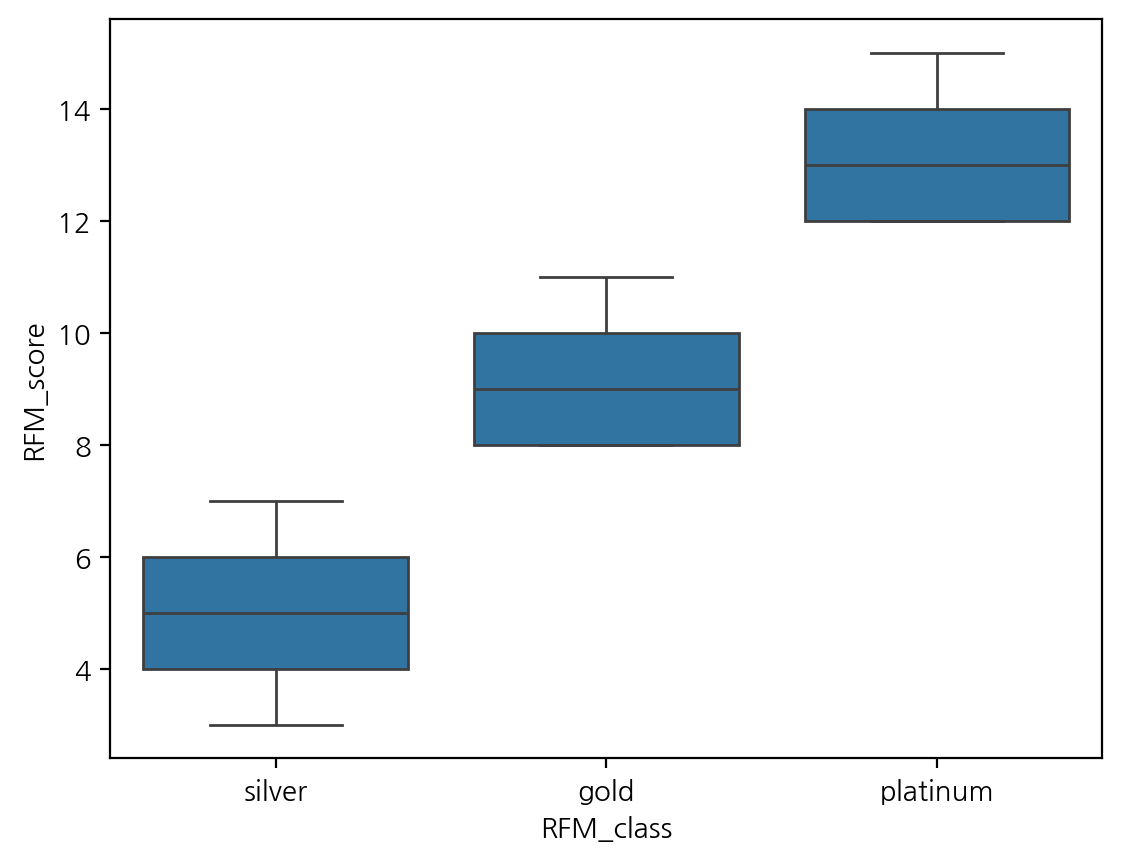

In [166]:
# boxplot으로 RFM class 별 평균 RFM_score 나타냄
sns.boxplot(data=rfm, x='RFM_class', y='RFM_score')

<Axes: xlabel='R', ylabel='RFM_score'>

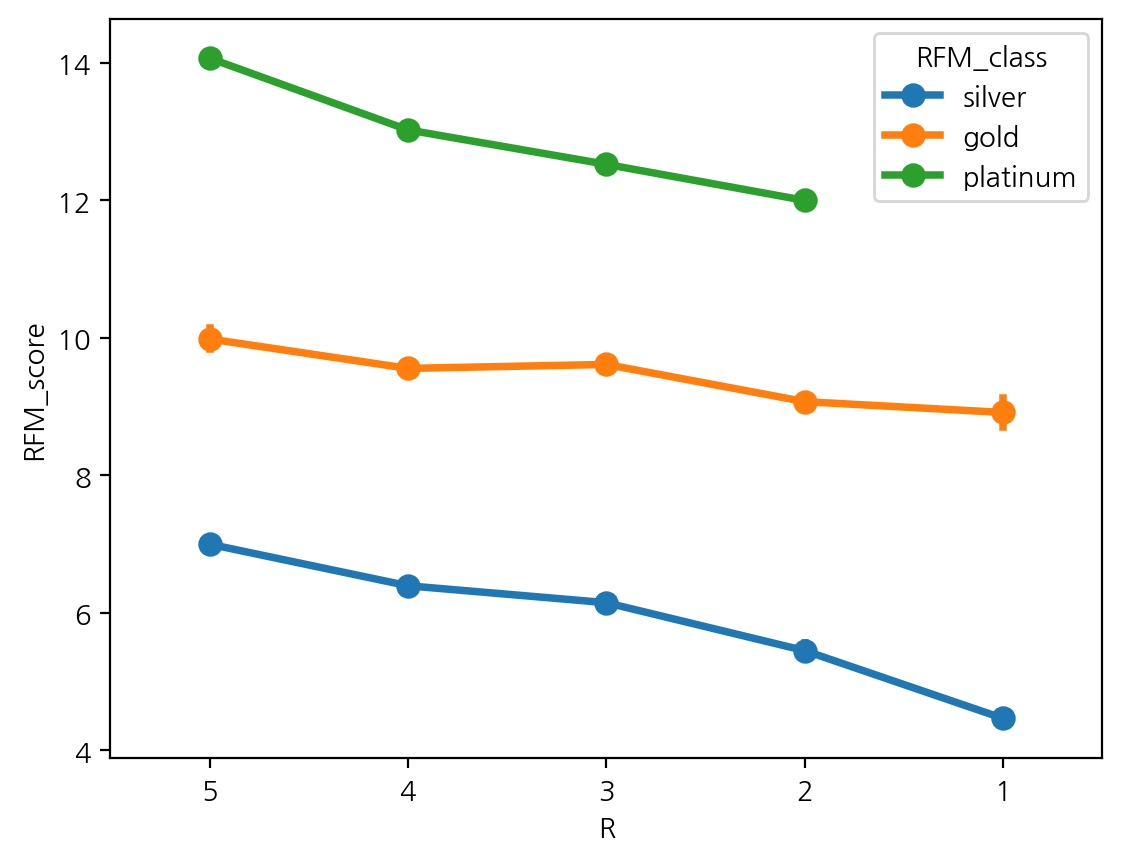

In [169]:
# pointplot으로 x=R, hue=RFM_class 별 평균 y=RFM_score 나타내기
# hue 옵션을 사용하면 특정 컬럼 지정 표기
sns.pointplot(data=rfm, x='R', y='RFM_score', hue = 'RFM_class')

<Axes: xlabel='F', ylabel='RFM_score'>

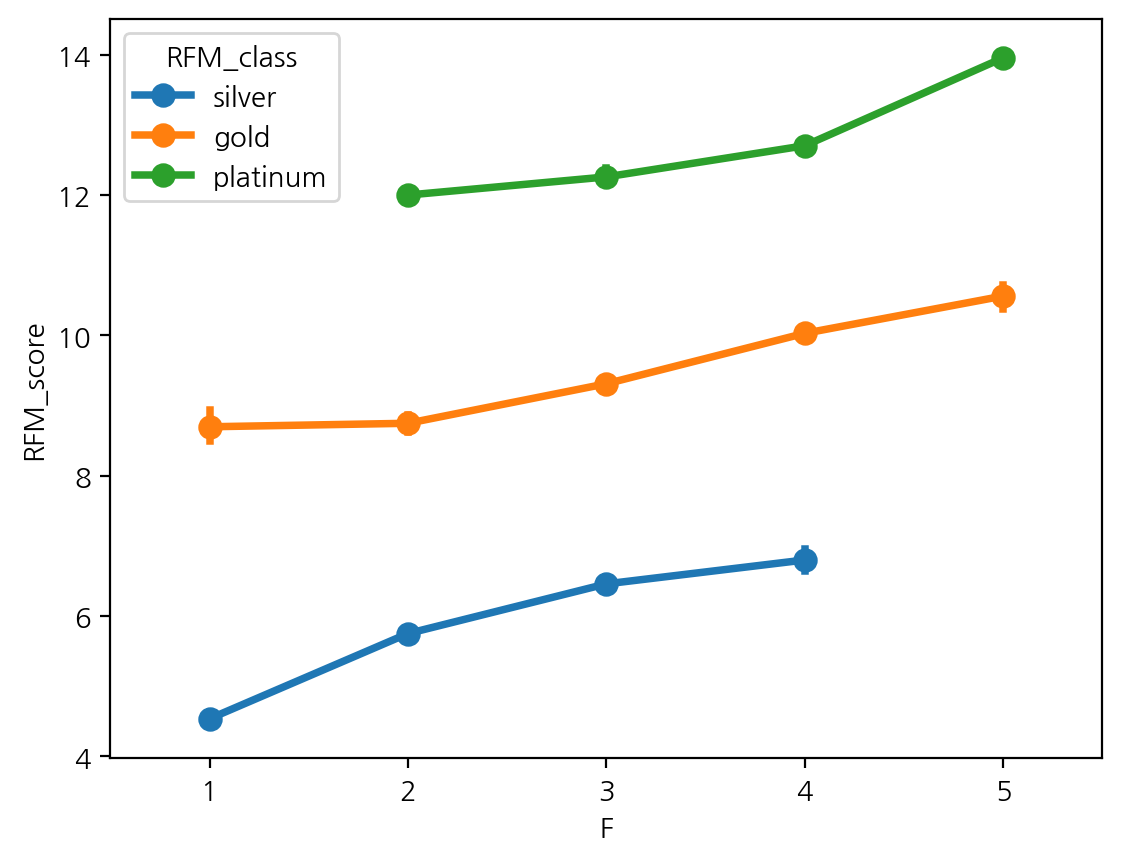

In [172]:
# pointplot으로 x=F, hue=RFM_class 별 평균 y = RFM_score 나타내기
sns.pointplot(data=rfm, x='F', y='RFM_score', hue='RFM_class')

<Axes: xlabel='M', ylabel='RFM_score'>

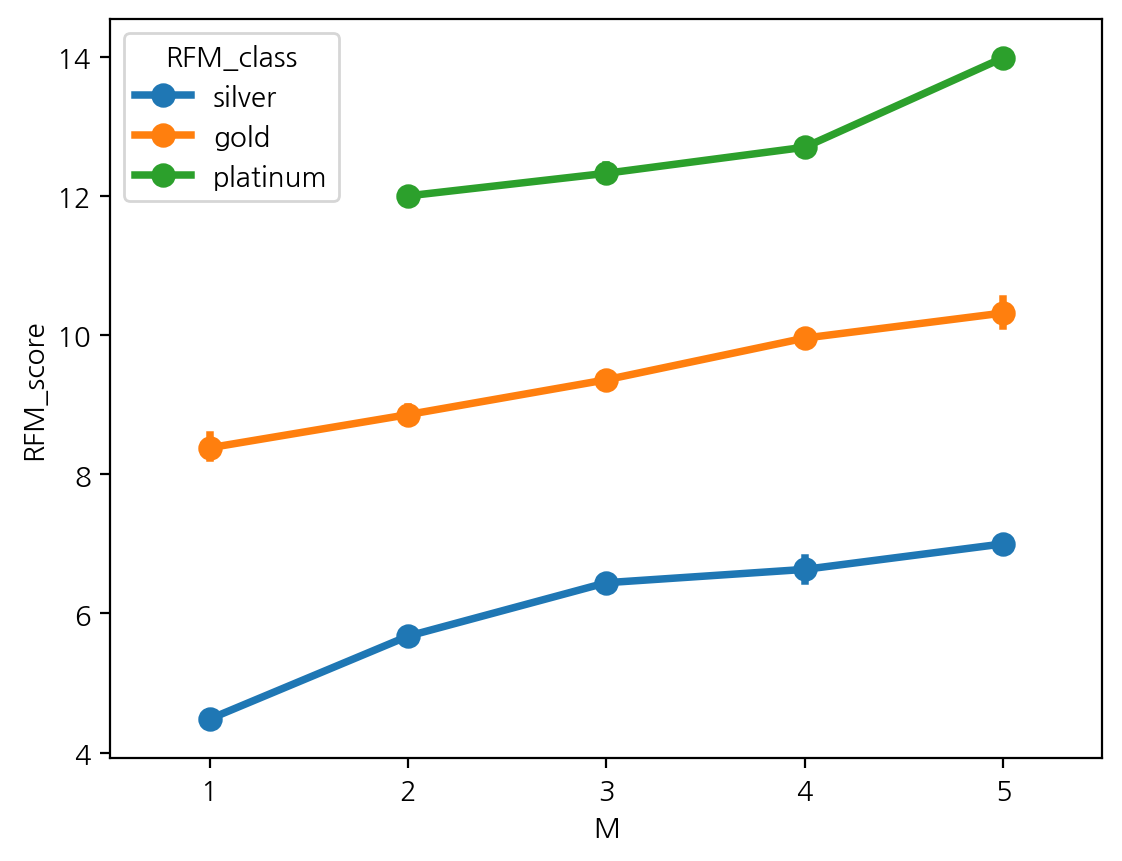

In [ ]:
# pointplot으로 x=M, hue=RFM_class 별 평균 y = RFM_score 나타내기
sns.pointplot(data=rfm, x='M', y='RFM_score', hue='RFM_class')

In [174]:
rfm.columns

Index(['Recency', 'Frequency', 'MonetaryValue', 'R', 'F', 'M', 'RFM_score',
       'RFM_segment', 'RFM_class'],
      dtype='object')

In [175]:
# RFM_class 별로 그룹화
# Recency, Frequency 의 평균 구하기
# MomentaryValue의 mean, sum, count 값 구하기
rfm.groupby('RFM_class').agg({'Recency':'mean',
                              'Frequency':'mean',
                              'MonetaryValue':['mean','sum','count']})

/var/folders/yl/lyd4cgp16bj2jd049cmb64n00000gn/T/ipykernel_60378/966226334.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm.groupby('RFM_class').agg({'Recency':'mean',


Recency   Frequency MonetaryValue                   
                 mean        mean          mean          sum count
RFM_class                                                         
silver     170.072542   17.068945    411.232339   685935.542  1668
gold        65.855926   55.664301   1005.104153  1416191.752  1409
platinum    19.949247  226.636796   5247.114988  6616612.000  1261

- 3개의 그룹이 완전히 똑같은 비율로 나눠지진 않음

In [180]:
# 위에서 구한 값을 .style.background_gradient() 통해서 시각화
rfm.groupby('RFM_class').agg({'Recency': 'mean',
                              'Frequency':'mean',
                              'MonetaryValue': ['mean','sum','count']
                              }).style.background_gradient(cmap='PuBu').format('{:,.0f}')

/var/folders/yl/lyd4cgp16bj2jd049cmb64n00000gn/T/ipykernel_60378/4093018005.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm.groupby('RFM_class').agg({'Recency': 'mean',


In [181]:
# style.format('{:,.0f}')로 천 단위에 콤마 표기되도록 문자열 포맷 지정

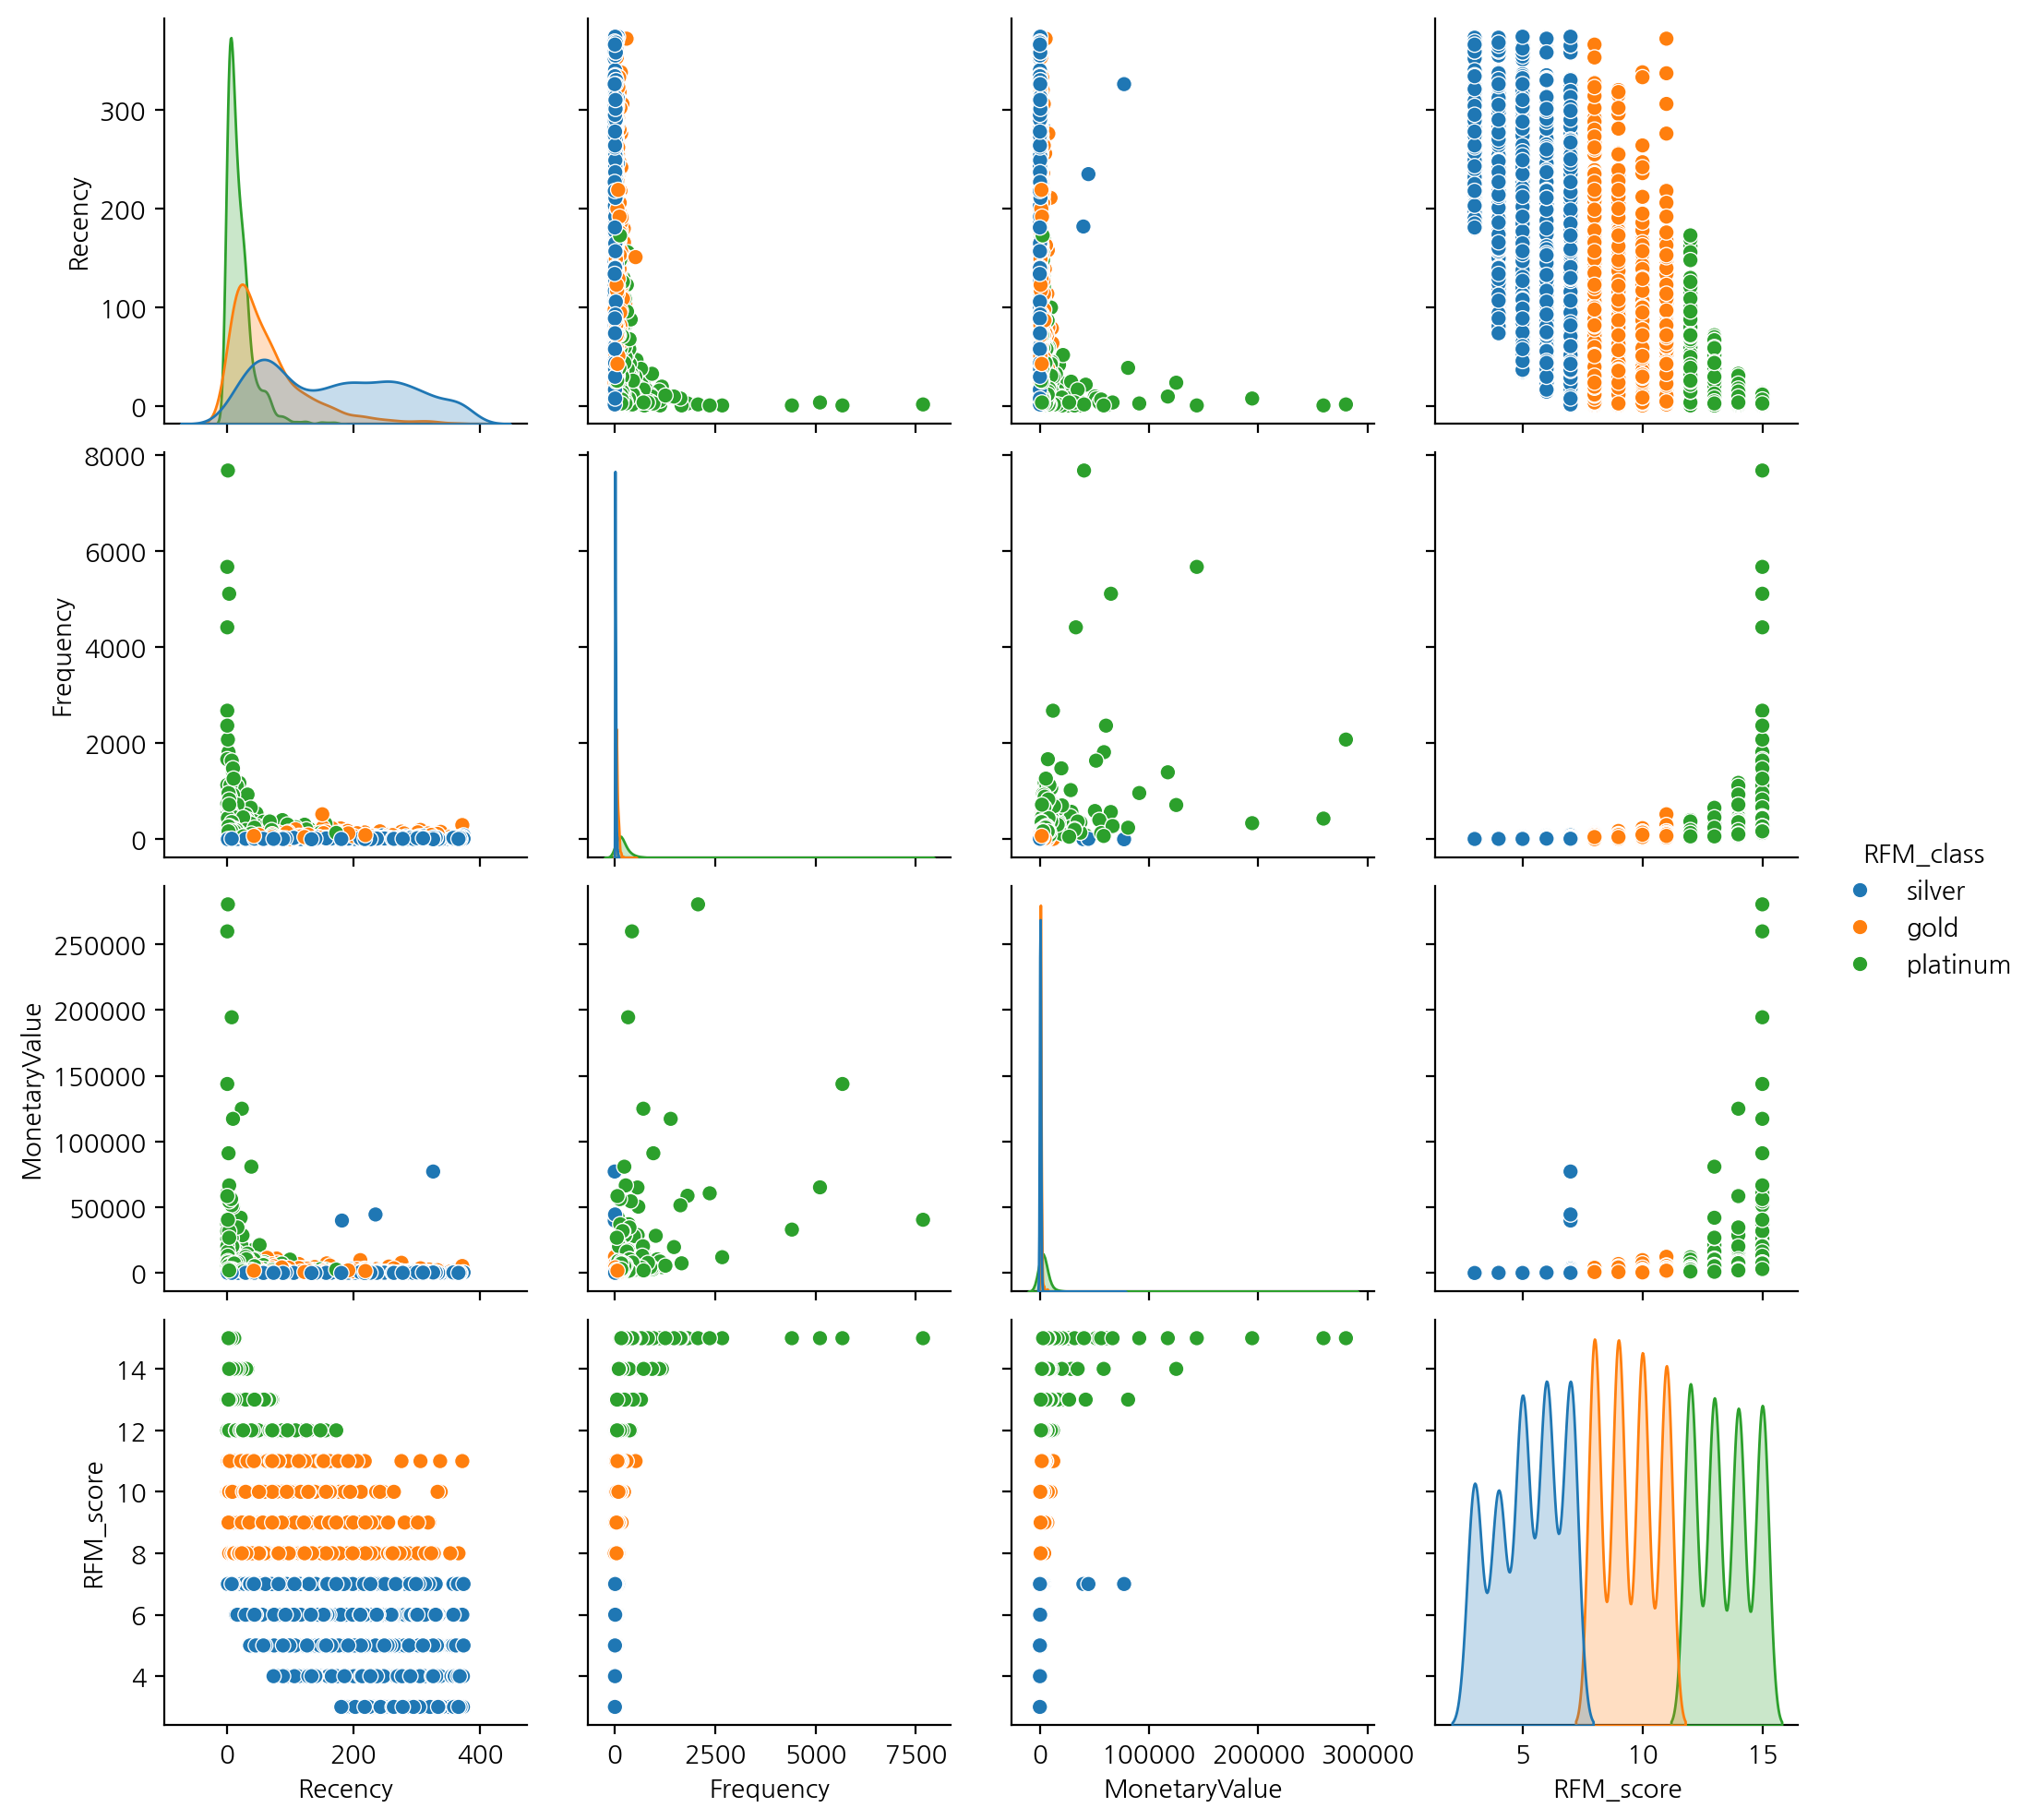

In [187]:
# pairplot을 통해 'RFM_class'별로 분포 시각화
sns.pairplot(data=rfm, hue='RFM_class');

In [189]:
# .corr() 함수로 변수간 상관관계(선형적 관계) 분석
# 1에 가까울수록 양의 상관관계, -1에 가까울수록 음의 상관관계
corr = rfm.select_dtypes(include='number').corr()
corr

Recency  Frequency  MonetaryValue  RFM_score
Recency        1.000000  -0.206618      -0.122937  -0.700621
Frequency     -0.206618   1.000000       0.444920   0.404260
MonetaryValue -0.122937   0.444920       1.000000   0.250433
RFM_score     -0.700621   0.404260       0.250433   1.000000

In [194]:
# 삼각형태의 heatmap 형태를 만들기 위해 삼각형 마스크 만들기
mask = np.triu(np.ones_like(corr))
mask

array([[1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

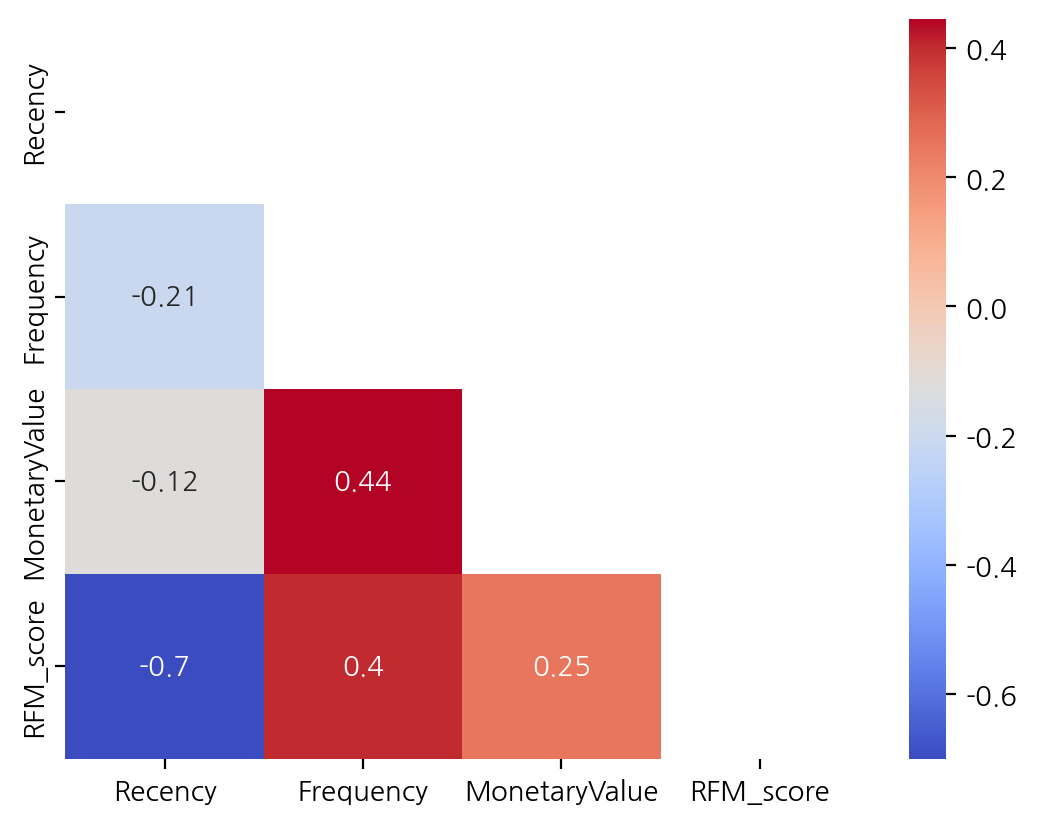

In [195]:
# 상관관계 시각화
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask);

- Recency 와 RFM_score
  - 높은 음의 상관관게
  - &larr; Recency는 최근의 값일수록 점수 높음

In [197]:
# RFM 분석 자료 csv로 저장
rfm.to_csv('rfm.csv')

In [198]:
# 저장된 csv 형태의 RFM 분석 자료 읽기
pd.read_csv('rfm.csv')

CustomerID  Recency  Frequency  MonetaryValue  R  F  M  RFM_score  \
0        12346.0      326          1       77183.60  1  1  5          7   
1        12347.0        2        182        4310.00  5  5  5         15   
2        12348.0       75         31        1797.24  2  3  4          9   
3        12349.0       19         73        1757.55  4  4  4         12   
4        12350.0      310         17         334.40  1  2  2          5   
...          ...      ...        ...            ... .. .. ..        ...   
4333     18280.0      278         10         180.60  1  1  1          3   
4334     18281.0      181          7          80.82  1  1  1          3   
4335     18282.0        8         12         178.05  5  1  1          7   
4336     18283.0        4        721        2045.53  5  5  4         14   
4337     18287.0       43         70        1837.28  3  4  4         11   

      RFM_segment RFM_class  
0             115    silver  
1             555  platinum  
2             234      gold  
3             444  platinum  
4             122    silver  
...           ...       ...  
4333          111    silver  
4334          111    silver  
4335          511    silver  
4336          554  platinum  
4337          344      gold  

[4338 rows x 10 columns]